<a href="https://colab.research.google.com/github/NguyenThiHongLinh/TieuLuan2024/blob/main/Ti%E1%BB%83u_lu%E1%BA%ADn_Taiwan3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Kết nối với drive, import thư viện

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd '/content/gdrive/MyDrive/Data tiểu luận'
! pip install pypots>=0.4

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/Data tiểu luận


In [3]:
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
from prettytable import PrettyTable
from numpy import mean
from numpy import std
# import miceforest as mf
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
# from pypots.data import load_specific_dataset, mcar, masked_fill
import torch
from pypots.data import load_specific_dataset
from pypots.imputation import SAITS
from pypots.optim import Adam
from pypots.imputation import BRITS
from pypots.imputation import MRNN
from pypots.imputation import Transformer
from pypots.utils.metrics import calc_mae
from pypots.utils.metrics import calc_mse
from pypots.utils.metrics import calc_rmse

In [4]:
dtype = {
    "station": str,
    "AMB_TEMP": int,
    "CH4": int,
    "CO": float,
    "NMHC": float,
    "NO": float,
    "NO2": int,
    "NOx": int,
    "O3": int,
    "PH_RAIN": str,
    "PM10": int,
    "PM2.5": int,
    "RAINFALL": str,
    "RAIN_COND": str,
    "RH": str,
    "SO2": int,
    "THC": float,
    "UVB": int,
    "WD_HR": int,
    "WIND_DIREC": int,
    "WIND_SPEED": float,
    "WS_HR": float
}


def clean_data(elem):
    elem = str(elem)
    if elem == None or elem == '':
        return np.NaN
    if any(x in elem for x in ["#", "*", "x"]):
        return np.NaN
    if any(x in elem for x in [".", "e"]):
        return float(elem)
    if elem in 'NR':
        return -1
    return int(elem)

converters = {
    "AMB_TEMP": clean_data,
    "CH4": clean_data,
    "CO": clean_data,
    "NMHC": clean_data,
    "NO": clean_data,
    "NO2": clean_data,
    "NOx": clean_data,
    "O3": clean_data,
    "PH_RAIN": clean_data,
    "PM10": clean_data,
    "PM2.5": clean_data,
    "RAINFALL": clean_data,
    "RAIN_COND": clean_data,
    "RH": clean_data,
    "SO2": clean_data,
    "THC": clean_data,
    "UVB": clean_data,
    "WD_HR": clean_data,
    "WIND_DIREC": clean_data,
    "WIND_SPEED": clean_data,
    "WS_HR": clean_data
}

## Load dataset, tính toán % dữ liệu bị thiếu

In [5]:
def load_taiwan2015():
  dataset = pd.read_csv('taiwan2015_air_quality.csv', dtype = dtype, converters = converters, parse_dates = ['time'])
  dataset['time'] = pd.to_datetime(dataset['time'])
  return dataset

In [6]:
# Compute % missing rate of a given dataset (as a DataFrame)
def missing_rate(dataset):
  total_missing = dataset.isnull().sum().sum()
  percent_missing = (total_missing / dataset.size) * 100
  return round(percent_missing,2)

## Tiền xử lý dữ liệu

In [7]:
def preprocess_taiwan2015(dataset):
    """The preprocessing function for dataset Air Quality Beijing.
    Parameters
    ----------
    dataset : raw dataset loaded from csv file.
    Returns
    -------
    dataset : pandas.DataFrame,
                A dataframe contains all time series vectors, distinguished by column 'station'.
    """
    print('Columns:', dataset.columns)

    # Giả sử dữ liệu ngày tháng nằm trong cột 'time', tách ngày và giờ
    if 'time' in dataset.columns:
        dataset['date'] = pd.to_datetime(dataset['time']).dt.date
        dataset['hour'] = pd.to_datetime(dataset['time']).dt.hour
    else:
        raise KeyError("'time' column not found in dataset")

    # Kiểm tra và bổ sung các ngày thiếu
    stations = dataset['station'].unique()
    full_date_range = pd.date_range(start=dataset['date'].min(), end=dataset['date'].max(), freq='D')

    df_list = []
    for station in stations:
        station_data = dataset[dataset['station'] == station]
        station_dates = station_data['date'].unique()
        missing_dates = set(full_date_range.date).difference(station_dates)

        for missing_date in missing_dates:
            missing_date_data = pd.DataFrame({
                'time': [pd.Timestamp(missing_date) + pd.Timedelta(hours=h) for h in range(24)],
                'station': station,
                'date': [missing_date] * 24,
                'hour': range(24)
            })
            station_data = pd.concat([station_data, missing_date_data], ignore_index=True)

        df_list.append(station_data)

    dataset = pd.concat(df_list, ignore_index=True)

    X = dataset
    print('X shape: ', X.shape)

    def apply_func(df_temp):  # pad and truncate to set the max length of samples as 24
        missing = list(set(range(0, 24)).difference(set(df_temp['hour'])))
        missing_part = pd.DataFrame({
            'time': [df_temp['time'].iloc[0].replace(hour=h) for h in missing],
            'hour': missing
        })
        df_temp = pd.concat(
            [df_temp, missing_part], ignore_index=False, sort=False
        )  # pad the sample's length to 24 if it doesn't have enough time steps
        df_temp = df_temp.set_index('time').sort_index().reset_index()
        df_temp = df_temp.iloc[:24]  # truncate
        return df_temp

    X = X.groupby(['station', 'date']).apply(apply_func)
    X = X.drop('hour', axis=1)
    X = X.drop('station', axis=1)
    X = X.drop('date', axis=1)
    X = X.reset_index()
    X = X.drop(["level_2"], axis=1)

    return X


## Biểu diễn dữ liệu bị thiếu

In [8]:
def display_missing_percent(dataset):
  total = dataset.isnull().sum().sort_values(ascending=False)
  percent = (dataset.isnull().sum()/dataset.isnull().count()).sort_values(ascending=False)
  missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
  f, ax = plt.subplots(figsize=(15, 6))
  # plt.xticks(rotation='90')
  sns.barplot(x=missing_data.index, y=missing_data['Percent'])
  plt.xlabel('Features', fontsize=15)
  plt.ylabel('Percent of missing values', fontsize=15)
  plt.title('Percent missing data by feature', fontsize=15)
  missing_data.head

## Lọc và sắp xếp các bản ghi theo từng khu vực

In [9]:
def get_stat_by_station(dataset):
  myTable = PrettyTable(["No.","station","#Records","From date","To date"])
  # Split dataframe by RecordID
  j = 1
  classification=list(dataset['station'].unique())
  for i in classification:
    pm1=dataset[dataset['station'].isin([i])]
    myTable.add_row([j,
                     i,
                    format(pm1.shape[0], ','),
                    pm1['time'].values[0],
                    pm1['time'].values[pm1.shape[0]-1]])
  j+=1
  return myTable

## Biểu đồ phân phối tần suất thời gian

In [10]:
# Danh sách các bộ dữ liệu và tên của chúng
def timeGraph(dataset):

# Khởi tạo figure
  plt.figure(figsize=(10, 6))

  # Lặp qua từng bộ dữ liệu và tên
  for dataset, time_column in dataset:
      # Chuyển đổi cột thời gian sang định dạng datetime
      time_data = pd.to_datetime(dataset[time_column])
      # Trích xuất giờ từ các đối tượng datetime
      hours = [time.hour for time in time_data]
      # Vẽ biểu đồ histogram
      plt.hist(hours, bins=24, edgecolor='black', alpha=0.5, label=time_column)

  # Thiết lập tiêu đề và nhãn trục
  plt.xlabel('Giờ')
  plt.ylabel('Số lượng')
  plt.title('Phân phối tần suất của dữ liệu thời gian')
  plt.xticks(range(0, 24))
  plt.grid(True)
  plt.legend()  # Hiển thị chú thích về tên của mỗi bộ dữ liệu
  plt.show()

In [11]:
def find_time_steps(data):
    data['time'] = pd.to_datetime(data['time'], errors='coerce')

    if data['time'].isnull().any():
        print("Có các giá trị không thể chuyển đổi sang datetime:")
        print(data[data['time'].isnull()])
        return

    # tính chu kỳ giữa các bản ghi
    column_datetime1 = data['time']
    time_diffs = column_datetime1.diff().dt.total_seconds().dropna()
    cycle_seconds = time_diffs.mode().iloc[0]
    print("The cycle duration appears to be approximately", cycle_seconds, "seconds.")

    # Xác định xem thời gian được ghi lại trong 24 giờ hay 12 giờ
    time_difference = (column_datetime1.iloc[-1] - column_datetime1.iloc[0]).total_seconds()
    if time_difference > 12 * 3600:  # 12 hours * 3600 seconds/hour
        print("The time cycle appears to be 24 hours.")
    else:
        print("The time cycle appears to be 12 hours.")

    # Tìm giờ bị thiếu của từng station nếu có
    all_hours = set(range(24))
    data['date'] = data['time'].dt.date
    data['hour'] = data['time'].dt.hour

    stations = data['station'].unique()
    full_date_range = pd.date_range(start=data['date'].min(), end=data['date'].max(), freq='D')

    for station in stations:
        station_data = data[data['station'] == station]
        station_dates = station_data['date'].unique()
        missing_dates = set(full_date_range.date).difference(station_dates)

        missing_data = []
        for missing_date in missing_dates:
            missing_data.append((station, missing_date, list(all_hours)))

        for date, group in station_data.groupby('date'):
            hours_in_day = set(group['hour'])
            missing_hours = all_hours - hours_in_day
            if missing_hours:
                missing_data.append((station, date, sorted(missing_hours)))


        if missing_data:
            print(f"Station {station} is missing the following hours:")
            for station, date, missing_hours in missing_data:
                print(f"Date {date} is missing hours: {missing_hours}")
        else:
            print(f"Station {station} has no missing hours.")

## Tính trend, cycle của dữ liệu

In [12]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Tính trend của tập dữ liệu khi loại bỏ các giá trị bị thiếu
def calculate_trend(data):
    # Xử lý giá trị NaN: Loại bỏ các dòng chứa giá trị NaN
    data_cleaned = data.dropna()

    # Loại bỏ các cột không cần thiết nếu tồn tại
    for col in ['time', 'station', 'Unnamed: 0', 'date']:
        if col in data_cleaned.columns:
            data_cleaned = data_cleaned.drop([col], axis=1)

    column_names = list(data_cleaned.columns)
    num_subplots = len(column_names)  # Số lượng subplot bằng số cột dữ liệu

    fig, axes = plt.subplots(num_subplots, 1, figsize=(10, 6*num_subplots))

    # Vẽ biểu đồ dữ liệu và đường trend cho từng thuộc tính
    for idx, col in enumerate(column_names):
        X = np.array(range(len(data_cleaned))).reshape(-1, 1)
        y = data_cleaned[col].values.reshape(-1, 1)

        # Khởi tạo và fit mô hình hồi quy tuyến tính
        model = LinearRegression()
        model.fit(X, y)

        # Vẽ dữ liệu
        axes[idx].plot(data_cleaned[col], label=col)
        # Vẽ trend line
        axes[idx].plot(model.predict(X), label=f'Trend of {col}', linestyle='--')

        axes[idx].set_xlabel('Index')
        axes[idx].set_ylabel('Value')
        axes[idx].set_title(f'Trend of {col}')
        axes[idx].legend(loc="best")

    plt.tight_layout()  # Đảm bảo không gian giữa các subplot
    plt.show()

In [13]:
import pandas as pd
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
import matplotlib.pyplot as plt

def find_cycle(data, column, lags=50):
    """
    Hàm tính chu kỳ của dữ liệu chuỗi thời gian dựa trên hàm tự tương quan (ACF).

    Parameters:
    ----------
    data : pandas.DataFrame
        DataFrame chứa dữ liệu chuỗi thời gian.
    column : str
        Tên cột chứa dữ liệu chuỗi thời gian cần tính chu kỳ.
    lags : int, optional
        Số lượng độ trễ (lags) để tính toán ACF. Mặc định là 50.

    Returns:
    -------
    cycle : int
        Chu kỳ của dữ liệu chuỗi thời gian.
    """
    # Xóa các giá trị thiếu
    data_cleaned = data.dropna(subset=[column])

    # Tính toán ACF
    acf_values = acf(data_cleaned[column], nlags=lags)

    # Tìm độ trễ (lag) tại đó ACF đạt cực đại (bỏ qua độ trễ 0)
    cycle = np.argmax(acf_values[1:]) + 1

    # Vẽ biểu đồ ACF để trực quan hóa
    plot_acf(data_cleaned[column], lags=lags)
    plt.title(f'Autocorrelation Function for {column}')
    plt.show()

    return cycle

def find_cycles_for_all_columns(data, lags=50):
    """
    Hàm tính chu kỳ cho tất cả các cột trong DataFrame.

    Parameters:
    ----------
    data : pandas.DataFrame
        DataFrame chứa dữ liệu chuỗi thời gian.
    lags : int, optional
        Số lượng độ trễ (lags) để tính toán ACF. Mặc định là 50.

    Returns:
    -------
    cycles : dict
        Từ điển chứa chu kỳ của mỗi cột trong DataFrame.
    """
    cycles = {}
    for column in data.columns:
        if column == 'station' or not np.issubdtype(data[column].dtype, np.number):
            continue
        cycle = find_cycle(data, column, lags)
        cycles[column] = cycle
    return cycles

## Chuẩn bị dữ liệu bị thiếu nhân tạo

In [14]:
from pygrinder import mcar, masked_fill
# def generate_artifical_missing(data, missing_rate):
#   X = data.copy()
#   X_intact, X, missing_mask, indicating_mask = mcar(X, missing_rate) # hold out 10-80% observed values as ground truth
#   X = masked_fill(X, 1 - missing_mask, np.nan)
#   return X_intact, X, missing_mask, indicating_mask
def generate_artifical_missing(data, missing_rate):
    X_intact = data.copy()
    missing_mask = np.random.rand(*data.shape) < missing_rate
    indicating_mask = np.random.rand(*data.shape) < missing_rate
    data[missing_mask] = np.nan
    return X_intact, data, missing_mask, indicating_mask

In [15]:
# def prepare_train_val_test(train_data, val_data, test_data, missing_rate, n_steps):
#     # Ensure 'date' column exists
#     if 'date' not in train_data.columns:
#         if 'time' in train_data.columns:
#             train_data['date'] = pd.to_datetime(train_data['time']).dt.date
#             val_data['date'] = pd.to_datetime(val_data['time']).dt.date
#             test_data['date'] = pd.to_datetime(test_data['time']).dt.date
#         else:
#             raise KeyError("Neither 'date' nor 'time' column exists in the data.")

#     num_samples = int(len(train_data['date']) / n_steps)

#     # Drop 'date' and 'station' columns
#     train_X = train_data.drop(['date', 'station'], axis=1)
#     val_X = val_data.drop(['date', 'station'], axis=1)
#     test_X = test_data.drop(['date', 'station'], axis=1)

#     train_X, val_X, test_X = (
#         train_X.to_numpy(),
#         val_X.to_numpy(),
#         test_X.to_numpy(),
#     )

#     # Normalize the data
#     scaler = StandardScaler()
#     train_X = scaler.fit_transform(train_X)
#     val_X = scaler.transform(val_X)
#     test_X = scaler.transform(test_X)

#     train_X = train_X.reshape(num_samples, n_steps, -1)
#     val_X = val_X.reshape(int(len(val_data['date']) / n_steps), n_steps, -1)
#     test_X = test_X.reshape(int(len(test_data['date']) / n_steps), n_steps, -1)

#     # Generate artificial missing data
#     val_X_intact, val_X, val_missing_mask, val_X_indicating_mask = generate_artifical_missing(val_X, missing_rate=missing_rate)
#     test_X_intact, test_X, test_missing_mask, test_X_indicating_mask = generate_artifical_missing(test_X, missing_rate=missing_rate)

#     data = {
#         "n_steps": n_steps,
#         "n_features": train_X.shape[-1],
#         "train_X": train_X,
#         "val_X": val_X,
#         "test_X": test_X,
#         "scaler": scaler,
#         "val_X_intact": val_X_intact,
#         "val_X_indicating_mask": val_X_indicating_mask,
#         "test_X_intact": test_X_intact,
#         "test_X_indicating_mask": test_X_indicating_mask,
#     }

#     return data

def prepare_train_val_test(train_data, val_data, test_data, missing_rate, n_steps):
    # Ensure 'date' column exists
    if 'date' not in train_data.columns:
        if 'time' in train_data.columns:
            train_data['date'] = pd.to_datetime(train_data['time']).dt.date
            val_data['date'] = pd.to_datetime(val_data['time']).dt.date
            test_data['date'] = pd.to_datetime(test_data['time']).dt.date
        else:
            raise KeyError("Neither 'date' nor 'time' column exists in the data.")

    # Drop 'date', 'station' and 'time' columns
    train_X = train_data.drop(['date', 'station', 'time'], axis=1)
    val_X = val_data.drop(['date', 'station', 'time'], axis=1)
    test_X = test_data.drop(['date', 'station', 'time'], axis=1)

    # Check for NaN values and remove rows with NaNs
    train_X = train_X.dropna()
    val_X = val_X.dropna()
    test_X = test_X.dropna()

    train_X, val_X, test_X = (
        train_X.to_numpy(),
        val_X.to_numpy(),
        test_X.to_numpy(),
    )

    # Normalize the data
    scaler = StandardScaler()
    train_X = scaler.fit_transform(train_X)
    val_X = scaler.transform(val_X)
    test_X = scaler.transform(test_X)

    # Calculate the number of samples
    num_samples_train = train_X.shape[0] // n_steps
    num_samples_val = val_X.shape[0] // n_steps
    num_samples_test = test_X.shape[0] // n_steps

    # Reshape the arrays
    train_X = train_X[:num_samples_train * n_steps].reshape(num_samples_train, n_steps, -1)
    val_X = val_X[:num_samples_val * n_steps].reshape(num_samples_val, n_steps, -1)
    test_X = test_X[:num_samples_test * n_steps].reshape(num_samples_test, n_steps, -1)

    # Generate artificial missing data
    val_X_intact, val_X, val_missing_mask, val_X_indicating_mask = generate_artifical_missing(val_X, missing_rate=missing_rate)
    test_X_intact, test_X, test_missing_mask, test_X_indicating_mask = generate_artifical_missing(test_X, missing_rate=missing_rate)

    data = {
        "n_steps": n_steps,
        "n_features": train_X.shape[-1],
        "train_X": train_X,
        "val_X": val_X,
        "test_X": test_X,
        "scaler": scaler,
        "val_X_intact": val_X_intact,
        "val_X_indicating_mask": val_X_indicating_mask,
        "test_X_intact": test_X_intact,
        "test_X_indicating_mask": test_X_indicating_mask,
    }

    return data

## Chia dữ liệu thành tập train, val, test

In [16]:
def split_train_test_taiwan2015(dataset):
  date_format = '%Y-%m-%d %H:%M:%S'
  # train_start = datetime.strptime('2015-01-01 00:00:00', date_format)
  train_end = datetime.strptime('2015-8-31 23:00:00', date_format)
  val_end = datetime.strptime('2015-10-31 23:00:00', date_format)
  # test_end = datetime.strptime('2015-12-31 23:00:00', date_format)

# group by station
  classification=list(dataset['station'].unique())
  train_data = pd.DataFrame()
  val_data = pd.DataFrame()
  test_data = pd.DataFrame()
  for i in classification:
    pm1=dataset[dataset['station'].isin([i])]
    # Split the data into training, validation, and test sets
    train_data = pd.concat([train_data, pm1[pm1.time <= train_end]])
    val_data = pd.concat([val_data, pm1[(train_end < pm1.time) & (pm1.time <= val_end)]])
    test_data = pd.concat([test_data, pm1[pm1.time > val_end]])
  train_data.sort_values(['station', 'time'])
  val_data.sort_values(['station', 'time'])
  test_data.sort_values(['station', 'time'])
  return train_data, val_data, test_data

## Chia tập trai, test, val cho các phương thức sử dụng PyPots

In [17]:
def get_train_val_test_pypots(data):
  dataset_for_training = {
    "X": data['train_X'],
  }

  dataset_for_validating = {
    "X": data['val_X'],
    "X_ori": data['val_X_intact'],
    "indicating_mask": data['val_X_indicating_mask'],
  }

  dataset_for_testing = {
    "X": data['test_X'],
  }
  return dataset_for_training, dataset_for_validating, dataset_for_testing
# def get_train_val_test_pypots(data):
#     # Convert the data from numpy arrays to PyPOTS dataset format
#     train_X = data["train_X"]
#     val_X = data["val_X"]
#     test_X = data["test_X"]

#     # Prepare the masks (1 for missing values, 0 for observed values)
#     train_mask = np.isnan(train_X).astype(int)
#     val_mask = np.isnan(val_X).astype(int)
#     test_mask = np.isnan(test_X).astype(int)

#     # Replace NaNs with a placeholder value for the model input
#     train_X_placeholder = np.nan_to_num(train_X, nan=0)
#     val_X_placeholder = np.nan_to_num(val_X, nan=0)
#     test_X_placeholder = np.nan_to_num(test_X, nan=0)

#     # Create datasets for training, validation, and testing
#     dataset_for_training = {'X': train_X_placeholder, 'X_ori': train_X, 'mask': train_mask}
#     dataset_for_validating = {'X': val_X_placeholder, 'X_ori': val_X, 'mask': val_mask}
#     dataset_for_testing = {'X': test_X_placeholder, 'X_ori': test_X, 'mask': test_mask}

#     return dataset_for_training, dataset_for_validating, dataset_for_testing

# Phương pháp truyền thống

##Phương pháp Median

In [18]:
def imputeByMedian(data):
  X = data['test_X']
  X = X.reshape(X.shape[0], -1)
  start = time.time()*1000 #in milliseconds
  X[np.isnan(X)] = np.nanmedian(X)
  running_time = (time.time()*1000 - start)
  X = X.reshape(X.shape[0], data['n_steps'], -1)
  return X, running_time

## Phương pháp Mean

In [19]:
def imputeByMean(data):
  X = data['test_X']
  X = X.reshape(X.shape[0], -1)
  start = time.time()*1000 #in milliseconds
  X[np.isnan(X)] = np.nanmean(X)
  running_time = (time.time()*1000 - start)
  X = X.reshape(X.shape[0], data['n_steps'], -1)
  return X, running_time

## Phương pháp kNN

In [20]:
def imputeByKNN(data):
  train_X = data['train_X']
  train_X = train_X.reshape(train_X.shape[0], -1)
  test_X = data['test_X']
  test_X = test_X.reshape(test_X.shape[0], -1)
  start = time.time()*1000 #in milliseconds
  knn_imputer = KNNImputer(n_neighbors=3, weights="uniform")
  knn_imputer.fit(train_X)
  X_imputed = knn_imputer.transform(test_X)
  running_time = (time.time()*1000 - start)
  X_imputed = X_imputed.reshape(X_imputed.shape[0], data['n_steps'], -1)
  return X_imputed, running_time

## Phương pháp MICE

In [21]:
def imputeByMICE(data):
  train_X = data['train_X']
  train_X = train_X.reshape(train_X.shape[0], -1)
  test_X = data['test_X']
  test_X = test_X.reshape(test_X.shape[0], -1)
  start = time.time()*1000 #in milliseconds
  mice_imputer = IterativeImputer(max_iter=5, verbose=1)
  mice_imputer.fit(train_X)
  X_imputed = mice_imputer.transform(test_X)
  running_time = (time.time()*1000 - start)
  X_imputed = X_imputed.reshape(X_imputed.shape[0], data['n_steps'], -1)
  return X_imputed, running_time

# Phương pháp dựa trên mạng neural

## Phương pháp SAITS

In [48]:
# https://github.com/WenjieDu/SAITS
# Model training. This is PyPOTS showtime. 💪
def apply_saits(data): #data: dict generated from prepare_train_val_test
  saits = SAITS(n_steps=data['n_steps'], n_features=data['n_features'], n_layers=2, d_model=256,d_ffn=128,
                 n_heads=4, d_k=64, d_v=64, dropout=0.1, epochs=20, patience=3, device='cpu', saving_path="data_2/saits")
  dataset_for_training, dataset_for_validating, dataset_for_testing = get_train_val_test_pypots(data)

  start = time.time()*1000 #in milliseconds
  # saits.fit(dataset)  # train the model. Here I use the whole dataset as the training set, because ground truth is not visible to the model.
  saits.fit(train_set=dataset_for_training, val_set=dataset_for_validating)
  imputation = saits.impute(dataset_for_testing)  # impute the originally-missing values and artificially-missing values
  running_time = (time.time()*1000 - start)
  return imputation, running_time

# def apply_saits(data):  # data: dict generated from prepare_train_val_test
#     # Initialize the SAITS model with the required parameters
#     saits = SAITS(n_steps=data['n_steps'], n_features=data['n_features'], n_layers=2, d_model=256,
#                   d_ffn=128, n_heads=4, d_k=64, d_v=64, dropout=0.1, epochs=15, patience=3, device='cpu', saving_path="data/saits",)

#     # Prepare the training, validation, and testing datasets
#     dataset_for_training, dataset_for_validating, dataset_for_testing = get_train_val_test_pypots(data)

#     start = time.time() * 1000  # Start timing (in milliseconds)

#     # Train the model
#     saits.fit(train_set=dataset_for_training, val_set=dataset_for_validating)

#     # Impute the originally-missing values and artificially-missing values
#     imputation = saits.impute(dataset_for_testing)

#     running_time = time.time() * 1000 - start  # Calculate running time

#     return imputation, running_time

## Phương pháp MRNN

In [49]:
# https://github.com/WenjieDu/SAITS
# Model training. This is PyPOTS showtime. 💪
def apply_mrnn(data): #data: dict generated from prepare_train_val_test
  mrnn = MRNN(n_steps=data['n_steps'], n_features=data['n_features'], rnn_hidden_size=128,
    batch_size=64, epochs=20, patience=3, optimizer=Adam(lr=1e-3),
    num_workers=0, device='cpu', saving_path="data_2/mrnn"
    # model_saving_strategy="best",
  )
  dataset_for_training, dataset_for_validating, dataset_for_testing = get_train_val_test_pypots(data)

  start = time.time()*1000 #in milliseconds
  mrnn.fit(train_set=dataset_for_training, val_set=dataset_for_validating)
  imputation = mrnn.impute(dataset_for_testing)  # impute the originally-missing values and artificially-missing values
  running_time = (time.time()*1000 - start)
  return imputation, running_time

# Tổng hợp các phương pháp

In [24]:
def export_metrics(imputation, X_intact, indicating_mask):
  mae = calc_mae(imputation, X_intact, indicating_mask)
  mse = calc_mse(imputation, X_intact, indicating_mask)
  rmse = calc_rmse(imputation, X_intact, indicating_mask)
  return mae, mse, rmse

In [25]:
# def impute_missing(train_data, val_data, test_data, method, rate, n_steps, compute_metrics=True):
#   data = prepare_train_val_test(train_data, val_data, test_data, missing_rate=rate, n_steps=n_steps)
#   if method == 'mean':
#     imputation, running_time = imputeByMean(data)
#   elif method == 'median':
#     imputation, running_time = imputeByMedian(data)
#   elif method == 'knn':
#     imputation, running_time  = imputeByKNN(data)
#   elif method == 'mice':
#     imputation, running_time = imputeByMICE(data)
#   else:
#     raise Exception("Sorry, method is unsupported!")
#   result = {
#       "imputation": imputation,
#       "running_time": running_time,
#       "scaler": data['scaler'],
#     }
#   if(compute_metrics == True):
#     mae, mse, rmse = export_metrics(imputation, data['test_X_intact'], data['test_X_indicating_mask'])
#     result["mae"] = mae
#     result["mse"] = mse
#     result["rmse"] = rmse
#   return result

def impute_missing(train_data, val_data, test_data, method, rate, n_steps, compute_metrics=True):
    data = prepare_train_val_test(train_data, val_data, test_data, missing_rate=rate, n_steps=n_steps)
    if method == 'mean':
        imputation, running_time = imputeByMean(data)
    elif method == 'median':
        imputation, running_time = imputeByMedian(data)
    elif method == 'knn':
        imputation, running_time  = imputeByKNN(data)
    elif method == 'mice':
        imputation, running_time = imputeByMICE(data)
    elif method == 'mrnn':
        imputation, running_time = apply_mrnn(data)
    elif method == 'saits':
        imputation, running_time = apply_saits(data)
    else:
        raise Exception("Sorry, method is unsupported!")
    result = {
        "imputation": imputation,
        "running_time": running_time,
        "scaler": data['scaler'],
    }
    if compute_metrics:
        mae, mse, rmse = export_metrics(imputation, data['test_X_intact'], data['test_X_indicating_mask'])
        result["mae"] = mae
        result["mse"] = mse
        result["rmse"] = rmse
    return result

In [26]:
# def run_experiment(dataset, missing_rates, methods, n_steps=24, N=10):
#     # Generate dataframe columns
#     COLUMN_NAMES = ["Artificial missing rate"]
#     for method in methods:
#         COLUMN_NAMES.extend([method, method+'_STD'])

#     df_mae = pd.DataFrame(columns=COLUMN_NAMES)
#     df_mse = pd.DataFrame(columns=COLUMN_NAMES)
#     df_rmse = pd.DataFrame(columns=COLUMN_NAMES)
#     df_running_time = pd.DataFrame(columns=COLUMN_NAMES)

#     # Ensure 'date' column exists
#     if 'date' not in dataset.columns:
#         if 'time' in dataset.columns:
#             dataset['date'] = pd.to_datetime(dataset['time']).dt.date
#         else:
#             raise KeyError("Neither 'date' nor 'time' column exists in the dataset.")

#     train_data, val_data, test_data = split_train_test_taiwan2015(dataset)

#     for rate in missing_rates:
#         list_rate_mae = [rate]
#         list_rate_mse = [rate]
#         list_rate_rmse = [rate]
#         list_rate_running_time = [rate]

#         for method in methods:
#             running_time_avg = []
#             mae_avg = []
#             mse_avg = []
#             rmse_avg = []

#             for i in range(N):
#                 print('Rate:', rate, 'Method:', method, 'N:', i)
#                 result = impute_missing(train_data, val_data, test_data, method, rate, n_steps)
#                 mae_avg.append(result['mae'])
#                 mse_avg.append(result['mse'])
#                 rmse_avg.append(result['rmse'])
#                 running_time_avg.append(result['running_time'])

#             list_rate_mae.extend([round(np.mean(mae_avg), 4), round(np.std(mae_avg), 4)])
#             list_rate_mse.extend([round(np.mean(mse_avg), 4), round(np.std(mse_avg), 4)])
#             list_rate_rmse.extend([round(np.mean(rmse_avg), 4), round(np.std(rmse_avg), 4)])
#             list_rate_running_time.extend([round(np.mean(running_time_avg), 4), round(np.std(running_time_avg), 4)])

#         df_mae.loc[len(df_mae.index)] = list_rate_mae
#         df_mse.loc[len(df_mse.index)] = list_rate_mse
#         df_rmse.loc[len(df_rmse.index)] = list_rate_rmse
#         df_running_time.loc[len(df_running_time.index)] = list_rate_running_time

#     df_mae.to_excel('data/MAE_IF_Taiwan2015_'+str(missing_rates[0])+'_'+str(missing_rates[-1])+str(datetime.datetime.now())+'.xlsx')
#     df_mse.to_excel('data/MSE_IF_Taiwan2015_'+str(missing_rates[0])+'_'+str(missing_rates[-1])+str(datetime.datetime.now())+'.xlsx')
#     df_rmse.to_excel('data/RMSE_IF_Taiwan2015_'+str(missing_rates[0])+'_'+str(missing_rates[-1])+str(datetime.datetime.now())+'.xlsx')
#     df_running_time.to_excel('data/RunningTime_IF_Taiwan2015_'+str(missing_rates[0])+'_'+str(missing_rates[-1])+str(datetime.datetime.now())+'.xlsx')

#     return df_mae, df_mse, df_rmse, df_running_time

import os

def run_experiment(dataset, missing_rates, methods, n_steps=24, N=10):
    # Generate dataframe columns
    COLUMN_NAMES = ["Artificial missing rate"]
    for method in methods:
        COLUMN_NAMES.extend([method, method+'_STD'])

    df_mae = pd.DataFrame(columns=COLUMN_NAMES)
    df_mse = pd.DataFrame(columns=COLUMN_NAMES)
    df_rmse = pd.DataFrame(columns=COLUMN_NAMES)
    df_running_time = pd.DataFrame(columns=COLUMN_NAMES)

    # Ensure 'date' column exists
    if 'date' not in dataset.columns:
        if 'time' in dataset.columns:
            dataset['date'] = pd.to_datetime(dataset['time']).dt.date
        else:
            raise KeyError("Neither 'date' nor 'time' column exists in the dataset.")

    train_data, val_data, test_data = split_train_test_taiwan2015(dataset)

    for rate in missing_rates:
        list_rate_mae = [rate]
        list_rate_mse = [rate]
        list_rate_rmse = [rate]
        list_rate_running_time = [rate]

        for method in methods:
            running_time_avg = []
            mae_avg = []
            mse_avg = []
            rmse_avg = []

            for i in range(N):
                print('Rate:', rate, 'Method:', method, 'N:', i)
                result = impute_missing(train_data, val_data, test_data, method, rate, n_steps)
                mae_avg.append(result['mae'])
                mse_avg.append(result['mse'])
                rmse_avg.append(result['rmse'])
                running_time_avg.append(result['running_time'])

            list_rate_mae.extend([round(np.mean(mae_avg), 4), round(np.std(mae_avg), 4)])
            list_rate_mse.extend([round(np.mean(mse_avg), 4), round(np.std(mse_avg), 4)])
            list_rate_rmse.extend([round(np.mean(rmse_avg), 4), round(np.std(rmse_avg), 4)])
            list_rate_running_time.extend([round(np.mean(running_time_avg), 4), round(np.std(running_time_avg), 4)])

        df_mae.loc[len(df_mae.index)] = list_rate_mae
        df_mse.loc[len(df_mse.index)] = list_rate_mse
        df_rmse.loc[len(df_rmse.index)] = list_rate_rmse
        df_running_time.loc[len(df_running_time.index)] = list_rate_running_time

    os.makedirs('data_2', exist_ok=True)

    df_mae.to_excel('data/MAE_IF_Taiwan2015_'+str(missing_rates[0])+'_'+str(missing_rates[-1])+str(datetime.now())+'.xlsx')
    df_mse.to_excel('data/MSE_IF_Taiwan2015_'+str(missing_rates[0])+'_'+str(missing_rates[-1])+str(datetime.now())+'.xlsx')
    df_rmse.to_excel('data/RMSE_IF_Taiwan2015_'+str(missing_rates[0])+'_'+str(missing_rates[-1])+str(datetime.now())+'.xlsx')
    df_running_time.to_excel('data/RunningTime_IF_Taiwan2015_'+str(missing_rates[0])+'_'+str(missing_rates[-1])+str(datetime.now())+'.xlsx')

    return df_mae, df_mse, df_rmse, df_running_time

# Test các phương pháp truyền thống

## Load dataset lên bằng phương thức load_taiwan2015

In [27]:
dataset=load_taiwan2015()
print(dataset)

<ipython-input-5-77e52a80177c>:2: ParserWarning: Both a converter and dtype were specified for column AMB_TEMP - only the converter will be used.
  dataset = pd.read_csv('taiwan2015_air_quality.csv', dtype = dtype, converters = converters, parse_dates = ['time'])
<ipython-input-5-77e52a80177c>:2: ParserWarning: Both a converter and dtype were specified for column CH4 - only the converter will be used.
  dataset = pd.read_csv('taiwan2015_air_quality.csv', dtype = dtype, converters = converters, parse_dates = ['time'])
<ipython-input-5-77e52a80177c>:2: ParserWarning: Both a converter and dtype were specified for column CO - only the converter will be used.
  dataset = pd.read_csv('taiwan2015_air_quality.csv', dtype = dtype, converters = converters, parse_dates = ['time'])
<ipython-input-5-77e52a80177c>:2: ParserWarning: Both a converter and dtype were specified for column NMHC - only the converter will be used.
  dataset = pd.read_csv('taiwan2015_air_quality.csv', dtype = dtype, converte

        Unnamed: 0                time    station  AMB_TEMP  CH4    CO  NMHC  \
0                0 2015-01-01 00:00:00    Banqiao      16.0  2.1  0.79  0.14   
1                1 2015-01-01 01:00:00    Banqiao      16.0  2.1  0.80  0.15   
2                2 2015-01-01 02:00:00    Banqiao      16.0  2.1  0.71  0.13   
3                3 2015-01-01 03:00:00    Banqiao      15.0  2.0  0.66  0.12   
4                4 2015-01-01 04:00:00    Banqiao      15.0  2.0  0.53  0.11   
...            ...                 ...        ...       ...  ...   ...   ...   
218635      218635 2015-12-31 19:00:00  Zhongshan      18.0  1.9  1.05  0.25   
218636      218636 2015-12-31 20:00:00  Zhongshan      18.0  1.9  0.96  0.22   
218637      218637 2015-12-31 21:00:00  Zhongshan      18.0  1.9  0.82  0.19   
218638      218638 2015-12-31 22:00:00  Zhongshan      18.0  1.9  0.88  0.21   
218639      218639 2015-12-31 23:00:00  Zhongshan      18.0  1.9  0.84  0.19   

         NO   NO2   NOx  ...  RAINFALL 

## Tính missing_rate và thể hiện bằng biểu đồ khi chưa thực hiện tiền xử lý dataset

20.99


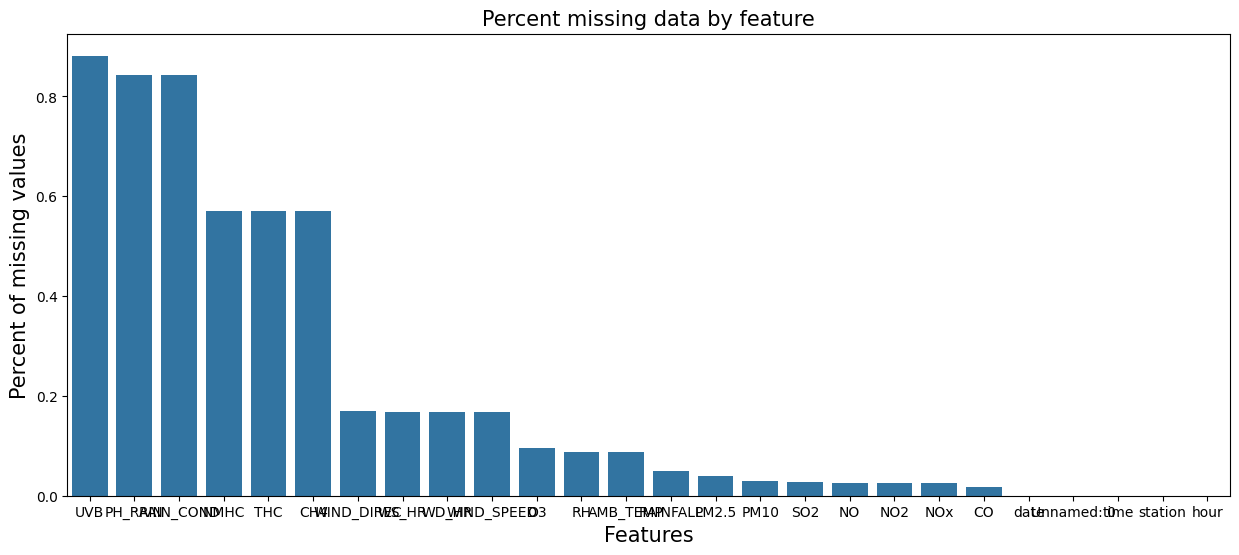

In [47]:
print(missing_rate(dataset))
display_missing_percent(dataset)

## Gom cụm theo từng khu vực

In [29]:
print(get_stat_by_station(dataset))

+-----+-----------+----------+-------------------------------+-------------------------------+
| No. |  station  | #Records |           From date           |            To date            |
+-----+-----------+----------+-------------------------------+-------------------------------+
|  1  |  Banqiao  |  8,760   | 2015-01-01T00:00:00.000000000 | 2015-12-31T23:00:00.000000000 |
|  1  |  Cailiao  |  8,736   | 2015-01-01T00:00:00.000000000 | 2015-12-31T23:00:00.000000000 |
|  1  |   Datong  |  8,760   | 2015-01-01T00:00:00.000000000 | 2015-12-31T23:00:00.000000000 |
|  1  |   Dayuan  |  8,760   | 2015-01-01T00:00:00.000000000 | 2015-12-31T23:00:00.000000000 |
|  1  |  Guanyin  |  8,760   | 2015-01-01T00:00:00.000000000 | 2015-12-31T23:00:00.000000000 |
|  1  |   Guting  |  8,760   | 2015-01-01T00:00:00.000000000 | 2015-12-31T23:00:00.000000000 |
|  1  |  Keelung  |  8,760   | 2015-01-01T00:00:00.000000000 | 2015-12-31T23:00:00.000000000 |
|  1  |   Linkou  |  8,688   | 2015-01-01T00:00:00

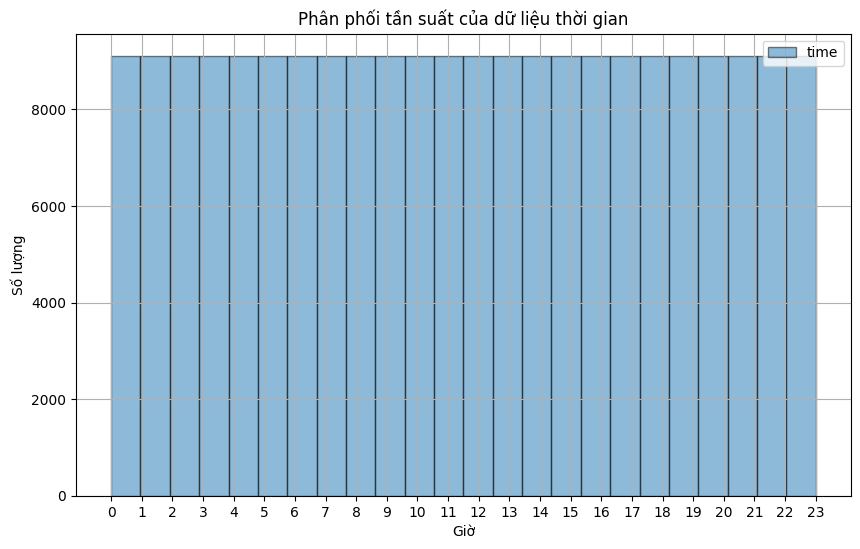

In [30]:
datasets=[(dataset,'time')]
timeGraph(datasets)

## Tính time step

In [31]:
find_time_steps(dataset)

The cycle duration appears to be approximately 3600.0 seconds.
The time cycle appears to be 24 hours.
Station Banqiao has no missing hours.
Station Cailiao is missing the following hours:
Date 2015-03-05 is missing hours: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
Station Datong has no missing hours.
Station Dayuan has no missing hours.
Station Guanyin has no missing hours.
Station Guting has no missing hours.
Station Keelung has no missing hours.
Station Linkou is missing the following hours:
Date 2015-01-10 is missing hours: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
Date 2015-05-17 is missing hours: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
Date 2015-05-16 is missing hours: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
Station Longtan is missing the following hours:
Date 2015-09-08 is missing hours: [0, 1, 2, 3,

## Dataset sau khi đã thực hiện tiền xử lý

In [32]:
pre_dataset=preprocess_taiwan2015(dataset)
print(pre_dataset)

Columns: Index(['Unnamed: 0', 'time', 'station', 'AMB_TEMP', 'CH4', 'CO', 'NMHC', 'NO',
       'NO2', 'NOx', 'O3', 'PH_RAIN', 'PM10', 'PM2.5', 'RAINFALL', 'RAIN_COND',
       'RH', 'SO2', 'THC', 'UVB', 'WD_HR', 'WIND_DIREC', 'WIND_SPEED', 'WS_HR',
       'date', 'hour'],
      dtype='object')
X shape:  (219000, 26)
          station        date                time  Unnamed: 0  AMB_TEMP  CH4  \
0         Banqiao  2015-01-01 2015-01-01 00:00:00         0.0      16.0  2.1   
1         Banqiao  2015-01-01 2015-01-01 01:00:00         1.0      16.0  2.1   
2         Banqiao  2015-01-01 2015-01-01 02:00:00         2.0      16.0  2.1   
3         Banqiao  2015-01-01 2015-01-01 03:00:00         3.0      15.0  2.0   
4         Banqiao  2015-01-01 2015-01-01 04:00:00         4.0      15.0  2.0   
...           ...         ...                 ...         ...       ...  ...   
218995  Zhongshan  2015-12-31 2015-12-31 19:00:00    218635.0      18.0  1.9   
218996  Zhongshan  2015-12-31 2015-12-31 20

In [46]:
print(missing_rate(pre_dataset))

21.1


In [33]:
find_time_steps(pre_dataset)

The cycle duration appears to be approximately 3600.0 seconds.
The time cycle appears to be 24 hours.
Station Banqiao has no missing hours.
Station Cailiao has no missing hours.
Station Datong has no missing hours.
Station Dayuan has no missing hours.
Station Guanyin has no missing hours.
Station Guting has no missing hours.
Station Keelung has no missing hours.
Station Linkou has no missing hours.
Station Longtan has no missing hours.
Station Pingzhen has no missing hours.
Station Sanchong has no missing hours.
Station Shilin has no missing hours.
Station Songshan has no missing hours.
Station Tamsui has no missing hours.
Station Taoyuan has no missing hours.
Station Tucheng has no missing hours.
Station Wanhua has no missing hours.
Station Wanli has no missing hours.
Station Xindian has no missing hours.
Station Xinzhuang has no missing hours.
Station Xizhi has no missing hours.
Station Yangming has no missing hours.
Station Yonghe has no missing hours.
Station Zhongli has no missing

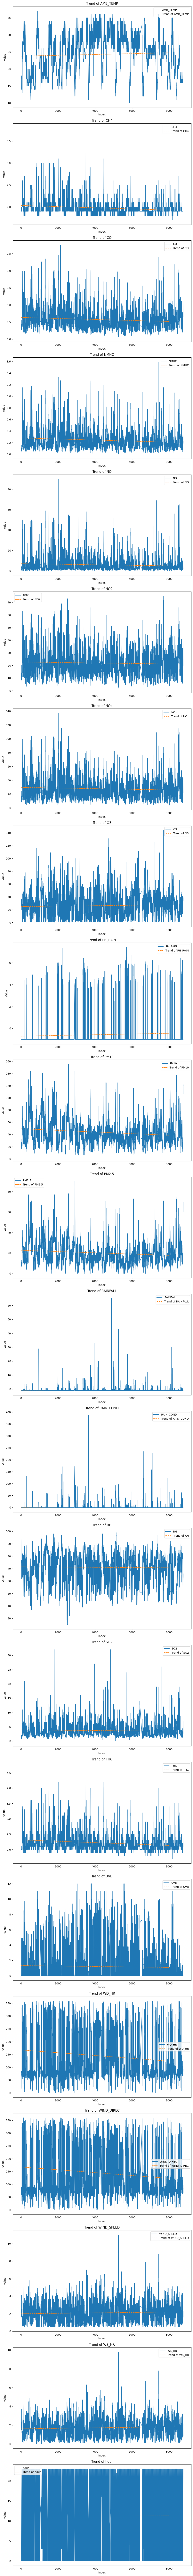

None


In [34]:
trend=calculate_trend(pre_dataset)
print(trend)

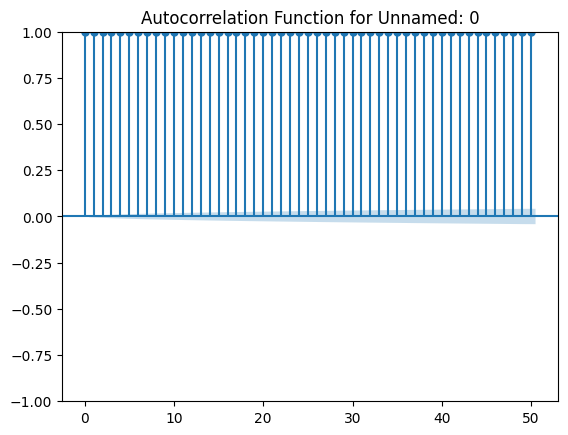

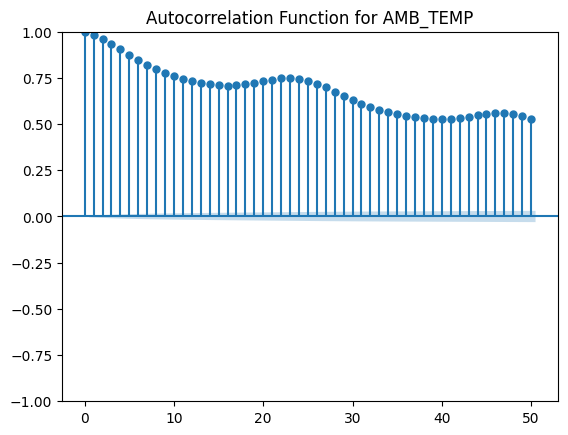

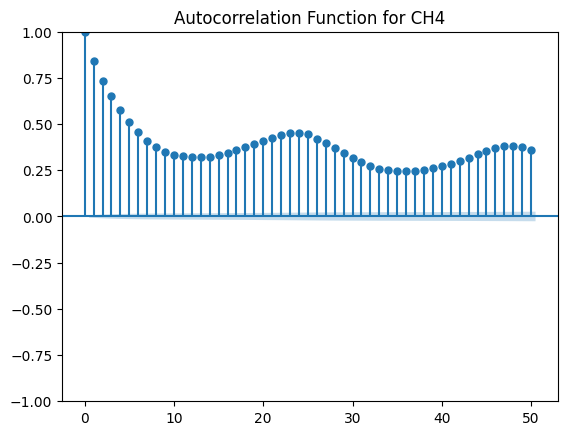

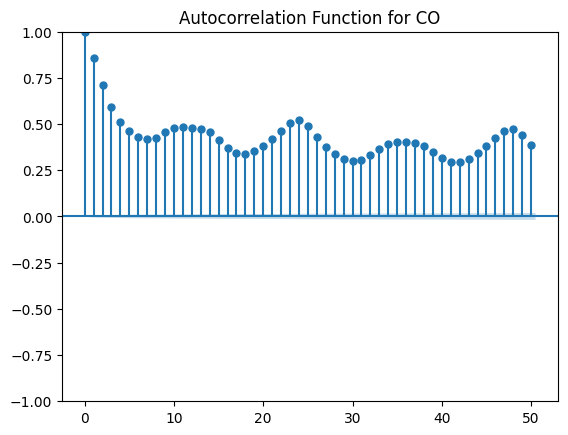

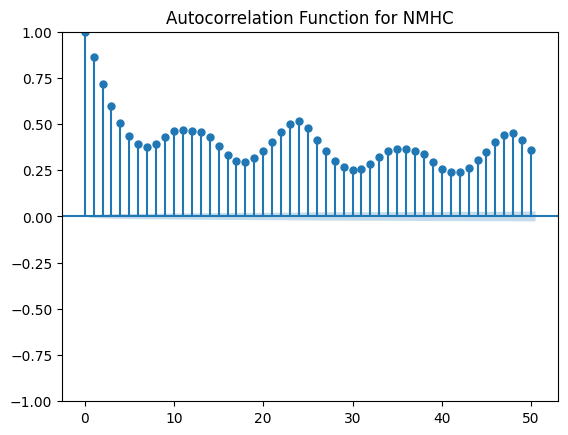

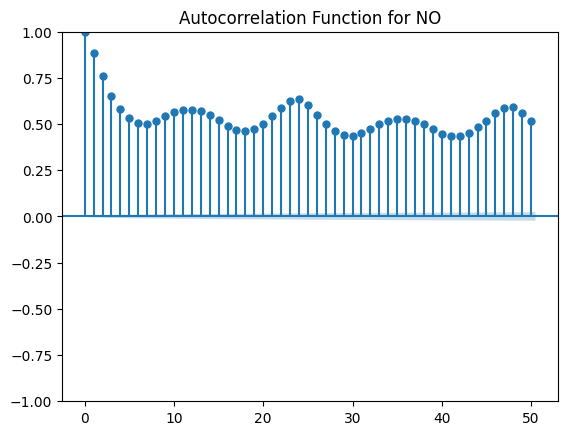

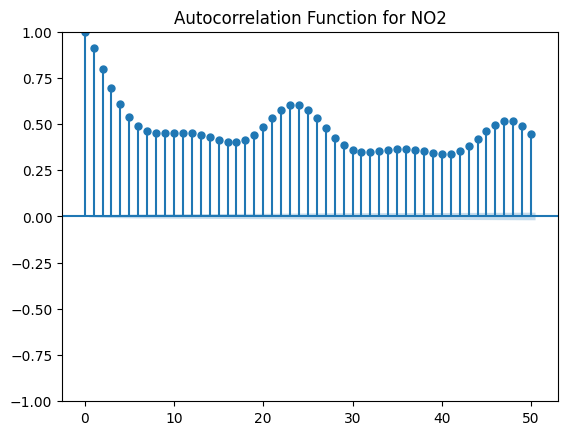

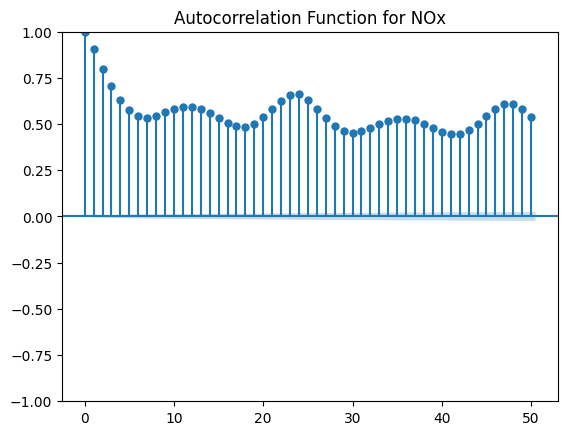

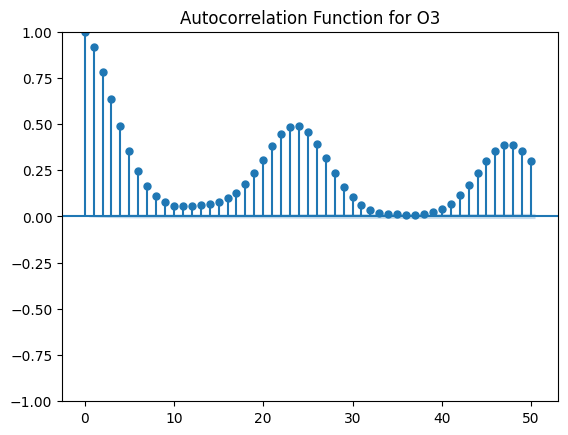

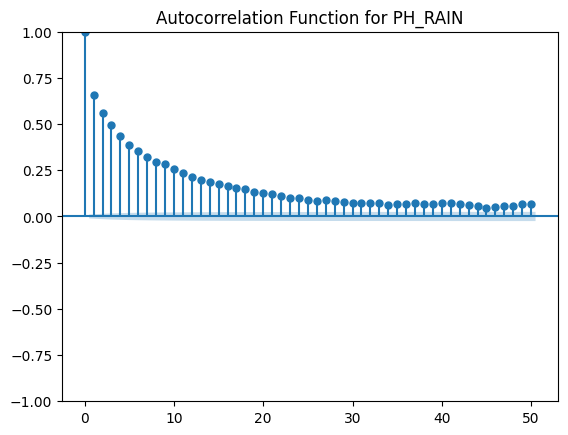

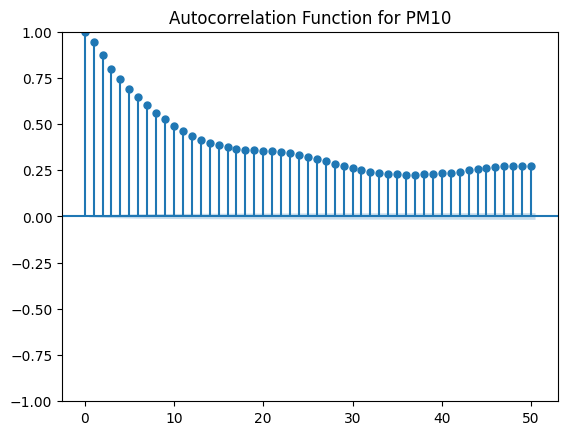

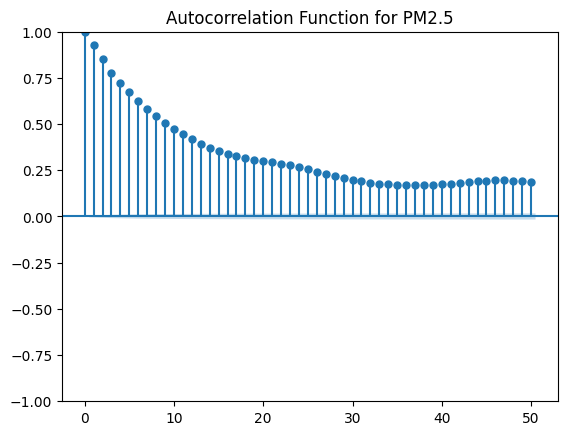

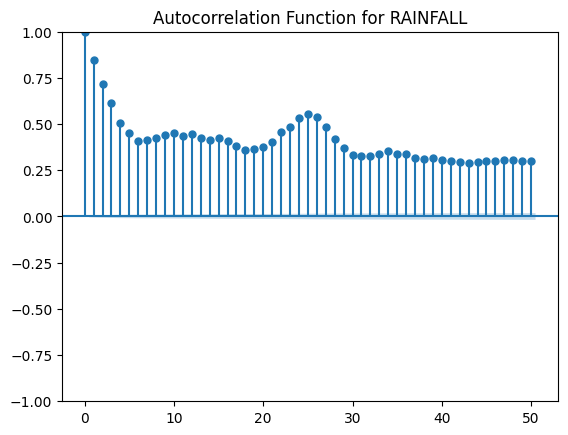

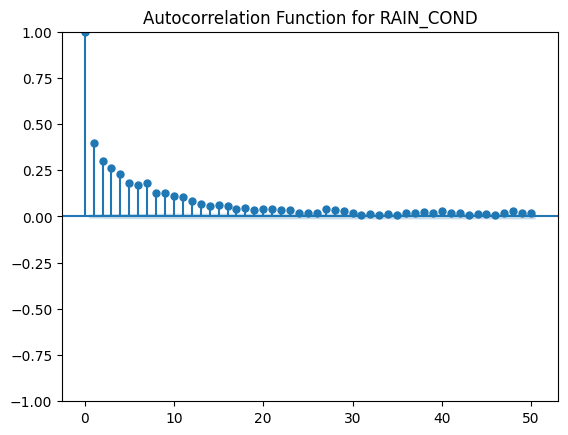

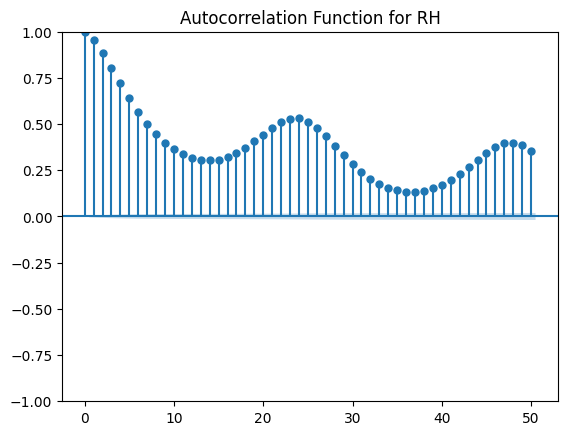

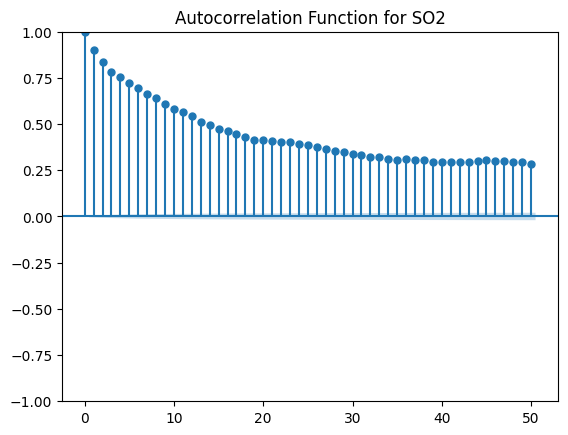

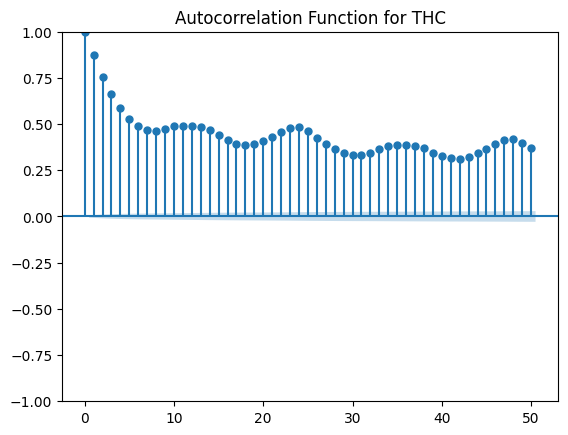

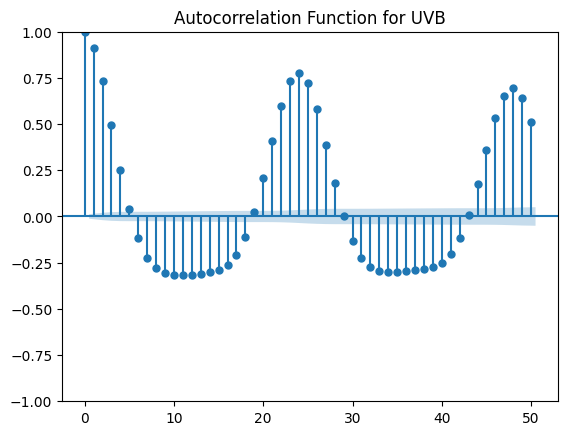

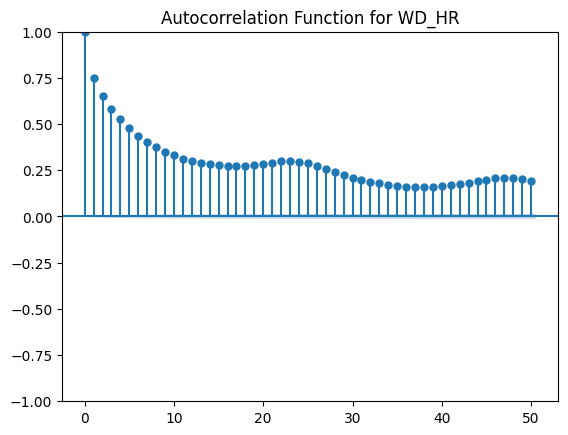

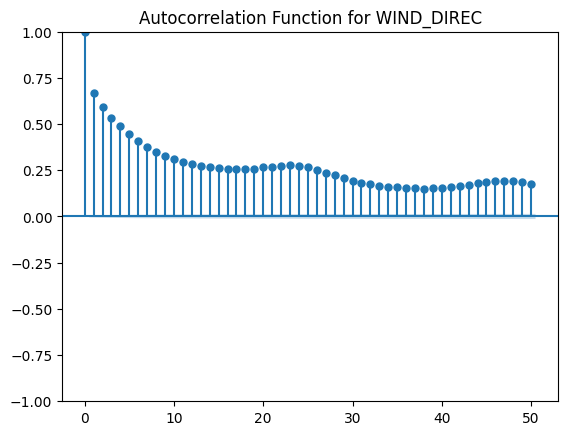

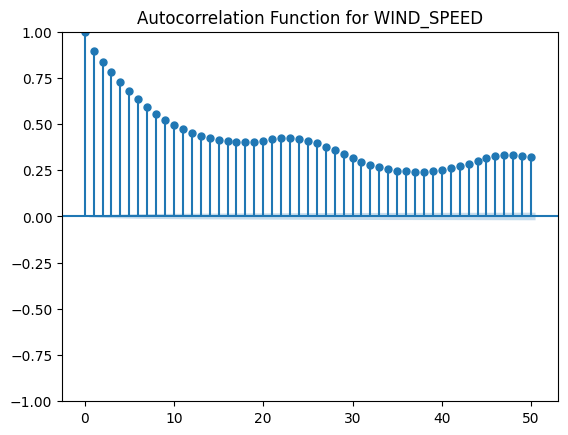

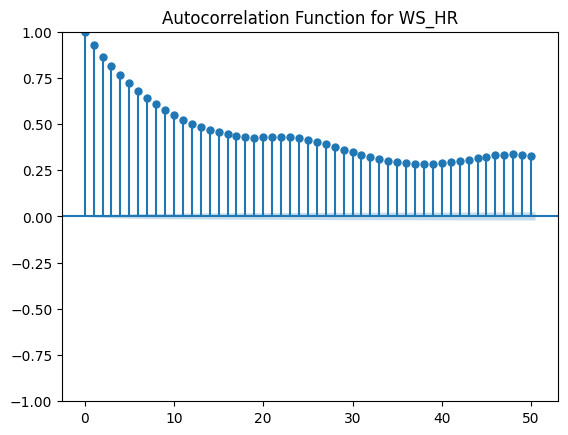

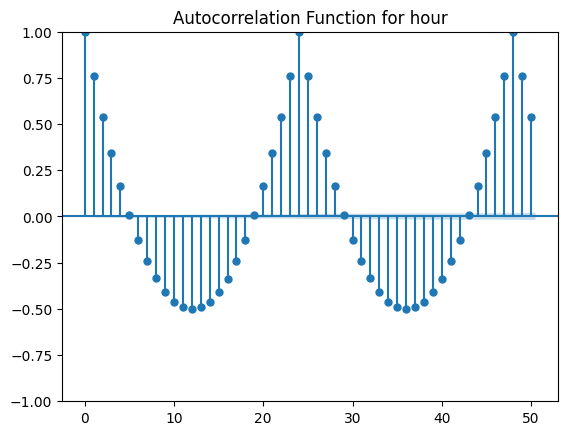

{'Unnamed: 0': 1,
 'AMB_TEMP': 1,
 'CH4': 1,
 'CO': 1,
 'NMHC': 1,
 'NO': 1,
 'NO2': 1,
 'NOx': 1,
 'O3': 1,
 'PH_RAIN': 1,
 'PM10': 1,
 'PM2.5': 1,
 'RAINFALL': 1,
 'RAIN_COND': 1,
 'RH': 1,
 'SO2': 1,
 'THC': 1,
 'UVB': 1,
 'WD_HR': 1,
 'WIND_DIREC': 1,
 'WIND_SPEED': 1,
 'WS_HR': 1,
 'hour': 24}

In [35]:
find_cycles_for_all_columns(pre_dataset)
# kết quả trả về cho thấy dữ liệu không có chu kỳ dài hạn rõ ràng trong phạm vi độ trễ được xem xét (ở đây là 50)

In [43]:
n_steps = 24
missing_rates = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
# missing_rates = [0.1, 0.2, 0.3,]
methods = ['median','mean','knn', 'mice','saits','mrnn' ]



In [50]:
df_mae, df_mse, df_rmse, df_running_time = run_experiment(dataset, missing_rates, methods)

Rate: 0.1 Method: median N: 0
Rate: 0.1 Method: median N: 1
Rate: 0.1 Method: median N: 2
Rate: 0.1 Method: median N: 3
Rate: 0.1 Method: median N: 4
Rate: 0.1 Method: median N: 5
Rate: 0.1 Method: median N: 6
Rate: 0.1 Method: median N: 7
Rate: 0.1 Method: median N: 8
Rate: 0.1 Method: median N: 9
Rate: 0.1 Method: mean N: 0
Rate: 0.1 Method: mean N: 1
Rate: 0.1 Method: mean N: 2
Rate: 0.1 Method: mean N: 3
Rate: 0.1 Method: mean N: 4
Rate: 0.1 Method: mean N: 5
Rate: 0.1 Method: mean N: 6
Rate: 0.1 Method: mean N: 7
Rate: 0.1 Method: mean N: 8
Rate: 0.1 Method: mean N: 9
Rate: 0.1 Method: knn N: 0
Rate: 0.1 Method: knn N: 1
Rate: 0.1 Method: knn N: 2
Rate: 0.1 Method: knn N: 3
Rate: 0.1 Method: knn N: 4
Rate: 0.1 Method: knn N: 5
Rate: 0.1 Method: knn N: 6
Rate: 0.1 Method: knn N: 7
Rate: 0.1 Method: knn N: 8
Rate: 0.1 Method: knn N: 9
Rate: 0.1 Method: mice N: 0
[IterativeImputer] Completing matrix with shape (219, 552)
[IterativeImputer] Change: 0.0, scaled tolerance: 0.03343571144

2024-05-22 08:18:15 [INFO]: Using the given device: cpu
2024-05-22 08:18:15 [INFO]: Model files will be saved to data_2/saits/20240522_T081815
2024-05-22 08:18:15 [INFO]: Tensorboard file will be saved to data_2/saits/20240522_T081815/tensorboard
2024-05-22 08:18:15 [INFO]: SAITS initialized with the given hyperparameters, the number of trainable parameters: 1,353,894


Rate: 0.1 Method: saits N: 0


2024-05-22 08:18:16 [INFO]: Epoch 001 - training loss: 1.3649, validation loss: 0.6876
2024-05-22 08:18:18 [INFO]: Epoch 002 - training loss: 1.0769, validation loss: 0.5258
2024-05-22 08:18:19 [INFO]: Epoch 003 - training loss: 0.9530, validation loss: 0.4807
2024-05-22 08:18:20 [INFO]: Epoch 004 - training loss: 0.8796, validation loss: 0.4048
2024-05-22 08:18:21 [INFO]: Epoch 005 - training loss: 0.8057, validation loss: 0.3605
2024-05-22 08:18:22 [INFO]: Epoch 006 - training loss: 0.7618, validation loss: 0.3429
2024-05-22 08:18:24 [INFO]: Epoch 007 - training loss: 0.7231, validation loss: 0.3163
2024-05-22 08:18:25 [INFO]: Epoch 008 - training loss: 0.6952, validation loss: 0.2975
2024-05-22 08:18:27 [INFO]: Epoch 009 - training loss: 0.6729, validation loss: 0.2794
2024-05-22 08:18:28 [INFO]: Epoch 010 - training loss: 0.6387, validation loss: 0.2777
2024-05-22 08:18:30 [INFO]: Epoch 011 - training loss: 0.6161, validation loss: 0.2620
2024-05-22 08:18:31 [INFO]: Epoch 012 - tra

Rate: 0.1 Method: saits N: 1


2024-05-22 08:18:44 [INFO]: Epoch 001 - training loss: 1.3916, validation loss: 0.6575
2024-05-22 08:18:45 [INFO]: Epoch 002 - training loss: 1.0975, validation loss: 0.5296
2024-05-22 08:18:47 [INFO]: Epoch 003 - training loss: 0.9630, validation loss: 0.4675
2024-05-22 08:18:48 [INFO]: Epoch 004 - training loss: 0.8859, validation loss: 0.4006
2024-05-22 08:18:49 [INFO]: Epoch 005 - training loss: 0.8218, validation loss: 0.3621
2024-05-22 08:18:50 [INFO]: Epoch 006 - training loss: 0.7710, validation loss: 0.3417
2024-05-22 08:18:51 [INFO]: Epoch 007 - training loss: 0.7276, validation loss: 0.3180
2024-05-22 08:18:53 [INFO]: Epoch 008 - training loss: 0.6935, validation loss: 0.3061
2024-05-22 08:18:54 [INFO]: Epoch 009 - training loss: 0.6629, validation loss: 0.2994
2024-05-22 08:18:55 [INFO]: Epoch 010 - training loss: 0.6406, validation loss: 0.2835
2024-05-22 08:18:57 [INFO]: Epoch 011 - training loss: 0.6165, validation loss: 0.2687
2024-05-22 08:18:58 [INFO]: Epoch 012 - tra

Rate: 0.1 Method: saits N: 2


2024-05-22 08:19:10 [INFO]: Epoch 001 - training loss: 1.4024, validation loss: 0.6013
2024-05-22 08:19:11 [INFO]: Epoch 002 - training loss: 1.1219, validation loss: 0.4744
2024-05-22 08:19:13 [INFO]: Epoch 003 - training loss: 0.9959, validation loss: 0.4112
2024-05-22 08:19:15 [INFO]: Epoch 004 - training loss: 0.9196, validation loss: 0.3401
2024-05-22 08:19:16 [INFO]: Epoch 005 - training loss: 0.8510, validation loss: 0.3039
2024-05-22 08:19:17 [INFO]: Epoch 006 - training loss: 0.7992, validation loss: 0.2794
2024-05-22 08:19:19 [INFO]: Epoch 007 - training loss: 0.7558, validation loss: 0.2520
2024-05-22 08:19:20 [INFO]: Epoch 008 - training loss: 0.7218, validation loss: 0.2376
2024-05-22 08:19:21 [INFO]: Epoch 009 - training loss: 0.6854, validation loss: 0.2236
2024-05-22 08:19:22 [INFO]: Epoch 010 - training loss: 0.6599, validation loss: 0.2085
2024-05-22 08:19:23 [INFO]: Epoch 011 - training loss: 0.6406, validation loss: 0.2030
2024-05-22 08:19:24 [INFO]: Epoch 012 - tra

Rate: 0.1 Method: saits N: 3


2024-05-22 08:19:37 [INFO]: Epoch 001 - training loss: 1.3763, validation loss: 0.4849
2024-05-22 08:19:38 [INFO]: Epoch 002 - training loss: 1.0989, validation loss: 0.4206
2024-05-22 08:19:39 [INFO]: Epoch 003 - training loss: 0.9779, validation loss: 0.3519
2024-05-22 08:19:41 [INFO]: Epoch 004 - training loss: 0.8990, validation loss: 0.2978
2024-05-22 08:19:43 [INFO]: Epoch 005 - training loss: 0.8345, validation loss: 0.2699
2024-05-22 08:19:45 [INFO]: Epoch 006 - training loss: 0.7807, validation loss: 0.2495
2024-05-22 08:19:46 [INFO]: Epoch 007 - training loss: 0.7479, validation loss: 0.2217
2024-05-22 08:19:47 [INFO]: Epoch 008 - training loss: 0.7157, validation loss: 0.2117
2024-05-22 08:19:48 [INFO]: Epoch 009 - training loss: 0.6797, validation loss: 0.1969
2024-05-22 08:19:49 [INFO]: Epoch 010 - training loss: 0.6541, validation loss: 0.1904
2024-05-22 08:19:50 [INFO]: Epoch 011 - training loss: 0.6369, validation loss: 0.1815
2024-05-22 08:19:51 [INFO]: Epoch 012 - tra

Rate: 0.1 Method: saits N: 4


2024-05-22 08:20:04 [INFO]: Epoch 001 - training loss: 1.4159, validation loss: 0.8499
2024-05-22 08:20:05 [INFO]: Epoch 002 - training loss: 1.1354, validation loss: 0.7240
2024-05-22 08:20:06 [INFO]: Epoch 003 - training loss: 0.9994, validation loss: 0.6551
2024-05-22 08:20:08 [INFO]: Epoch 004 - training loss: 0.9211, validation loss: 0.5988
2024-05-22 08:20:09 [INFO]: Epoch 005 - training loss: 0.8461, validation loss: 0.5557
2024-05-22 08:20:11 [INFO]: Epoch 006 - training loss: 0.8122, validation loss: 0.5317
2024-05-22 08:20:12 [INFO]: Epoch 007 - training loss: 0.7634, validation loss: 0.5069
2024-05-22 08:20:14 [INFO]: Epoch 008 - training loss: 0.7323, validation loss: 0.4896
2024-05-22 08:20:15 [INFO]: Epoch 009 - training loss: 0.7024, validation loss: 0.4958
2024-05-22 08:20:16 [INFO]: Epoch 010 - training loss: 0.6772, validation loss: 0.4730
2024-05-22 08:20:18 [INFO]: Epoch 011 - training loss: 0.6544, validation loss: 0.4649
2024-05-22 08:20:19 [INFO]: Epoch 012 - tra

Rate: 0.1 Method: saits N: 5


2024-05-22 08:20:31 [INFO]: Epoch 001 - training loss: 1.3878, validation loss: 0.6112
2024-05-22 08:20:33 [INFO]: Epoch 002 - training loss: 1.1145, validation loss: 0.5280
2024-05-22 08:20:34 [INFO]: Epoch 003 - training loss: 1.0074, validation loss: 0.4474
2024-05-22 08:20:35 [INFO]: Epoch 004 - training loss: 0.9191, validation loss: 0.3845
2024-05-22 08:20:36 [INFO]: Epoch 005 - training loss: 0.8492, validation loss: 0.3532
2024-05-22 08:20:37 [INFO]: Epoch 006 - training loss: 0.8077, validation loss: 0.3243
2024-05-22 08:20:38 [INFO]: Epoch 007 - training loss: 0.7708, validation loss: 0.3022
2024-05-22 08:20:40 [INFO]: Epoch 008 - training loss: 0.7308, validation loss: 0.2893
2024-05-22 08:20:42 [INFO]: Epoch 009 - training loss: 0.7034, validation loss: 0.2736
2024-05-22 08:20:44 [INFO]: Epoch 010 - training loss: 0.6821, validation loss: 0.2636
2024-05-22 08:20:45 [INFO]: Epoch 011 - training loss: 0.6497, validation loss: 0.2582
2024-05-22 08:20:46 [INFO]: Epoch 012 - tra

Rate: 0.1 Method: saits N: 6


2024-05-22 08:20:58 [INFO]: Epoch 001 - training loss: 1.3755, validation loss: 0.7170
2024-05-22 08:21:00 [INFO]: Epoch 002 - training loss: 1.1038, validation loss: 0.5338
2024-05-22 08:21:01 [INFO]: Epoch 003 - training loss: 0.9661, validation loss: 0.4673
2024-05-22 08:21:02 [INFO]: Epoch 004 - training loss: 0.8912, validation loss: 0.4260
2024-05-22 08:21:03 [INFO]: Epoch 005 - training loss: 0.8430, validation loss: 0.3972
2024-05-22 08:21:04 [INFO]: Epoch 006 - training loss: 0.7953, validation loss: 0.3673
2024-05-22 08:21:05 [INFO]: Epoch 007 - training loss: 0.7602, validation loss: 0.3511
2024-05-22 08:21:07 [INFO]: Epoch 008 - training loss: 0.7254, validation loss: 0.3409
2024-05-22 08:21:08 [INFO]: Epoch 009 - training loss: 0.6955, validation loss: 0.3240
2024-05-22 08:21:10 [INFO]: Epoch 010 - training loss: 0.6648, validation loss: 0.3189
2024-05-22 08:21:12 [INFO]: Epoch 011 - training loss: 0.6427, validation loss: 0.3118
2024-05-22 08:21:13 [INFO]: Epoch 012 - tra

Rate: 0.1 Method: saits N: 7


2024-05-22 08:21:25 [INFO]: Epoch 001 - training loss: 1.4086, validation loss: 0.9032
2024-05-22 08:21:27 [INFO]: Epoch 002 - training loss: 1.1273, validation loss: 0.8524
2024-05-22 08:21:28 [INFO]: Epoch 003 - training loss: 1.0209, validation loss: 0.7738
2024-05-22 08:21:29 [INFO]: Epoch 004 - training loss: 0.9362, validation loss: 0.7143
2024-05-22 08:21:30 [INFO]: Epoch 005 - training loss: 0.8757, validation loss: 0.6635
2024-05-22 08:21:32 [INFO]: Epoch 006 - training loss: 0.8276, validation loss: 0.6239
2024-05-22 08:21:33 [INFO]: Epoch 007 - training loss: 0.7809, validation loss: 0.6033
2024-05-22 08:21:34 [INFO]: Epoch 008 - training loss: 0.7505, validation loss: 0.5897
2024-05-22 08:21:35 [INFO]: Epoch 009 - training loss: 0.7225, validation loss: 0.5765
2024-05-22 08:21:36 [INFO]: Epoch 010 - training loss: 0.7003, validation loss: 0.5667
2024-05-22 08:21:38 [INFO]: Epoch 011 - training loss: 0.6838, validation loss: 0.5635
2024-05-22 08:21:40 [INFO]: Epoch 012 - tra

Rate: 0.1 Method: saits N: 8


2024-05-22 08:21:51 [INFO]: Epoch 001 - training loss: 1.3851, validation loss: 0.6088
2024-05-22 08:21:53 [INFO]: Epoch 002 - training loss: 1.1003, validation loss: 0.4544
2024-05-22 08:21:55 [INFO]: Epoch 003 - training loss: 0.9721, validation loss: 0.3859
2024-05-22 08:21:57 [INFO]: Epoch 004 - training loss: 0.8949, validation loss: 0.3436
2024-05-22 08:21:58 [INFO]: Epoch 005 - training loss: 0.8327, validation loss: 0.3072
2024-05-22 08:21:59 [INFO]: Epoch 006 - training loss: 0.7815, validation loss: 0.2778
2024-05-22 08:22:00 [INFO]: Epoch 007 - training loss: 0.7407, validation loss: 0.2595
2024-05-22 08:22:02 [INFO]: Epoch 008 - training loss: 0.7038, validation loss: 0.2477
2024-05-22 08:22:03 [INFO]: Epoch 009 - training loss: 0.6757, validation loss: 0.2318
2024-05-22 08:22:04 [INFO]: Epoch 010 - training loss: 0.6524, validation loss: 0.2188
2024-05-22 08:22:05 [INFO]: Epoch 011 - training loss: 0.6285, validation loss: 0.2145
2024-05-22 08:22:06 [INFO]: Epoch 012 - tra

Rate: 0.1 Method: saits N: 9


2024-05-22 08:22:19 [INFO]: Epoch 001 - training loss: 1.4211, validation loss: 0.6762
2024-05-22 08:22:20 [INFO]: Epoch 002 - training loss: 1.1320, validation loss: 0.5981
2024-05-22 08:22:21 [INFO]: Epoch 003 - training loss: 0.9916, validation loss: 0.5147
2024-05-22 08:22:23 [INFO]: Epoch 004 - training loss: 0.9160, validation loss: 0.4464
2024-05-22 08:22:25 [INFO]: Epoch 005 - training loss: 0.8509, validation loss: 0.3999
2024-05-22 08:22:27 [INFO]: Epoch 006 - training loss: 0.8043, validation loss: 0.3660
2024-05-22 08:22:28 [INFO]: Epoch 007 - training loss: 0.7583, validation loss: 0.3370
2024-05-22 08:22:29 [INFO]: Epoch 008 - training loss: 0.7227, validation loss: 0.3168
2024-05-22 08:22:30 [INFO]: Epoch 009 - training loss: 0.6865, validation loss: 0.3116
2024-05-22 08:22:32 [INFO]: Epoch 010 - training loss: 0.6612, validation loss: 0.2947
2024-05-22 08:22:33 [INFO]: Epoch 011 - training loss: 0.6286, validation loss: 0.2888
2024-05-22 08:22:34 [INFO]: Epoch 012 - tra

Rate: 0.1 Method: mrnn N: 0


2024-05-22 08:22:49 [INFO]: Epoch 001 - training loss: 2.0751, validation loss: 1.1277
2024-05-22 08:22:55 [INFO]: Epoch 002 - training loss: 1.9395, validation loss: 1.1122
2024-05-22 08:22:59 [INFO]: Epoch 003 - training loss: 1.8149, validation loss: 1.0973
2024-05-22 08:23:03 [INFO]: Epoch 004 - training loss: 1.6890, validation loss: 1.0827
2024-05-22 08:23:07 [INFO]: Epoch 005 - training loss: 1.5992, validation loss: 1.0684
2024-05-22 08:23:12 [INFO]: Epoch 006 - training loss: 1.5710, validation loss: 1.0545
2024-05-22 08:23:16 [INFO]: Epoch 007 - training loss: 1.4663, validation loss: 1.0412
2024-05-22 08:23:20 [INFO]: Epoch 008 - training loss: 1.4403, validation loss: 1.0277
2024-05-22 08:23:26 [INFO]: Epoch 009 - training loss: 1.3835, validation loss: 1.0139
2024-05-22 08:23:29 [INFO]: Epoch 010 - training loss: 1.3369, validation loss: 1.0003
2024-05-22 08:23:33 [INFO]: Epoch 011 - training loss: 1.3067, validation loss: 0.9872
2024-05-22 08:23:38 [INFO]: Epoch 012 - tra

Rate: 0.1 Method: mrnn N: 1


2024-05-22 08:24:18 [INFO]: Epoch 001 - training loss: 2.0387, validation loss: 1.4595
2024-05-22 08:24:23 [INFO]: Epoch 002 - training loss: 1.9151, validation loss: 1.4430
2024-05-22 08:24:28 [INFO]: Epoch 003 - training loss: 1.7896, validation loss: 1.4265
2024-05-22 08:24:32 [INFO]: Epoch 004 - training loss: 1.6642, validation loss: 1.4100
2024-05-22 08:24:35 [INFO]: Epoch 005 - training loss: 1.5797, validation loss: 1.3939
2024-05-22 08:24:41 [INFO]: Epoch 006 - training loss: 1.5058, validation loss: 1.3788
2024-05-22 08:24:45 [INFO]: Epoch 007 - training loss: 1.4404, validation loss: 1.3639
2024-05-22 08:24:49 [INFO]: Epoch 008 - training loss: 1.4123, validation loss: 1.3493
2024-05-22 08:24:54 [INFO]: Epoch 009 - training loss: 1.3453, validation loss: 1.3352
2024-05-22 08:24:58 [INFO]: Epoch 010 - training loss: 1.3190, validation loss: 1.3218
2024-05-22 08:25:02 [INFO]: Epoch 011 - training loss: 1.2916, validation loss: 1.3096
2024-05-22 08:25:06 [INFO]: Epoch 012 - tra

Rate: 0.1 Method: mrnn N: 2


2024-05-22 08:25:47 [INFO]: Epoch 001 - training loss: 2.0518, validation loss: 1.0818
2024-05-22 08:25:51 [INFO]: Epoch 002 - training loss: 1.9172, validation loss: 1.0649
2024-05-22 08:25:56 [INFO]: Epoch 003 - training loss: 1.7886, validation loss: 1.0481
2024-05-22 08:26:00 [INFO]: Epoch 004 - training loss: 1.6639, validation loss: 1.0316
2024-05-22 08:26:04 [INFO]: Epoch 005 - training loss: 1.5855, validation loss: 1.0152
2024-05-22 08:26:09 [INFO]: Epoch 006 - training loss: 1.5143, validation loss: 0.9991
2024-05-22 08:26:13 [INFO]: Epoch 007 - training loss: 1.4710, validation loss: 0.9833
2024-05-22 08:26:17 [INFO]: Epoch 008 - training loss: 1.4132, validation loss: 0.9679
2024-05-22 08:26:23 [INFO]: Epoch 009 - training loss: 1.3741, validation loss: 0.9527
2024-05-22 08:26:27 [INFO]: Epoch 010 - training loss: 1.3587, validation loss: 0.9381
2024-05-22 08:26:31 [INFO]: Epoch 011 - training loss: 1.3080, validation loss: 0.9241
2024-05-22 08:26:35 [INFO]: Epoch 012 - tra

Rate: 0.1 Method: mrnn N: 3


2024-05-22 08:27:16 [INFO]: Epoch 001 - training loss: 2.1158, validation loss: 1.1146
2024-05-22 08:27:21 [INFO]: Epoch 002 - training loss: 1.9475, validation loss: 1.0975
2024-05-22 08:27:25 [INFO]: Epoch 003 - training loss: 1.8131, validation loss: 1.0805
2024-05-22 08:27:29 [INFO]: Epoch 004 - training loss: 1.6752, validation loss: 1.0636
2024-05-22 08:27:34 [INFO]: Epoch 005 - training loss: 1.6032, validation loss: 1.0471
2024-05-22 08:27:39 [INFO]: Epoch 006 - training loss: 1.5349, validation loss: 1.0312
2024-05-22 08:27:43 [INFO]: Epoch 007 - training loss: 1.4684, validation loss: 1.0158
2024-05-22 08:27:47 [INFO]: Epoch 008 - training loss: 1.4335, validation loss: 1.0007
2024-05-22 08:27:52 [INFO]: Epoch 009 - training loss: 1.3794, validation loss: 0.9863
2024-05-22 08:27:56 [INFO]: Epoch 010 - training loss: 1.3502, validation loss: 0.9723
2024-05-22 08:28:00 [INFO]: Epoch 011 - training loss: 1.3157, validation loss: 0.9592
2024-05-22 08:28:04 [INFO]: Epoch 012 - tra

Rate: 0.1 Method: mrnn N: 4


2024-05-22 08:28:44 [INFO]: Epoch 001 - training loss: 2.0461, validation loss: 1.0666
2024-05-22 08:28:49 [INFO]: Epoch 002 - training loss: 1.9782, validation loss: 1.0507
2024-05-22 08:28:54 [INFO]: Epoch 003 - training loss: 1.8369, validation loss: 1.0351
2024-05-22 08:28:57 [INFO]: Epoch 004 - training loss: 1.6882, validation loss: 1.0195
2024-05-22 08:29:01 [INFO]: Epoch 005 - training loss: 1.5855, validation loss: 1.0038
2024-05-22 08:29:07 [INFO]: Epoch 006 - training loss: 1.5436, validation loss: 0.9881
2024-05-22 08:29:11 [INFO]: Epoch 007 - training loss: 1.4994, validation loss: 0.9732
2024-05-22 08:29:15 [INFO]: Epoch 008 - training loss: 1.4274, validation loss: 0.9584
2024-05-22 08:29:20 [INFO]: Epoch 009 - training loss: 1.3826, validation loss: 0.9442
2024-05-22 08:29:24 [INFO]: Epoch 010 - training loss: 1.3289, validation loss: 0.9307
2024-05-22 08:29:28 [INFO]: Epoch 011 - training loss: 1.3230, validation loss: 0.9180
2024-05-22 08:29:32 [INFO]: Epoch 012 - tra

Rate: 0.1 Method: mrnn N: 5


2024-05-22 08:30:13 [INFO]: Epoch 001 - training loss: 2.1168, validation loss: 1.0747
2024-05-22 08:30:17 [INFO]: Epoch 002 - training loss: 1.9972, validation loss: 1.0566
2024-05-22 08:30:22 [INFO]: Epoch 003 - training loss: 1.8462, validation loss: 1.0394
2024-05-22 08:30:26 [INFO]: Epoch 004 - training loss: 1.7080, validation loss: 1.0225
2024-05-22 08:30:30 [INFO]: Epoch 005 - training loss: 1.6004, validation loss: 1.0064
2024-05-22 08:30:35 [INFO]: Epoch 006 - training loss: 1.5561, validation loss: 0.9911
2024-05-22 08:30:39 [INFO]: Epoch 007 - training loss: 1.4787, validation loss: 0.9763
2024-05-22 08:30:43 [INFO]: Epoch 008 - training loss: 1.4416, validation loss: 0.9617
2024-05-22 08:30:48 [INFO]: Epoch 009 - training loss: 1.4076, validation loss: 0.9474
2024-05-22 08:30:53 [INFO]: Epoch 010 - training loss: 1.3648, validation loss: 0.9334
2024-05-22 08:30:56 [INFO]: Epoch 011 - training loss: 1.3217, validation loss: 0.9200
2024-05-22 08:31:00 [INFO]: Epoch 012 - tra

Rate: 0.1 Method: mrnn N: 6


2024-05-22 08:31:40 [INFO]: Epoch 001 - training loss: 2.0808, validation loss: 1.0876
2024-05-22 08:31:44 [INFO]: Epoch 002 - training loss: 1.9237, validation loss: 1.0701
2024-05-22 08:31:50 [INFO]: Epoch 003 - training loss: 1.8000, validation loss: 1.0527
2024-05-22 08:31:54 [INFO]: Epoch 004 - training loss: 1.7047, validation loss: 1.0353
2024-05-22 08:31:58 [INFO]: Epoch 005 - training loss: 1.6098, validation loss: 1.0185
2024-05-22 08:32:03 [INFO]: Epoch 006 - training loss: 1.5605, validation loss: 1.0026
2024-05-22 08:32:07 [INFO]: Epoch 007 - training loss: 1.4824, validation loss: 0.9871
2024-05-22 08:32:11 [INFO]: Epoch 008 - training loss: 1.4074, validation loss: 0.9718
2024-05-22 08:32:15 [INFO]: Epoch 009 - training loss: 1.3685, validation loss: 0.9565
2024-05-22 08:32:20 [INFO]: Epoch 010 - training loss: 1.3442, validation loss: 0.9415
2024-05-22 08:32:24 [INFO]: Epoch 011 - training loss: 1.2950, validation loss: 0.9272
2024-05-22 08:32:28 [INFO]: Epoch 012 - tra

Rate: 0.1 Method: mrnn N: 7


2024-05-22 08:33:09 [INFO]: Epoch 001 - training loss: 2.0781, validation loss: 1.3452
2024-05-22 08:33:13 [INFO]: Epoch 002 - training loss: 1.9908, validation loss: 1.3296
2024-05-22 08:33:18 [INFO]: Epoch 003 - training loss: 1.8261, validation loss: 1.3145
2024-05-22 08:33:22 [INFO]: Epoch 004 - training loss: 1.7208, validation loss: 1.2994
2024-05-22 08:33:26 [INFO]: Epoch 005 - training loss: 1.6029, validation loss: 1.2846
2024-05-22 08:33:31 [INFO]: Epoch 006 - training loss: 1.5507, validation loss: 1.2698
2024-05-22 08:33:36 [INFO]: Epoch 007 - training loss: 1.4820, validation loss: 1.2555
2024-05-22 08:33:39 [INFO]: Epoch 008 - training loss: 1.4602, validation loss: 1.2415
2024-05-22 08:33:44 [INFO]: Epoch 009 - training loss: 1.3881, validation loss: 1.2279
2024-05-22 08:33:49 [INFO]: Epoch 010 - training loss: 1.3660, validation loss: 1.2147
2024-05-22 08:33:53 [INFO]: Epoch 011 - training loss: 1.3183, validation loss: 1.2026
2024-05-22 08:33:57 [INFO]: Epoch 012 - tra

Rate: 0.1 Method: mrnn N: 8


2024-05-22 08:34:38 [INFO]: Epoch 001 - training loss: 2.0773, validation loss: 1.1078
2024-05-22 08:34:43 [INFO]: Epoch 002 - training loss: 1.9224, validation loss: 1.0912
2024-05-22 08:34:52 [INFO]: Epoch 003 - training loss: 1.7809, validation loss: 1.0750
2024-05-22 08:34:56 [INFO]: Epoch 004 - training loss: 1.6581, validation loss: 1.0594
2024-05-22 08:35:00 [INFO]: Epoch 005 - training loss: 1.5898, validation loss: 1.0441
2024-05-22 08:35:05 [INFO]: Epoch 006 - training loss: 1.5367, validation loss: 1.0294
2024-05-22 08:35:09 [INFO]: Epoch 007 - training loss: 1.4588, validation loss: 1.0151
2024-05-22 08:35:13 [INFO]: Epoch 008 - training loss: 1.4104, validation loss: 1.0013
2024-05-22 08:35:18 [INFO]: Epoch 009 - training loss: 1.3950, validation loss: 0.9876
2024-05-22 08:35:23 [INFO]: Epoch 010 - training loss: 1.3255, validation loss: 0.9741
2024-05-22 08:35:27 [INFO]: Epoch 011 - training loss: 1.3023, validation loss: 0.9612
2024-05-22 08:35:31 [INFO]: Epoch 012 - tra

Rate: 0.1 Method: mrnn N: 9


2024-05-22 08:36:12 [INFO]: Epoch 001 - training loss: 2.0279, validation loss: 1.1372
2024-05-22 08:36:15 [INFO]: Epoch 002 - training loss: 1.8932, validation loss: 1.1195
2024-05-22 08:36:21 [INFO]: Epoch 003 - training loss: 1.7614, validation loss: 1.1020
2024-05-22 08:36:25 [INFO]: Epoch 004 - training loss: 1.6208, validation loss: 1.0849
2024-05-22 08:36:29 [INFO]: Epoch 005 - training loss: 1.6015, validation loss: 1.0679
2024-05-22 08:36:34 [INFO]: Epoch 006 - training loss: 1.4832, validation loss: 1.0513
2024-05-22 08:36:38 [INFO]: Epoch 007 - training loss: 1.4180, validation loss: 1.0353
2024-05-22 08:36:42 [INFO]: Epoch 008 - training loss: 1.4003, validation loss: 1.0197
2024-05-22 08:36:46 [INFO]: Epoch 009 - training loss: 1.3448, validation loss: 1.0047
2024-05-22 08:36:51 [INFO]: Epoch 010 - training loss: 1.3082, validation loss: 0.9904
2024-05-22 08:36:55 [INFO]: Epoch 011 - training loss: 1.2613, validation loss: 0.9769
2024-05-22 08:36:59 [INFO]: Epoch 012 - tra

Rate: 0.2 Method: median N: 0
Rate: 0.2 Method: median N: 1
Rate: 0.2 Method: median N: 2
Rate: 0.2 Method: median N: 3
Rate: 0.2 Method: median N: 4
Rate: 0.2 Method: median N: 5
Rate: 0.2 Method: median N: 6
Rate: 0.2 Method: median N: 7
Rate: 0.2 Method: median N: 8
Rate: 0.2 Method: median N: 9
Rate: 0.2 Method: mean N: 0
Rate: 0.2 Method: mean N: 1
Rate: 0.2 Method: mean N: 2
Rate: 0.2 Method: mean N: 3
Rate: 0.2 Method: mean N: 4
Rate: 0.2 Method: mean N: 5
Rate: 0.2 Method: mean N: 6
Rate: 0.2 Method: mean N: 7
Rate: 0.2 Method: mean N: 8
Rate: 0.2 Method: mean N: 9
Rate: 0.2 Method: knn N: 0
Rate: 0.2 Method: knn N: 1
Rate: 0.2 Method: knn N: 2
Rate: 0.2 Method: knn N: 3
Rate: 0.2 Method: knn N: 4
Rate: 0.2 Method: knn N: 5
Rate: 0.2 Method: knn N: 6
Rate: 0.2 Method: knn N: 7
Rate: 0.2 Method: knn N: 8
Rate: 0.2 Method: knn N: 9
Rate: 0.2 Method: mice N: 0
[IterativeImputer] Completing matrix with shape (219, 552)
[IterativeImputer] Change: 0.0, scaled tolerance: 0.03343571144

2024-05-22 08:47:52 [INFO]: Using the given device: cpu
2024-05-22 08:47:52 [INFO]: Model files will be saved to data_2/saits/20240522_T084752
2024-05-22 08:47:52 [INFO]: Tensorboard file will be saved to data_2/saits/20240522_T084752/tensorboard
2024-05-22 08:47:52 [INFO]: SAITS initialized with the given hyperparameters, the number of trainable parameters: 1,353,894


Rate: 0.2 Method: saits N: 0


2024-05-22 08:47:53 [INFO]: Epoch 001 - training loss: 1.3795, validation loss: 0.6555
2024-05-22 08:47:54 [INFO]: Epoch 002 - training loss: 1.1141, validation loss: 0.6010
2024-05-22 08:47:56 [INFO]: Epoch 003 - training loss: 0.9927, validation loss: 0.5208
2024-05-22 08:47:58 [INFO]: Epoch 004 - training loss: 0.9079, validation loss: 0.4521
2024-05-22 08:47:59 [INFO]: Epoch 005 - training loss: 0.8443, validation loss: 0.3978
2024-05-22 08:48:00 [INFO]: Epoch 006 - training loss: 0.7894, validation loss: 0.3663
2024-05-22 08:48:02 [INFO]: Epoch 007 - training loss: 0.7486, validation loss: 0.3566
2024-05-22 08:48:03 [INFO]: Epoch 008 - training loss: 0.7208, validation loss: 0.3358
2024-05-22 08:48:04 [INFO]: Epoch 009 - training loss: 0.6803, validation loss: 0.3254
2024-05-22 08:48:05 [INFO]: Epoch 010 - training loss: 0.6600, validation loss: 0.3172
2024-05-22 08:48:06 [INFO]: Epoch 011 - training loss: 0.6423, validation loss: 0.3066
2024-05-22 08:48:07 [INFO]: Epoch 012 - tra

Rate: 0.2 Method: saits N: 1


2024-05-22 08:48:20 [INFO]: Epoch 001 - training loss: 1.3758, validation loss: 0.6492
2024-05-22 08:48:21 [INFO]: Epoch 002 - training loss: 1.1157, validation loss: 0.5564
2024-05-22 08:48:23 [INFO]: Epoch 003 - training loss: 1.0030, validation loss: 0.4792
2024-05-22 08:48:25 [INFO]: Epoch 004 - training loss: 0.9172, validation loss: 0.4163
2024-05-22 08:48:27 [INFO]: Epoch 005 - training loss: 0.8512, validation loss: 0.3621
2024-05-22 08:48:28 [INFO]: Epoch 006 - training loss: 0.8048, validation loss: 0.3348
2024-05-22 08:48:29 [INFO]: Epoch 007 - training loss: 0.7592, validation loss: 0.3122
2024-05-22 08:48:30 [INFO]: Epoch 008 - training loss: 0.7325, validation loss: 0.2860
2024-05-22 08:48:32 [INFO]: Epoch 009 - training loss: 0.6921, validation loss: 0.2672
2024-05-22 08:48:33 [INFO]: Epoch 010 - training loss: 0.6576, validation loss: 0.2591
2024-05-22 08:48:34 [INFO]: Epoch 011 - training loss: 0.6334, validation loss: 0.2431
2024-05-22 08:48:35 [INFO]: Epoch 012 - tra

Rate: 0.2 Method: saits N: 2


2024-05-22 08:48:48 [INFO]: Epoch 001 - training loss: 1.3927, validation loss: 0.8043
2024-05-22 08:48:49 [INFO]: Epoch 002 - training loss: 1.1366, validation loss: 0.6489
2024-05-22 08:48:50 [INFO]: Epoch 003 - training loss: 1.0152, validation loss: 0.5938
2024-05-22 08:48:51 [INFO]: Epoch 004 - training loss: 0.9405, validation loss: 0.5352
2024-05-22 08:48:53 [INFO]: Epoch 005 - training loss: 0.8788, validation loss: 0.5073
2024-05-22 08:48:55 [INFO]: Epoch 006 - training loss: 0.8294, validation loss: 0.4746
2024-05-22 08:48:57 [INFO]: Epoch 007 - training loss: 0.7942, validation loss: 0.4505
2024-05-22 08:48:58 [INFO]: Epoch 008 - training loss: 0.7518, validation loss: 0.4346
2024-05-22 08:48:59 [INFO]: Epoch 009 - training loss: 0.7199, validation loss: 0.4165
2024-05-22 08:49:00 [INFO]: Epoch 010 - training loss: 0.6945, validation loss: 0.4133
2024-05-22 08:49:02 [INFO]: Epoch 011 - training loss: 0.6695, validation loss: 0.3993
2024-05-22 08:49:03 [INFO]: Epoch 012 - tra

Rate: 0.2 Method: saits N: 3


2024-05-22 08:49:15 [INFO]: Epoch 001 - training loss: 1.4026, validation loss: 0.8715
2024-05-22 08:49:17 [INFO]: Epoch 002 - training loss: 1.1113, validation loss: 0.7022
2024-05-22 08:49:18 [INFO]: Epoch 003 - training loss: 0.9845, validation loss: 0.6391
2024-05-22 08:49:19 [INFO]: Epoch 004 - training loss: 0.9033, validation loss: 0.5941
2024-05-22 08:49:20 [INFO]: Epoch 005 - training loss: 0.8442, validation loss: 0.5722
2024-05-22 08:49:22 [INFO]: Epoch 006 - training loss: 0.7888, validation loss: 0.5388
2024-05-22 08:49:24 [INFO]: Epoch 007 - training loss: 0.7473, validation loss: 0.5207
2024-05-22 08:49:26 [INFO]: Epoch 008 - training loss: 0.7172, validation loss: 0.5081
2024-05-22 08:49:27 [INFO]: Epoch 009 - training loss: 0.6897, validation loss: 0.4969
2024-05-22 08:49:28 [INFO]: Epoch 010 - training loss: 0.6732, validation loss: 0.4838
2024-05-22 08:49:29 [INFO]: Epoch 011 - training loss: 0.6502, validation loss: 0.4713
2024-05-22 08:49:30 [INFO]: Epoch 012 - tra

Rate: 0.2 Method: saits N: 4


2024-05-22 08:49:43 [INFO]: Epoch 001 - training loss: 1.3700, validation loss: 0.6445
2024-05-22 08:49:44 [INFO]: Epoch 002 - training loss: 1.0753, validation loss: 0.5711
2024-05-22 08:49:46 [INFO]: Epoch 003 - training loss: 0.9623, validation loss: 0.5222
2024-05-22 08:49:47 [INFO]: Epoch 004 - training loss: 0.8899, validation loss: 0.4492
2024-05-22 08:49:48 [INFO]: Epoch 005 - training loss: 0.8401, validation loss: 0.4213
2024-05-22 08:49:49 [INFO]: Epoch 006 - training loss: 0.7976, validation loss: 0.3998
2024-05-22 08:49:51 [INFO]: Epoch 007 - training loss: 0.7528, validation loss: 0.3720
2024-05-22 08:49:53 [INFO]: Epoch 008 - training loss: 0.7211, validation loss: 0.3572
2024-05-22 08:49:54 [INFO]: Epoch 009 - training loss: 0.6927, validation loss: 0.3489
2024-05-22 08:49:56 [INFO]: Epoch 010 - training loss: 0.6626, validation loss: 0.3395
2024-05-22 08:49:57 [INFO]: Epoch 011 - training loss: 0.6366, validation loss: 0.3229
2024-05-22 08:49:58 [INFO]: Epoch 012 - tra

Rate: 0.2 Method: saits N: 5


2024-05-22 08:50:11 [INFO]: Epoch 001 - training loss: 1.4047, validation loss: 0.8205
2024-05-22 08:50:12 [INFO]: Epoch 002 - training loss: 1.1378, validation loss: 0.7300
2024-05-22 08:50:13 [INFO]: Epoch 003 - training loss: 1.0015, validation loss: 0.6285
2024-05-22 08:50:15 [INFO]: Epoch 004 - training loss: 0.9188, validation loss: 0.5655
2024-05-22 08:50:16 [INFO]: Epoch 005 - training loss: 0.8456, validation loss: 0.5291
2024-05-22 08:50:17 [INFO]: Epoch 006 - training loss: 0.7900, validation loss: 0.4840
2024-05-22 08:50:18 [INFO]: Epoch 007 - training loss: 0.7507, validation loss: 0.4701
2024-05-22 08:50:20 [INFO]: Epoch 008 - training loss: 0.7150, validation loss: 0.4490
2024-05-22 08:50:22 [INFO]: Epoch 009 - training loss: 0.6882, validation loss: 0.4450
2024-05-22 08:50:24 [INFO]: Epoch 010 - training loss: 0.6637, validation loss: 0.4332
2024-05-22 08:50:25 [INFO]: Epoch 011 - training loss: 0.6390, validation loss: 0.4225
2024-05-22 08:50:26 [INFO]: Epoch 012 - tra

Rate: 0.2 Method: saits N: 6


2024-05-22 08:50:39 [INFO]: Epoch 001 - training loss: 1.3268, validation loss: 0.6039
2024-05-22 08:50:40 [INFO]: Epoch 002 - training loss: 1.0598, validation loss: 0.5060
2024-05-22 08:50:42 [INFO]: Epoch 003 - training loss: 0.9420, validation loss: 0.4118
2024-05-22 08:50:43 [INFO]: Epoch 004 - training loss: 0.8611, validation loss: 0.3541
2024-05-22 08:50:44 [INFO]: Epoch 005 - training loss: 0.8059, validation loss: 0.3375
2024-05-22 08:50:45 [INFO]: Epoch 006 - training loss: 0.7655, validation loss: 0.3046
2024-05-22 08:50:47 [INFO]: Epoch 007 - training loss: 0.7194, validation loss: 0.2949
2024-05-22 08:50:48 [INFO]: Epoch 008 - training loss: 0.6867, validation loss: 0.2833
2024-05-22 08:50:49 [INFO]: Epoch 009 - training loss: 0.6637, validation loss: 0.2614
2024-05-22 08:50:51 [INFO]: Epoch 010 - training loss: 0.6337, validation loss: 0.2561
2024-05-22 08:50:52 [INFO]: Epoch 011 - training loss: 0.6178, validation loss: 0.2442
2024-05-22 08:50:54 [INFO]: Epoch 012 - tra

Rate: 0.2 Method: saits N: 7


2024-05-22 08:51:06 [INFO]: Epoch 001 - training loss: 1.3724, validation loss: 0.7397
2024-05-22 08:51:08 [INFO]: Epoch 002 - training loss: 1.0974, validation loss: 0.6191
2024-05-22 08:51:09 [INFO]: Epoch 003 - training loss: 0.9694, validation loss: 0.5117
2024-05-22 08:51:10 [INFO]: Epoch 004 - training loss: 0.8892, validation loss: 0.4701
2024-05-22 08:51:12 [INFO]: Epoch 005 - training loss: 0.8290, validation loss: 0.4417
2024-05-22 08:51:13 [INFO]: Epoch 006 - training loss: 0.7798, validation loss: 0.4185
2024-05-22 08:51:14 [INFO]: Epoch 007 - training loss: 0.7399, validation loss: 0.3931
2024-05-22 08:51:15 [INFO]: Epoch 008 - training loss: 0.7101, validation loss: 0.3808
2024-05-22 08:51:17 [INFO]: Epoch 009 - training loss: 0.6790, validation loss: 0.3702
2024-05-22 08:51:18 [INFO]: Epoch 010 - training loss: 0.6603, validation loss: 0.3591
2024-05-22 08:51:19 [INFO]: Epoch 011 - training loss: 0.6364, validation loss: 0.3489
2024-05-22 08:51:21 [INFO]: Epoch 012 - tra

Rate: 0.2 Method: saits N: 8


2024-05-22 08:51:33 [INFO]: Epoch 001 - training loss: 1.3718, validation loss: 0.6545
2024-05-22 08:51:34 [INFO]: Epoch 002 - training loss: 1.1151, validation loss: 0.5551
2024-05-22 08:51:36 [INFO]: Epoch 003 - training loss: 0.9818, validation loss: 0.4457
2024-05-22 08:51:38 [INFO]: Epoch 004 - training loss: 0.8981, validation loss: 0.3923
2024-05-22 08:51:39 [INFO]: Epoch 005 - training loss: 0.8345, validation loss: 0.3517
2024-05-22 08:51:41 [INFO]: Epoch 006 - training loss: 0.7833, validation loss: 0.3202
2024-05-22 08:51:42 [INFO]: Epoch 007 - training loss: 0.7457, validation loss: 0.2999
2024-05-22 08:51:43 [INFO]: Epoch 008 - training loss: 0.7070, validation loss: 0.2776
2024-05-22 08:51:44 [INFO]: Epoch 009 - training loss: 0.6831, validation loss: 0.2660
2024-05-22 08:51:46 [INFO]: Epoch 010 - training loss: 0.6683, validation loss: 0.2530
2024-05-22 08:51:47 [INFO]: Epoch 011 - training loss: 0.6361, validation loss: 0.2434
2024-05-22 08:51:48 [INFO]: Epoch 012 - tra

Rate: 0.2 Method: saits N: 9


2024-05-22 08:52:01 [INFO]: Epoch 001 - training loss: 1.3555, validation loss: 0.6900
2024-05-22 08:52:02 [INFO]: Epoch 002 - training loss: 1.0784, validation loss: 0.5776
2024-05-22 08:52:03 [INFO]: Epoch 003 - training loss: 0.9424, validation loss: 0.4928
2024-05-22 08:52:05 [INFO]: Epoch 004 - training loss: 0.8743, validation loss: 0.4498
2024-05-22 08:52:06 [INFO]: Epoch 005 - training loss: 0.8153, validation loss: 0.4013
2024-05-22 08:52:08 [INFO]: Epoch 006 - training loss: 0.7682, validation loss: 0.3969
2024-05-22 08:52:10 [INFO]: Epoch 007 - training loss: 0.7243, validation loss: 0.3529
2024-05-22 08:52:11 [INFO]: Epoch 008 - training loss: 0.7000, validation loss: 0.3384
2024-05-22 08:52:12 [INFO]: Epoch 009 - training loss: 0.6698, validation loss: 0.3192
2024-05-22 08:52:13 [INFO]: Epoch 010 - training loss: 0.6409, validation loss: 0.3106
2024-05-22 08:52:14 [INFO]: Epoch 011 - training loss: 0.6182, validation loss: 0.2990
2024-05-22 08:52:15 [INFO]: Epoch 012 - tra

Rate: 0.2 Method: mrnn N: 0


2024-05-22 08:52:31 [INFO]: Epoch 001 - training loss: 2.0294, validation loss: 1.2505
2024-05-22 08:52:36 [INFO]: Epoch 002 - training loss: 1.9208, validation loss: 1.2335
2024-05-22 08:52:41 [INFO]: Epoch 003 - training loss: 1.7882, validation loss: 1.2166
2024-05-22 08:52:45 [INFO]: Epoch 004 - training loss: 1.6601, validation loss: 1.2001
2024-05-22 08:52:49 [INFO]: Epoch 005 - training loss: 1.5847, validation loss: 1.1842
2024-05-22 08:52:54 [INFO]: Epoch 006 - training loss: 1.4978, validation loss: 1.1687
2024-05-22 08:52:58 [INFO]: Epoch 007 - training loss: 1.4455, validation loss: 1.1534
2024-05-22 08:53:02 [INFO]: Epoch 008 - training loss: 1.4239, validation loss: 1.1385
2024-05-22 08:53:07 [INFO]: Epoch 009 - training loss: 1.3600, validation loss: 1.1238
2024-05-22 08:53:11 [INFO]: Epoch 010 - training loss: 1.3384, validation loss: 1.1096
2024-05-22 08:53:15 [INFO]: Epoch 011 - training loss: 1.3064, validation loss: 1.0964
2024-05-22 08:53:20 [INFO]: Epoch 012 - tra

Rate: 0.2 Method: mrnn N: 1


2024-05-22 08:54:00 [INFO]: Epoch 001 - training loss: 2.1183, validation loss: 1.2664
2024-05-22 08:54:05 [INFO]: Epoch 002 - training loss: 1.9963, validation loss: 1.2511
2024-05-22 08:54:10 [INFO]: Epoch 003 - training loss: 1.8887, validation loss: 1.2354
2024-05-22 08:54:14 [INFO]: Epoch 004 - training loss: 1.7237, validation loss: 1.2204
2024-05-22 08:54:17 [INFO]: Epoch 005 - training loss: 1.6261, validation loss: 1.2050
2024-05-22 08:54:23 [INFO]: Epoch 006 - training loss: 1.5518, validation loss: 1.1907
2024-05-22 08:54:27 [INFO]: Epoch 007 - training loss: 1.5103, validation loss: 1.1765
2024-05-22 08:54:31 [INFO]: Epoch 008 - training loss: 1.4403, validation loss: 1.1626
2024-05-22 08:54:36 [INFO]: Epoch 009 - training loss: 1.3967, validation loss: 1.1489
2024-05-22 08:54:40 [INFO]: Epoch 010 - training loss: 1.3685, validation loss: 1.1356
2024-05-22 08:54:44 [INFO]: Epoch 011 - training loss: 1.3437, validation loss: 1.1232
2024-05-22 08:54:48 [INFO]: Epoch 012 - tra

Rate: 0.2 Method: mrnn N: 2


2024-05-22 08:55:29 [INFO]: Epoch 001 - training loss: 2.0768, validation loss: 1.2922
2024-05-22 08:55:33 [INFO]: Epoch 002 - training loss: 1.9546, validation loss: 1.2768
2024-05-22 08:55:39 [INFO]: Epoch 003 - training loss: 1.8595, validation loss: 1.2612
2024-05-22 08:55:42 [INFO]: Epoch 004 - training loss: 1.6845, validation loss: 1.2456
2024-05-22 08:55:46 [INFO]: Epoch 005 - training loss: 1.5897, validation loss: 1.2300
2024-05-22 08:55:52 [INFO]: Epoch 006 - training loss: 1.5548, validation loss: 1.2155
2024-05-22 08:55:56 [INFO]: Epoch 007 - training loss: 1.4742, validation loss: 1.2010
2024-05-22 08:56:00 [INFO]: Epoch 008 - training loss: 1.4248, validation loss: 1.1870
2024-05-22 08:56:04 [INFO]: Epoch 009 - training loss: 1.3986, validation loss: 1.1730
2024-05-22 08:56:09 [INFO]: Epoch 010 - training loss: 1.3545, validation loss: 1.1596
2024-05-22 08:56:13 [INFO]: Epoch 011 - training loss: 1.3244, validation loss: 1.1473
2024-05-22 08:56:17 [INFO]: Epoch 012 - tra

Rate: 0.2 Method: mrnn N: 3


2024-05-22 08:56:58 [INFO]: Epoch 001 - training loss: 2.1120, validation loss: 1.1792
2024-05-22 08:57:02 [INFO]: Epoch 002 - training loss: 1.9636, validation loss: 1.1629
2024-05-22 08:57:07 [INFO]: Epoch 003 - training loss: 1.8369, validation loss: 1.1468
2024-05-22 08:57:11 [INFO]: Epoch 004 - training loss: 1.6970, validation loss: 1.1305
2024-05-22 08:57:15 [INFO]: Epoch 005 - training loss: 1.6103, validation loss: 1.1144
2024-05-22 08:57:20 [INFO]: Epoch 006 - training loss: 1.5554, validation loss: 1.0987
2024-05-22 08:57:25 [INFO]: Epoch 007 - training loss: 1.4923, validation loss: 1.0837
2024-05-22 08:57:29 [INFO]: Epoch 008 - training loss: 1.4149, validation loss: 1.0686
2024-05-22 08:57:33 [INFO]: Epoch 009 - training loss: 1.3757, validation loss: 1.0537
2024-05-22 08:57:38 [INFO]: Epoch 010 - training loss: 1.3498, validation loss: 1.0398
2024-05-22 08:57:42 [INFO]: Epoch 011 - training loss: 1.3237, validation loss: 1.0265
2024-05-22 08:57:46 [INFO]: Epoch 012 - tra

Rate: 0.2 Method: mrnn N: 4


2024-05-22 08:58:26 [INFO]: Epoch 001 - training loss: 2.0476, validation loss: 1.2558
2024-05-22 08:58:30 [INFO]: Epoch 002 - training loss: 1.9305, validation loss: 1.2392
2024-05-22 08:58:36 [INFO]: Epoch 003 - training loss: 1.7937, validation loss: 1.2229
2024-05-22 08:58:40 [INFO]: Epoch 004 - training loss: 1.6668, validation loss: 1.2068
2024-05-22 08:58:44 [INFO]: Epoch 005 - training loss: 1.6110, validation loss: 1.1916
2024-05-22 08:58:49 [INFO]: Epoch 006 - training loss: 1.5372, validation loss: 1.1769
2024-05-22 08:58:53 [INFO]: Epoch 007 - training loss: 1.4775, validation loss: 1.1626
2024-05-22 08:58:57 [INFO]: Epoch 008 - training loss: 1.4120, validation loss: 1.1483
2024-05-22 08:59:01 [INFO]: Epoch 009 - training loss: 1.3551, validation loss: 1.1342
2024-05-22 08:59:07 [INFO]: Epoch 010 - training loss: 1.3379, validation loss: 1.1204
2024-05-22 08:59:10 [INFO]: Epoch 011 - training loss: 1.2922, validation loss: 1.1071
2024-05-22 08:59:14 [INFO]: Epoch 012 - tra

Rate: 0.2 Method: mrnn N: 5


2024-05-22 08:59:56 [INFO]: Epoch 001 - training loss: 2.0724, validation loss: 1.1312
2024-05-22 09:00:00 [INFO]: Epoch 002 - training loss: 1.9635, validation loss: 1.1136
2024-05-22 09:00:05 [INFO]: Epoch 003 - training loss: 1.8154, validation loss: 1.0964
2024-05-22 09:00:09 [INFO]: Epoch 004 - training loss: 1.6654, validation loss: 1.0794
2024-05-22 09:00:13 [INFO]: Epoch 005 - training loss: 1.6069, validation loss: 1.0625
2024-05-22 09:00:18 [INFO]: Epoch 006 - training loss: 1.5282, validation loss: 1.0466
2024-05-22 09:00:22 [INFO]: Epoch 007 - training loss: 1.4718, validation loss: 1.0307
2024-05-22 09:00:26 [INFO]: Epoch 008 - training loss: 1.4216, validation loss: 1.0152
2024-05-22 09:00:31 [INFO]: Epoch 009 - training loss: 1.3696, validation loss: 1.0001
2024-05-22 09:00:36 [INFO]: Epoch 010 - training loss: 1.3362, validation loss: 0.9856
2024-05-22 09:00:40 [INFO]: Epoch 011 - training loss: 1.2931, validation loss: 0.9718
2024-05-22 09:00:44 [INFO]: Epoch 012 - tra

Rate: 0.2 Method: mrnn N: 6


2024-05-22 09:01:25 [INFO]: Epoch 001 - training loss: 2.0602, validation loss: 1.1983
2024-05-22 09:01:29 [INFO]: Epoch 002 - training loss: 1.9289, validation loss: 1.1818
2024-05-22 09:01:35 [INFO]: Epoch 003 - training loss: 1.7920, validation loss: 1.1657
2024-05-22 09:01:39 [INFO]: Epoch 004 - training loss: 1.6703, validation loss: 1.1501
2024-05-22 09:01:43 [INFO]: Epoch 005 - training loss: 1.5905, validation loss: 1.1351
2024-05-22 09:01:48 [INFO]: Epoch 006 - training loss: 1.5277, validation loss: 1.1203
2024-05-22 09:01:52 [INFO]: Epoch 007 - training loss: 1.4675, validation loss: 1.1060
2024-05-22 09:01:56 [INFO]: Epoch 008 - training loss: 1.4102, validation loss: 1.0918
2024-05-22 09:02:01 [INFO]: Epoch 009 - training loss: 1.3975, validation loss: 1.0776
2024-05-22 09:02:06 [INFO]: Epoch 010 - training loss: 1.3524, validation loss: 1.0638
2024-05-22 09:02:09 [INFO]: Epoch 011 - training loss: 1.3073, validation loss: 1.0503
2024-05-22 09:02:13 [INFO]: Epoch 012 - tra

Rate: 0.2 Method: mrnn N: 7


2024-05-22 09:02:55 [INFO]: Epoch 001 - training loss: 2.1210, validation loss: 1.2419
2024-05-22 09:02:59 [INFO]: Epoch 002 - training loss: 1.9958, validation loss: 1.2252
2024-05-22 09:03:05 [INFO]: Epoch 003 - training loss: 1.8343, validation loss: 1.2087
2024-05-22 09:03:09 [INFO]: Epoch 004 - training loss: 1.7143, validation loss: 1.1922
2024-05-22 09:03:13 [INFO]: Epoch 005 - training loss: 1.6063, validation loss: 1.1760
2024-05-22 09:03:18 [INFO]: Epoch 006 - training loss: 1.5516, validation loss: 1.1603
2024-05-22 09:03:22 [INFO]: Epoch 007 - training loss: 1.4538, validation loss: 1.1449
2024-05-22 09:03:26 [INFO]: Epoch 008 - training loss: 1.4235, validation loss: 1.1294
2024-05-22 09:03:31 [INFO]: Epoch 009 - training loss: 1.3729, validation loss: 1.1140
2024-05-22 09:03:35 [INFO]: Epoch 010 - training loss: 1.3387, validation loss: 1.0991
2024-05-22 09:03:39 [INFO]: Epoch 011 - training loss: 1.3234, validation loss: 1.0847
2024-05-22 09:03:43 [INFO]: Epoch 012 - tra

Rate: 0.2 Method: mrnn N: 8


2024-05-22 09:04:25 [INFO]: Epoch 001 - training loss: 2.0872, validation loss: 1.2619
2024-05-22 09:04:30 [INFO]: Epoch 002 - training loss: 1.9655, validation loss: 1.2451
2024-05-22 09:04:35 [INFO]: Epoch 003 - training loss: 1.8383, validation loss: 1.2288
2024-05-22 09:04:39 [INFO]: Epoch 004 - training loss: 1.6860, validation loss: 1.2127
2024-05-22 09:04:43 [INFO]: Epoch 005 - training loss: 1.6139, validation loss: 1.1972
2024-05-22 09:04:49 [INFO]: Epoch 006 - training loss: 1.5549, validation loss: 1.1826
2024-05-22 09:04:53 [INFO]: Epoch 007 - training loss: 1.5019, validation loss: 1.1685
2024-05-22 09:04:56 [INFO]: Epoch 008 - training loss: 1.4316, validation loss: 1.1545
2024-05-22 09:05:02 [INFO]: Epoch 009 - training loss: 1.4043, validation loss: 1.1407
2024-05-22 09:05:06 [INFO]: Epoch 010 - training loss: 1.3513, validation loss: 1.1272
2024-05-22 09:05:10 [INFO]: Epoch 011 - training loss: 1.3249, validation loss: 1.1142
2024-05-22 09:05:15 [INFO]: Epoch 012 - tra

Rate: 0.2 Method: mrnn N: 9


2024-05-22 09:05:56 [INFO]: Epoch 001 - training loss: 2.0309, validation loss: 1.1950
2024-05-22 09:06:02 [INFO]: Epoch 002 - training loss: 1.9665, validation loss: 1.1783
2024-05-22 09:06:06 [INFO]: Epoch 003 - training loss: 1.7944, validation loss: 1.1622
2024-05-22 09:06:10 [INFO]: Epoch 004 - training loss: 1.6765, validation loss: 1.1458
2024-05-22 09:06:15 [INFO]: Epoch 005 - training loss: 1.5882, validation loss: 1.1305
2024-05-22 09:06:19 [INFO]: Epoch 006 - training loss: 1.5130, validation loss: 1.1159
2024-05-22 09:06:23 [INFO]: Epoch 007 - training loss: 1.4706, validation loss: 1.1015
2024-05-22 09:06:28 [INFO]: Epoch 008 - training loss: 1.4250, validation loss: 1.0877
2024-05-22 09:06:33 [INFO]: Epoch 009 - training loss: 1.3693, validation loss: 1.0740
2024-05-22 09:06:37 [INFO]: Epoch 010 - training loss: 1.3350, validation loss: 1.0612
2024-05-22 09:06:41 [INFO]: Epoch 011 - training loss: 1.3039, validation loss: 1.0492
2024-05-22 09:06:47 [INFO]: Epoch 012 - tra

Rate: 0.3 Method: median N: 0
Rate: 0.3 Method: median N: 1
Rate: 0.3 Method: median N: 2
Rate: 0.3 Method: median N: 3
Rate: 0.3 Method: median N: 4
Rate: 0.3 Method: median N: 5
Rate: 0.3 Method: median N: 6
Rate: 0.3 Method: median N: 7
Rate: 0.3 Method: median N: 8
Rate: 0.3 Method: median N: 9
Rate: 0.3 Method: mean N: 0
Rate: 0.3 Method: mean N: 1
Rate: 0.3 Method: mean N: 2
Rate: 0.3 Method: mean N: 3
Rate: 0.3 Method: mean N: 4
Rate: 0.3 Method: mean N: 5
Rate: 0.3 Method: mean N: 6
Rate: 0.3 Method: mean N: 7
Rate: 0.3 Method: mean N: 8
Rate: 0.3 Method: mean N: 9
Rate: 0.3 Method: knn N: 0
Rate: 0.3 Method: knn N: 1
Rate: 0.3 Method: knn N: 2
Rate: 0.3 Method: knn N: 3
Rate: 0.3 Method: knn N: 4
Rate: 0.3 Method: knn N: 5
Rate: 0.3 Method: knn N: 6
Rate: 0.3 Method: knn N: 7
Rate: 0.3 Method: knn N: 8
Rate: 0.3 Method: knn N: 9
Rate: 0.3 Method: mice N: 0
[IterativeImputer] Completing matrix with shape (219, 552)
[IterativeImputer] Change: 0.0, scaled tolerance: 0.03343571144

2024-05-22 09:17:44 [INFO]: Using the given device: cpu
2024-05-22 09:17:44 [INFO]: Model files will be saved to data_2/saits/20240522_T091744
2024-05-22 09:17:44 [INFO]: Tensorboard file will be saved to data_2/saits/20240522_T091744/tensorboard
2024-05-22 09:17:44 [INFO]: SAITS initialized with the given hyperparameters, the number of trainable parameters: 1,353,894


Rate: 0.3 Method: saits N: 0


2024-05-22 09:17:46 [INFO]: Epoch 001 - training loss: 1.3957, validation loss: 0.7132
2024-05-22 09:17:48 [INFO]: Epoch 002 - training loss: 1.1472, validation loss: 0.6288
2024-05-22 09:17:49 [INFO]: Epoch 003 - training loss: 1.0184, validation loss: 0.5240
2024-05-22 09:17:50 [INFO]: Epoch 004 - training loss: 0.9395, validation loss: 0.4950
2024-05-22 09:17:51 [INFO]: Epoch 005 - training loss: 0.8785, validation loss: 0.4702
2024-05-22 09:17:52 [INFO]: Epoch 006 - training loss: 0.8315, validation loss: 0.4479
2024-05-22 09:17:54 [INFO]: Epoch 007 - training loss: 0.7951, validation loss: 0.4138
2024-05-22 09:17:55 [INFO]: Epoch 008 - training loss: 0.7612, validation loss: 0.4006
2024-05-22 09:17:56 [INFO]: Epoch 009 - training loss: 0.7269, validation loss: 0.3809
2024-05-22 09:17:58 [INFO]: Epoch 010 - training loss: 0.7003, validation loss: 0.3695
2024-05-22 09:17:59 [INFO]: Epoch 011 - training loss: 0.6750, validation loss: 0.3567
2024-05-22 09:18:01 [INFO]: Epoch 012 - tra

Rate: 0.3 Method: saits N: 1


2024-05-22 09:18:13 [INFO]: Epoch 001 - training loss: 1.3622, validation loss: 0.6808
2024-05-22 09:18:15 [INFO]: Epoch 002 - training loss: 1.0750, validation loss: 0.5004
2024-05-22 09:18:17 [INFO]: Epoch 003 - training loss: 0.9503, validation loss: 0.4561
2024-05-22 09:18:18 [INFO]: Epoch 004 - training loss: 0.8672, validation loss: 0.4064
2024-05-22 09:18:19 [INFO]: Epoch 005 - training loss: 0.8045, validation loss: 0.3668
2024-05-22 09:18:20 [INFO]: Epoch 006 - training loss: 0.7570, validation loss: 0.3251
2024-05-22 09:18:21 [INFO]: Epoch 007 - training loss: 0.7189, validation loss: 0.2978
2024-05-22 09:18:23 [INFO]: Epoch 008 - training loss: 0.6811, validation loss: 0.2805
2024-05-22 09:18:24 [INFO]: Epoch 009 - training loss: 0.6569, validation loss: 0.2705
2024-05-22 09:18:25 [INFO]: Epoch 010 - training loss: 0.6353, validation loss: 0.2525
2024-05-22 09:18:26 [INFO]: Epoch 011 - training loss: 0.6083, validation loss: 0.2487
2024-05-22 09:18:28 [INFO]: Epoch 012 - tra

Rate: 0.3 Method: saits N: 2


2024-05-22 09:18:40 [INFO]: Epoch 001 - training loss: 1.3572, validation loss: 0.7860
2024-05-22 09:18:41 [INFO]: Epoch 002 - training loss: 1.1000, validation loss: 0.6878
2024-05-22 09:18:43 [INFO]: Epoch 003 - training loss: 0.9889, validation loss: 0.6026
2024-05-22 09:18:45 [INFO]: Epoch 004 - training loss: 0.9138, validation loss: 0.5629
2024-05-22 09:18:47 [INFO]: Epoch 005 - training loss: 0.8645, validation loss: 0.5278
2024-05-22 09:18:48 [INFO]: Epoch 006 - training loss: 0.8133, validation loss: 0.5132
2024-05-22 09:18:49 [INFO]: Epoch 007 - training loss: 0.7639, validation loss: 0.4720
2024-05-22 09:18:50 [INFO]: Epoch 008 - training loss: 0.7366, validation loss: 0.4676
2024-05-22 09:18:52 [INFO]: Epoch 009 - training loss: 0.7038, validation loss: 0.4353
2024-05-22 09:18:53 [INFO]: Epoch 010 - training loss: 0.6770, validation loss: 0.4457
2024-05-22 09:18:54 [INFO]: Epoch 011 - training loss: 0.6520, validation loss: 0.4302
2024-05-22 09:18:55 [INFO]: Epoch 012 - tra

Rate: 0.3 Method: saits N: 3


2024-05-22 09:19:08 [INFO]: Epoch 001 - training loss: 1.3695, validation loss: 0.7766
2024-05-22 09:19:09 [INFO]: Epoch 002 - training loss: 1.1022, validation loss: 0.6446
2024-05-22 09:19:11 [INFO]: Epoch 003 - training loss: 0.9815, validation loss: 0.5998
2024-05-22 09:19:12 [INFO]: Epoch 004 - training loss: 0.9033, validation loss: 0.5341
2024-05-22 09:19:14 [INFO]: Epoch 005 - training loss: 0.8318, validation loss: 0.4933
2024-05-22 09:19:16 [INFO]: Epoch 006 - training loss: 0.7845, validation loss: 0.4476
2024-05-22 09:19:17 [INFO]: Epoch 007 - training loss: 0.7434, validation loss: 0.4338
2024-05-22 09:19:18 [INFO]: Epoch 008 - training loss: 0.7051, validation loss: 0.4240
2024-05-22 09:19:19 [INFO]: Epoch 009 - training loss: 0.6736, validation loss: 0.3992
2024-05-22 09:19:21 [INFO]: Epoch 010 - training loss: 0.6515, validation loss: 0.3923
2024-05-22 09:19:22 [INFO]: Epoch 011 - training loss: 0.6227, validation loss: 0.3888
2024-05-22 09:19:23 [INFO]: Epoch 012 - tra

Rate: 0.3 Method: saits N: 4


2024-05-22 09:19:36 [INFO]: Epoch 001 - training loss: 1.4064, validation loss: 0.6404
2024-05-22 09:19:37 [INFO]: Epoch 002 - training loss: 1.1508, validation loss: 0.5614
2024-05-22 09:19:39 [INFO]: Epoch 003 - training loss: 1.0231, validation loss: 0.4856
2024-05-22 09:19:40 [INFO]: Epoch 004 - training loss: 0.9563, validation loss: 0.4413
2024-05-22 09:19:41 [INFO]: Epoch 005 - training loss: 0.8889, validation loss: 0.3970
2024-05-22 09:19:43 [INFO]: Epoch 006 - training loss: 0.8309, validation loss: 0.3620
2024-05-22 09:19:45 [INFO]: Epoch 007 - training loss: 0.7862, validation loss: 0.3514
2024-05-22 09:19:46 [INFO]: Epoch 008 - training loss: 0.7457, validation loss: 0.3268
2024-05-22 09:19:48 [INFO]: Epoch 009 - training loss: 0.7114, validation loss: 0.3079
2024-05-22 09:19:49 [INFO]: Epoch 010 - training loss: 0.6795, validation loss: 0.2947
2024-05-22 09:19:50 [INFO]: Epoch 011 - training loss: 0.6511, validation loss: 0.2918
2024-05-22 09:19:51 [INFO]: Epoch 012 - tra

Rate: 0.3 Method: saits N: 5


2024-05-22 09:20:04 [INFO]: Epoch 001 - training loss: 1.3558, validation loss: 0.7354
2024-05-22 09:20:05 [INFO]: Epoch 002 - training loss: 1.0678, validation loss: 0.6111
2024-05-22 09:20:07 [INFO]: Epoch 003 - training loss: 0.9534, validation loss: 0.5519
2024-05-22 09:20:08 [INFO]: Epoch 004 - training loss: 0.8771, validation loss: 0.5119
2024-05-22 09:20:09 [INFO]: Epoch 005 - training loss: 0.8080, validation loss: 0.4571
2024-05-22 09:20:10 [INFO]: Epoch 006 - training loss: 0.7618, validation loss: 0.4356
2024-05-22 09:20:12 [INFO]: Epoch 007 - training loss: 0.7249, validation loss: 0.4085
2024-05-22 09:20:14 [INFO]: Epoch 008 - training loss: 0.6852, validation loss: 0.3902
2024-05-22 09:20:15 [INFO]: Epoch 009 - training loss: 0.6532, validation loss: 0.3871
2024-05-22 09:20:17 [INFO]: Epoch 010 - training loss: 0.6385, validation loss: 0.3721
2024-05-22 09:20:18 [INFO]: Epoch 011 - training loss: 0.6079, validation loss: 0.3684
2024-05-22 09:20:19 [INFO]: Epoch 012 - tra

Rate: 0.3 Method: saits N: 6


2024-05-22 09:20:32 [INFO]: Epoch 001 - training loss: 1.3899, validation loss: 0.8505
2024-05-22 09:20:33 [INFO]: Epoch 002 - training loss: 1.1275, validation loss: 0.7225
2024-05-22 09:20:34 [INFO]: Epoch 003 - training loss: 1.0114, validation loss: 0.6369
2024-05-22 09:20:35 [INFO]: Epoch 004 - training loss: 0.9247, validation loss: 0.5930
2024-05-22 09:20:36 [INFO]: Epoch 005 - training loss: 0.8543, validation loss: 0.5328
2024-05-22 09:20:37 [INFO]: Epoch 006 - training loss: 0.8009, validation loss: 0.5062
2024-05-22 09:20:39 [INFO]: Epoch 007 - training loss: 0.7603, validation loss: 0.4812
2024-05-22 09:20:40 [INFO]: Epoch 008 - training loss: 0.7231, validation loss: 0.4820
2024-05-22 09:20:42 [INFO]: Epoch 009 - training loss: 0.6933, validation loss: 0.4609
2024-05-22 09:20:44 [INFO]: Epoch 010 - training loss: 0.6668, validation loss: 0.4516
2024-05-22 09:20:45 [INFO]: Epoch 011 - training loss: 0.6409, validation loss: 0.4350
2024-05-22 09:20:46 [INFO]: Epoch 012 - tra

Rate: 0.3 Method: saits N: 7


2024-05-22 09:20:59 [INFO]: Epoch 001 - training loss: 1.3844, validation loss: 0.8260
2024-05-22 09:21:00 [INFO]: Epoch 002 - training loss: 1.1184, validation loss: 0.6809
2024-05-22 09:21:01 [INFO]: Epoch 003 - training loss: 0.9984, validation loss: 0.6140
2024-05-22 09:21:03 [INFO]: Epoch 004 - training loss: 0.9278, validation loss: 0.5649
2024-05-22 09:21:04 [INFO]: Epoch 005 - training loss: 0.8716, validation loss: 0.5348
2024-05-22 09:21:05 [INFO]: Epoch 006 - training loss: 0.8098, validation loss: 0.5037
2024-05-22 09:21:06 [INFO]: Epoch 007 - training loss: 0.7642, validation loss: 0.4907
2024-05-22 09:21:08 [INFO]: Epoch 008 - training loss: 0.7194, validation loss: 0.4621
2024-05-22 09:21:09 [INFO]: Epoch 009 - training loss: 0.6914, validation loss: 0.4383
2024-05-22 09:21:10 [INFO]: Epoch 010 - training loss: 0.6658, validation loss: 0.4357
2024-05-22 09:21:12 [INFO]: Epoch 011 - training loss: 0.6463, validation loss: 0.4147
2024-05-22 09:21:14 [INFO]: Epoch 012 - tra

Rate: 0.3 Method: saits N: 8


2024-05-22 09:21:26 [INFO]: Epoch 001 - training loss: 1.3786, validation loss: 0.7296
2024-05-22 09:21:28 [INFO]: Epoch 002 - training loss: 1.1312, validation loss: 0.6738
2024-05-22 09:21:29 [INFO]: Epoch 003 - training loss: 1.0217, validation loss: 0.6009
2024-05-22 09:21:31 [INFO]: Epoch 004 - training loss: 0.9493, validation loss: 0.5472
2024-05-22 09:21:32 [INFO]: Epoch 005 - training loss: 0.8919, validation loss: 0.5026
2024-05-22 09:21:33 [INFO]: Epoch 006 - training loss: 0.8348, validation loss: 0.4753
2024-05-22 09:21:34 [INFO]: Epoch 007 - training loss: 0.7924, validation loss: 0.4448
2024-05-22 09:21:35 [INFO]: Epoch 008 - training loss: 0.7535, validation loss: 0.4231
2024-05-22 09:21:37 [INFO]: Epoch 009 - training loss: 0.7247, validation loss: 0.4046
2024-05-22 09:21:38 [INFO]: Epoch 010 - training loss: 0.6969, validation loss: 0.3971
2024-05-22 09:21:39 [INFO]: Epoch 011 - training loss: 0.6707, validation loss: 0.3867
2024-05-22 09:21:41 [INFO]: Epoch 012 - tra

Rate: 0.3 Method: saits N: 9


2024-05-22 09:21:53 [INFO]: Epoch 001 - training loss: 1.3961, validation loss: 0.7103
2024-05-22 09:21:54 [INFO]: Epoch 002 - training loss: 1.1134, validation loss: 0.5266
2024-05-22 09:21:56 [INFO]: Epoch 003 - training loss: 0.9884, validation loss: 0.4996
2024-05-22 09:21:58 [INFO]: Epoch 004 - training loss: 0.9106, validation loss: 0.4601
2024-05-22 09:21:59 [INFO]: Epoch 005 - training loss: 0.8441, validation loss: 0.4285
2024-05-22 09:22:01 [INFO]: Epoch 006 - training loss: 0.8014, validation loss: 0.4058
2024-05-22 09:22:02 [INFO]: Epoch 007 - training loss: 0.7553, validation loss: 0.3822
2024-05-22 09:22:03 [INFO]: Epoch 008 - training loss: 0.7252, validation loss: 0.3605
2024-05-22 09:22:04 [INFO]: Epoch 009 - training loss: 0.6953, validation loss: 0.3457
2024-05-22 09:22:05 [INFO]: Epoch 010 - training loss: 0.6660, validation loss: 0.3367
2024-05-22 09:22:07 [INFO]: Epoch 011 - training loss: 0.6448, validation loss: 0.3295
2024-05-22 09:22:08 [INFO]: Epoch 012 - tra

Rate: 0.3 Method: mrnn N: 0


2024-05-22 09:22:24 [INFO]: Epoch 001 - training loss: 2.0236, validation loss: 1.2160
2024-05-22 09:22:29 [INFO]: Epoch 002 - training loss: 1.9127, validation loss: 1.1991
2024-05-22 09:22:33 [INFO]: Epoch 003 - training loss: 1.7711, validation loss: 1.1829
2024-05-22 09:22:37 [INFO]: Epoch 004 - training loss: 1.6607, validation loss: 1.1668
2024-05-22 09:22:43 [INFO]: Epoch 005 - training loss: 1.5846, validation loss: 1.1520
2024-05-22 09:22:47 [INFO]: Epoch 006 - training loss: 1.5224, validation loss: 1.1375
2024-05-22 09:22:51 [INFO]: Epoch 007 - training loss: 1.4779, validation loss: 1.1238
2024-05-22 09:22:56 [INFO]: Epoch 008 - training loss: 1.4378, validation loss: 1.1098
2024-05-22 09:23:00 [INFO]: Epoch 009 - training loss: 1.3734, validation loss: 1.0961
2024-05-22 09:23:04 [INFO]: Epoch 010 - training loss: 1.3591, validation loss: 1.0825
2024-05-22 09:23:09 [INFO]: Epoch 011 - training loss: 1.3116, validation loss: 1.0698
2024-05-22 09:23:14 [INFO]: Epoch 012 - tra

Rate: 0.3 Method: mrnn N: 1


2024-05-22 09:23:54 [INFO]: Epoch 001 - training loss: 2.0298, validation loss: 1.1212
2024-05-22 09:23:59 [INFO]: Epoch 002 - training loss: 1.9094, validation loss: 1.1050
2024-05-22 09:24:03 [INFO]: Epoch 003 - training loss: 1.7585, validation loss: 1.0891
2024-05-22 09:24:07 [INFO]: Epoch 004 - training loss: 1.6767, validation loss: 1.0732
2024-05-22 09:24:13 [INFO]: Epoch 005 - training loss: 1.5834, validation loss: 1.0585
2024-05-22 09:24:16 [INFO]: Epoch 006 - training loss: 1.5065, validation loss: 1.0437
2024-05-22 09:24:20 [INFO]: Epoch 007 - training loss: 1.4611, validation loss: 1.0295
2024-05-22 09:24:25 [INFO]: Epoch 008 - training loss: 1.4351, validation loss: 1.0155
2024-05-22 09:24:30 [INFO]: Epoch 009 - training loss: 1.3638, validation loss: 1.0018
2024-05-22 09:24:34 [INFO]: Epoch 010 - training loss: 1.3437, validation loss: 0.9886
2024-05-22 09:24:38 [INFO]: Epoch 011 - training loss: 1.2872, validation loss: 0.9759
2024-05-22 09:24:43 [INFO]: Epoch 012 - tra

Rate: 0.3 Method: mrnn N: 2


2024-05-22 09:25:23 [INFO]: Epoch 001 - training loss: 2.0342, validation loss: 1.1405
2024-05-22 09:25:29 [INFO]: Epoch 002 - training loss: 1.9339, validation loss: 1.1244
2024-05-22 09:25:33 [INFO]: Epoch 003 - training loss: 1.8012, validation loss: 1.1085
2024-05-22 09:25:37 [INFO]: Epoch 004 - training loss: 1.6445, validation loss: 1.0925
2024-05-22 09:25:44 [INFO]: Epoch 005 - training loss: 1.6014, validation loss: 1.0767
2024-05-22 09:25:48 [INFO]: Epoch 006 - training loss: 1.5250, validation loss: 1.0614
2024-05-22 09:25:52 [INFO]: Epoch 007 - training loss: 1.4783, validation loss: 1.0467
2024-05-22 09:25:58 [INFO]: Epoch 008 - training loss: 1.4115, validation loss: 1.0320
2024-05-22 09:26:02 [INFO]: Epoch 009 - training loss: 1.3590, validation loss: 1.0172
2024-05-22 09:26:06 [INFO]: Epoch 010 - training loss: 1.3509, validation loss: 1.0030
2024-05-22 09:26:11 [INFO]: Epoch 011 - training loss: 1.2812, validation loss: 0.9893
2024-05-22 09:26:15 [INFO]: Epoch 012 - tra

Rate: 0.3 Method: mrnn N: 3


2024-05-22 09:26:57 [INFO]: Epoch 001 - training loss: 2.0987, validation loss: 1.1698
2024-05-22 09:27:01 [INFO]: Epoch 002 - training loss: 1.9780, validation loss: 1.1541
2024-05-22 09:27:05 [INFO]: Epoch 003 - training loss: 1.8349, validation loss: 1.1386
2024-05-22 09:27:10 [INFO]: Epoch 004 - training loss: 1.6864, validation loss: 1.1232
2024-05-22 09:27:15 [INFO]: Epoch 005 - training loss: 1.5947, validation loss: 1.1081
2024-05-22 09:27:19 [INFO]: Epoch 006 - training loss: 1.5275, validation loss: 1.0936
2024-05-22 09:27:23 [INFO]: Epoch 007 - training loss: 1.4772, validation loss: 1.0796
2024-05-22 09:27:28 [INFO]: Epoch 008 - training loss: 1.4332, validation loss: 1.0657
2024-05-22 09:27:32 [INFO]: Epoch 009 - training loss: 1.3704, validation loss: 1.0520
2024-05-22 09:27:36 [INFO]: Epoch 010 - training loss: 1.3345, validation loss: 1.0389
2024-05-22 09:27:41 [INFO]: Epoch 011 - training loss: 1.3131, validation loss: 1.0263
2024-05-22 09:27:45 [INFO]: Epoch 012 - tra

Rate: 0.3 Method: mrnn N: 4


2024-05-22 09:28:27 [INFO]: Epoch 001 - training loss: 2.1163, validation loss: 1.3698
2024-05-22 09:28:30 [INFO]: Epoch 002 - training loss: 1.9659, validation loss: 1.3523
2024-05-22 09:28:34 [INFO]: Epoch 003 - training loss: 1.8341, validation loss: 1.3348
2024-05-22 09:28:40 [INFO]: Epoch 004 - training loss: 1.6993, validation loss: 1.3173
2024-05-22 09:28:44 [INFO]: Epoch 005 - training loss: 1.6114, validation loss: 1.3002
2024-05-22 09:28:48 [INFO]: Epoch 006 - training loss: 1.5466, validation loss: 1.2835
2024-05-22 09:28:53 [INFO]: Epoch 007 - training loss: 1.4723, validation loss: 1.2670
2024-05-22 09:28:58 [INFO]: Epoch 008 - training loss: 1.4407, validation loss: 1.2511
2024-05-22 09:29:01 [INFO]: Epoch 009 - training loss: 1.3848, validation loss: 1.2354
2024-05-22 09:29:05 [INFO]: Epoch 010 - training loss: 1.3641, validation loss: 1.2204
2024-05-22 09:29:11 [INFO]: Epoch 011 - training loss: 1.3147, validation loss: 1.2065
2024-05-22 09:29:15 [INFO]: Epoch 012 - tra

Rate: 0.3 Method: mrnn N: 5


2024-05-22 09:29:57 [INFO]: Epoch 001 - training loss: 2.1248, validation loss: 1.1571
2024-05-22 09:30:01 [INFO]: Epoch 002 - training loss: 1.9974, validation loss: 1.1400
2024-05-22 09:30:05 [INFO]: Epoch 003 - training loss: 1.8440, validation loss: 1.1232
2024-05-22 09:30:10 [INFO]: Epoch 004 - training loss: 1.6992, validation loss: 1.1072
2024-05-22 09:30:14 [INFO]: Epoch 005 - training loss: 1.6264, validation loss: 1.0911
2024-05-22 09:30:18 [INFO]: Epoch 006 - training loss: 1.5659, validation loss: 1.0759
2024-05-22 09:30:23 [INFO]: Epoch 007 - training loss: 1.4901, validation loss: 1.0612
2024-05-22 09:30:28 [INFO]: Epoch 008 - training loss: 1.4361, validation loss: 1.0469
2024-05-22 09:30:32 [INFO]: Epoch 009 - training loss: 1.3842, validation loss: 1.0330
2024-05-22 09:30:37 [INFO]: Epoch 010 - training loss: 1.3722, validation loss: 1.0193
2024-05-22 09:30:42 [INFO]: Epoch 011 - training loss: 1.3263, validation loss: 1.0065
2024-05-22 09:30:46 [INFO]: Epoch 012 - tra

Rate: 0.3 Method: mrnn N: 6


2024-05-22 09:31:27 [INFO]: Epoch 001 - training loss: 2.1228, validation loss: 1.2917
2024-05-22 09:31:32 [INFO]: Epoch 002 - training loss: 1.9886, validation loss: 1.2759
2024-05-22 09:31:35 [INFO]: Epoch 003 - training loss: 1.8495, validation loss: 1.2610
2024-05-22 09:31:41 [INFO]: Epoch 004 - training loss: 1.7120, validation loss: 1.2462
2024-05-22 09:31:45 [INFO]: Epoch 005 - training loss: 1.6215, validation loss: 1.2320
2024-05-22 09:31:49 [INFO]: Epoch 006 - training loss: 1.5839, validation loss: 1.2187
2024-05-22 09:31:54 [INFO]: Epoch 007 - training loss: 1.4833, validation loss: 1.2059
2024-05-22 09:31:59 [INFO]: Epoch 008 - training loss: 1.4609, validation loss: 1.1934
2024-05-22 09:32:03 [INFO]: Epoch 009 - training loss: 1.4218, validation loss: 1.1811
2024-05-22 09:32:07 [INFO]: Epoch 010 - training loss: 1.3548, validation loss: 1.1690
2024-05-22 09:32:12 [INFO]: Epoch 011 - training loss: 1.3629, validation loss: 1.1575
2024-05-22 09:32:16 [INFO]: Epoch 012 - tra

Rate: 0.3 Method: mrnn N: 7


2024-05-22 09:32:58 [INFO]: Epoch 001 - training loss: 2.0469, validation loss: 1.1408
2024-05-22 09:33:02 [INFO]: Epoch 002 - training loss: 1.9608, validation loss: 1.1243
2024-05-22 09:33:06 [INFO]: Epoch 003 - training loss: 1.8223, validation loss: 1.1082
2024-05-22 09:33:11 [INFO]: Epoch 004 - training loss: 1.6807, validation loss: 1.0921
2024-05-22 09:33:15 [INFO]: Epoch 005 - training loss: 1.5808, validation loss: 1.0764
2024-05-22 09:33:19 [INFO]: Epoch 006 - training loss: 1.5304, validation loss: 1.0611
2024-05-22 09:33:25 [INFO]: Epoch 007 - training loss: 1.4592, validation loss: 1.0464
2024-05-22 09:33:29 [INFO]: Epoch 008 - training loss: 1.4103, validation loss: 1.0317
2024-05-22 09:33:33 [INFO]: Epoch 009 - training loss: 1.3686, validation loss: 1.0171
2024-05-22 09:33:38 [INFO]: Epoch 010 - training loss: 1.3494, validation loss: 1.0029
2024-05-22 09:33:43 [INFO]: Epoch 011 - training loss: 1.3195, validation loss: 0.9896
2024-05-22 09:33:47 [INFO]: Epoch 012 - tra

Rate: 0.3 Method: mrnn N: 8


2024-05-22 09:34:29 [INFO]: Epoch 001 - training loss: 2.0958, validation loss: 1.1847
2024-05-22 09:34:33 [INFO]: Epoch 002 - training loss: 1.9779, validation loss: 1.1680
2024-05-22 09:34:39 [INFO]: Epoch 003 - training loss: 1.8521, validation loss: 1.1516
2024-05-22 09:34:43 [INFO]: Epoch 004 - training loss: 1.7134, validation loss: 1.1356
2024-05-22 09:34:47 [INFO]: Epoch 005 - training loss: 1.6053, validation loss: 1.1197
2024-05-22 09:34:51 [INFO]: Epoch 006 - training loss: 1.5783, validation loss: 1.1049
2024-05-22 09:34:57 [INFO]: Epoch 007 - training loss: 1.4747, validation loss: 1.0908
2024-05-22 09:35:01 [INFO]: Epoch 008 - training loss: 1.4466, validation loss: 1.0765
2024-05-22 09:35:05 [INFO]: Epoch 009 - training loss: 1.3996, validation loss: 1.0622
2024-05-22 09:35:11 [INFO]: Epoch 010 - training loss: 1.3753, validation loss: 1.0485
2024-05-22 09:35:15 [INFO]: Epoch 011 - training loss: 1.3258, validation loss: 1.0358
2024-05-22 09:35:19 [INFO]: Epoch 012 - tra

Rate: 0.3 Method: mrnn N: 9


2024-05-22 09:36:02 [INFO]: Epoch 001 - training loss: 2.0623, validation loss: 1.1104
2024-05-22 09:36:06 [INFO]: Epoch 002 - training loss: 1.9271, validation loss: 1.0948
2024-05-22 09:36:11 [INFO]: Epoch 003 - training loss: 1.7908, validation loss: 1.0791
2024-05-22 09:36:15 [INFO]: Epoch 004 - training loss: 1.6645, validation loss: 1.0639
2024-05-22 09:36:19 [INFO]: Epoch 005 - training loss: 1.6022, validation loss: 1.0487
2024-05-22 09:36:25 [INFO]: Epoch 006 - training loss: 1.5399, validation loss: 1.0349
2024-05-22 09:36:29 [INFO]: Epoch 007 - training loss: 1.4750, validation loss: 1.0209
2024-05-22 09:36:33 [INFO]: Epoch 008 - training loss: 1.4451, validation loss: 1.0070
2024-05-22 09:36:38 [INFO]: Epoch 009 - training loss: 1.3805, validation loss: 0.9929
2024-05-22 09:36:43 [INFO]: Epoch 010 - training loss: 1.3330, validation loss: 0.9793
2024-05-22 09:36:47 [INFO]: Epoch 011 - training loss: 1.3140, validation loss: 0.9660
2024-05-22 09:36:51 [INFO]: Epoch 012 - tra

Rate: 0.4 Method: median N: 0
Rate: 0.4 Method: median N: 1
Rate: 0.4 Method: median N: 2
Rate: 0.4 Method: median N: 3
Rate: 0.4 Method: median N: 4
Rate: 0.4 Method: median N: 5
Rate: 0.4 Method: median N: 6
Rate: 0.4 Method: median N: 7
Rate: 0.4 Method: median N: 8
Rate: 0.4 Method: median N: 9
Rate: 0.4 Method: mean N: 0
Rate: 0.4 Method: mean N: 1
Rate: 0.4 Method: mean N: 2
Rate: 0.4 Method: mean N: 3
Rate: 0.4 Method: mean N: 4
Rate: 0.4 Method: mean N: 5
Rate: 0.4 Method: mean N: 6
Rate: 0.4 Method: mean N: 7
Rate: 0.4 Method: mean N: 8
Rate: 0.4 Method: mean N: 9
Rate: 0.4 Method: knn N: 0
Rate: 0.4 Method: knn N: 1
Rate: 0.4 Method: knn N: 2
Rate: 0.4 Method: knn N: 3
Rate: 0.4 Method: knn N: 4
Rate: 0.4 Method: knn N: 5
Rate: 0.4 Method: knn N: 6
Rate: 0.4 Method: knn N: 7
Rate: 0.4 Method: knn N: 8
Rate: 0.4 Method: knn N: 9
Rate: 0.4 Method: mice N: 0
[IterativeImputer] Completing matrix with shape (219, 552)
[IterativeImputer] Change: 0.0, scaled tolerance: 0.03343571144

2024-05-22 09:47:54 [INFO]: Using the given device: cpu
2024-05-22 09:47:54 [INFO]: Model files will be saved to data_2/saits/20240522_T094754
2024-05-22 09:47:54 [INFO]: Tensorboard file will be saved to data_2/saits/20240522_T094754/tensorboard
2024-05-22 09:47:55 [INFO]: SAITS initialized with the given hyperparameters, the number of trainable parameters: 1,353,894


Rate: 0.4 Method: saits N: 0


2024-05-22 09:47:56 [INFO]: Epoch 001 - training loss: 1.3999, validation loss: 0.8273
2024-05-22 09:47:57 [INFO]: Epoch 002 - training loss: 1.1193, validation loss: 0.7163
2024-05-22 09:47:58 [INFO]: Epoch 003 - training loss: 0.9975, validation loss: 0.6671
2024-05-22 09:48:00 [INFO]: Epoch 004 - training loss: 0.9287, validation loss: 0.6432
2024-05-22 09:48:01 [INFO]: Epoch 005 - training loss: 0.8712, validation loss: 0.5979
2024-05-22 09:48:02 [INFO]: Epoch 006 - training loss: 0.8286, validation loss: 0.5501
2024-05-22 09:48:03 [INFO]: Epoch 007 - training loss: 0.7808, validation loss: 0.5350
2024-05-22 09:48:05 [INFO]: Epoch 008 - training loss: 0.7455, validation loss: 0.5191
2024-05-22 09:48:07 [INFO]: Epoch 009 - training loss: 0.7158, validation loss: 0.4961
2024-05-22 09:48:09 [INFO]: Epoch 010 - training loss: 0.6935, validation loss: 0.4836
2024-05-22 09:48:10 [INFO]: Epoch 011 - training loss: 0.6613, validation loss: 0.4743
2024-05-22 09:48:11 [INFO]: Epoch 012 - tra

Rate: 0.4 Method: saits N: 1


2024-05-22 09:48:24 [INFO]: Epoch 001 - training loss: 1.3853, validation loss: 0.6290
2024-05-22 09:48:26 [INFO]: Epoch 002 - training loss: 1.1109, validation loss: 0.5161
2024-05-22 09:48:27 [INFO]: Epoch 003 - training loss: 0.9725, validation loss: 0.4625
2024-05-22 09:48:28 [INFO]: Epoch 004 - training loss: 0.8810, validation loss: 0.4005
2024-05-22 09:48:29 [INFO]: Epoch 005 - training loss: 0.8192, validation loss: 0.3855
2024-05-22 09:48:31 [INFO]: Epoch 006 - training loss: 0.7652, validation loss: 0.3605
2024-05-22 09:48:32 [INFO]: Epoch 007 - training loss: 0.7250, validation loss: 0.3291
2024-05-22 09:48:33 [INFO]: Epoch 008 - training loss: 0.6870, validation loss: 0.3023
2024-05-22 09:48:35 [INFO]: Epoch 009 - training loss: 0.6596, validation loss: 0.2834
2024-05-22 09:48:37 [INFO]: Epoch 010 - training loss: 0.6208, validation loss: 0.2777
2024-05-22 09:48:38 [INFO]: Epoch 011 - training loss: 0.6064, validation loss: 0.2713
2024-05-22 09:48:40 [INFO]: Epoch 012 - tra

Rate: 0.4 Method: saits N: 2


2024-05-22 09:48:52 [INFO]: Epoch 001 - training loss: 1.3595, validation loss: 0.7127
2024-05-22 09:48:54 [INFO]: Epoch 002 - training loss: 1.0776, validation loss: 0.6650
2024-05-22 09:48:55 [INFO]: Epoch 003 - training loss: 0.9628, validation loss: 0.5672
2024-05-22 09:48:56 [INFO]: Epoch 004 - training loss: 0.8853, validation loss: 0.5314
2024-05-22 09:48:58 [INFO]: Epoch 005 - training loss: 0.8197, validation loss: 0.4986
2024-05-22 09:48:59 [INFO]: Epoch 006 - training loss: 0.7760, validation loss: 0.4794
2024-05-22 09:49:00 [INFO]: Epoch 007 - training loss: 0.7363, validation loss: 0.4423
2024-05-22 09:49:01 [INFO]: Epoch 008 - training loss: 0.7055, validation loss: 0.4296
2024-05-22 09:49:02 [INFO]: Epoch 009 - training loss: 0.6723, validation loss: 0.4202
2024-05-22 09:49:04 [INFO]: Epoch 010 - training loss: 0.6486, validation loss: 0.4072
2024-05-22 09:49:06 [INFO]: Epoch 011 - training loss: 0.6190, validation loss: 0.4009
2024-05-22 09:49:08 [INFO]: Epoch 012 - tra

Rate: 0.4 Method: saits N: 3


2024-05-22 09:49:20 [INFO]: Epoch 001 - training loss: 1.3782, validation loss: 0.6368
2024-05-22 09:49:22 [INFO]: Epoch 002 - training loss: 1.0999, validation loss: 0.5840
2024-05-22 09:49:24 [INFO]: Epoch 003 - training loss: 0.9845, validation loss: 0.5044
2024-05-22 09:49:25 [INFO]: Epoch 004 - training loss: 0.9032, validation loss: 0.4692
2024-05-22 09:49:26 [INFO]: Epoch 005 - training loss: 0.8461, validation loss: 0.4257
2024-05-22 09:49:27 [INFO]: Epoch 006 - training loss: 0.7864, validation loss: 0.4002
2024-05-22 09:49:29 [INFO]: Epoch 007 - training loss: 0.7452, validation loss: 0.3712
2024-05-22 09:49:30 [INFO]: Epoch 008 - training loss: 0.7055, validation loss: 0.3519
2024-05-22 09:49:31 [INFO]: Epoch 009 - training loss: 0.6779, validation loss: 0.3584
2024-05-22 09:49:33 [INFO]: Epoch 010 - training loss: 0.6527, validation loss: 0.3410
2024-05-22 09:49:35 [INFO]: Epoch 011 - training loss: 0.6345, validation loss: 0.3321
2024-05-22 09:49:37 [INFO]: Epoch 012 - tra

Rate: 0.4 Method: saits N: 4


2024-05-22 09:49:51 [INFO]: Epoch 001 - training loss: 1.3594, validation loss: 0.7247
2024-05-22 09:49:53 [INFO]: Epoch 002 - training loss: 1.0852, validation loss: 0.6113
2024-05-22 09:49:54 [INFO]: Epoch 003 - training loss: 0.9714, validation loss: 0.5365
2024-05-22 09:49:55 [INFO]: Epoch 004 - training loss: 0.8877, validation loss: 0.4938
2024-05-22 09:49:57 [INFO]: Epoch 005 - training loss: 0.8201, validation loss: 0.4696
2024-05-22 09:49:58 [INFO]: Epoch 006 - training loss: 0.7671, validation loss: 0.4360
2024-05-22 09:49:59 [INFO]: Epoch 007 - training loss: 0.7278, validation loss: 0.4050
2024-05-22 09:50:01 [INFO]: Epoch 008 - training loss: 0.6907, validation loss: 0.3854
2024-05-22 09:50:02 [INFO]: Epoch 009 - training loss: 0.6567, validation loss: 0.3620
2024-05-22 09:50:04 [INFO]: Epoch 010 - training loss: 0.6234, validation loss: 0.3497
2024-05-22 09:50:06 [INFO]: Epoch 011 - training loss: 0.6090, validation loss: 0.3598
2024-05-22 09:50:07 [INFO]: Epoch 012 - tra

Rate: 0.4 Method: saits N: 5


2024-05-22 09:50:20 [INFO]: Epoch 001 - training loss: 1.3749, validation loss: 0.6338
2024-05-22 09:50:22 [INFO]: Epoch 002 - training loss: 1.1002, validation loss: 0.5399
2024-05-22 09:50:24 [INFO]: Epoch 003 - training loss: 0.9905, validation loss: 0.4615
2024-05-22 09:50:25 [INFO]: Epoch 004 - training loss: 0.9052, validation loss: 0.3981
2024-05-22 09:50:26 [INFO]: Epoch 005 - training loss: 0.8399, validation loss: 0.3555
2024-05-22 09:50:27 [INFO]: Epoch 006 - training loss: 0.7980, validation loss: 0.3395
2024-05-22 09:50:29 [INFO]: Epoch 007 - training loss: 0.7543, validation loss: 0.3176
2024-05-22 09:50:30 [INFO]: Epoch 008 - training loss: 0.7245, validation loss: 0.2893
2024-05-22 09:50:31 [INFO]: Epoch 009 - training loss: 0.6997, validation loss: 0.2734
2024-05-22 09:50:33 [INFO]: Epoch 010 - training loss: 0.6806, validation loss: 0.2617
2024-05-22 09:50:35 [INFO]: Epoch 011 - training loss: 0.6543, validation loss: 0.2503
2024-05-22 09:50:37 [INFO]: Epoch 012 - tra

Rate: 0.4 Method: saits N: 6


2024-05-22 09:50:50 [INFO]: Epoch 001 - training loss: 1.3895, validation loss: 0.7763
2024-05-22 09:50:52 [INFO]: Epoch 002 - training loss: 1.1234, validation loss: 0.6170
2024-05-22 09:50:53 [INFO]: Epoch 003 - training loss: 1.0004, validation loss: 0.5572
2024-05-22 09:50:55 [INFO]: Epoch 004 - training loss: 0.9067, validation loss: 0.5003
2024-05-22 09:50:56 [INFO]: Epoch 005 - training loss: 0.8447, validation loss: 0.4723
2024-05-22 09:50:57 [INFO]: Epoch 006 - training loss: 0.7821, validation loss: 0.4348
2024-05-22 09:50:58 [INFO]: Epoch 007 - training loss: 0.7435, validation loss: 0.4252
2024-05-22 09:51:00 [INFO]: Epoch 008 - training loss: 0.7078, validation loss: 0.4018
2024-05-22 09:51:01 [INFO]: Epoch 009 - training loss: 0.6823, validation loss: 0.3841
2024-05-22 09:51:02 [INFO]: Epoch 010 - training loss: 0.6485, validation loss: 0.3768
2024-05-22 09:51:04 [INFO]: Epoch 011 - training loss: 0.6286, validation loss: 0.3752
2024-05-22 09:51:06 [INFO]: Epoch 012 - tra

Rate: 0.4 Method: saits N: 7


2024-05-22 09:51:18 [INFO]: Epoch 001 - training loss: 1.3867, validation loss: 0.7346
2024-05-22 09:51:20 [INFO]: Epoch 002 - training loss: 1.1107, validation loss: 0.6237
2024-05-22 09:51:22 [INFO]: Epoch 003 - training loss: 1.0017, validation loss: 0.5859
2024-05-22 09:51:23 [INFO]: Epoch 004 - training loss: 0.9280, validation loss: 0.5358
2024-05-22 09:51:24 [INFO]: Epoch 005 - training loss: 0.8768, validation loss: 0.4915
2024-05-22 09:51:26 [INFO]: Epoch 006 - training loss: 0.8184, validation loss: 0.4519
2024-05-22 09:51:27 [INFO]: Epoch 007 - training loss: 0.7918, validation loss: 0.4256
2024-05-22 09:51:28 [INFO]: Epoch 008 - training loss: 0.7531, validation loss: 0.4165
2024-05-22 09:51:29 [INFO]: Epoch 009 - training loss: 0.7276, validation loss: 0.4026
2024-05-22 09:51:30 [INFO]: Epoch 010 - training loss: 0.6970, validation loss: 0.3791
2024-05-22 09:51:32 [INFO]: Epoch 011 - training loss: 0.6802, validation loss: 0.3707
2024-05-22 09:51:34 [INFO]: Epoch 012 - tra

Rate: 0.4 Method: saits N: 8


2024-05-22 09:51:46 [INFO]: Epoch 001 - training loss: 1.3779, validation loss: 0.7922
2024-05-22 09:51:48 [INFO]: Epoch 002 - training loss: 1.1068, validation loss: 0.6574
2024-05-22 09:51:50 [INFO]: Epoch 003 - training loss: 0.9784, validation loss: 0.5928
2024-05-22 09:51:51 [INFO]: Epoch 004 - training loss: 0.8964, validation loss: 0.5545
2024-05-22 09:51:53 [INFO]: Epoch 005 - training loss: 0.8477, validation loss: 0.5208
2024-05-22 09:51:54 [INFO]: Epoch 006 - training loss: 0.7968, validation loss: 0.4892
2024-05-22 09:51:55 [INFO]: Epoch 007 - training loss: 0.7590, validation loss: 0.4681
2024-05-22 09:51:56 [INFO]: Epoch 008 - training loss: 0.7288, validation loss: 0.4595
2024-05-22 09:51:58 [INFO]: Epoch 009 - training loss: 0.6963, validation loss: 0.4289
2024-05-22 09:51:59 [INFO]: Epoch 010 - training loss: 0.6723, validation loss: 0.4310
2024-05-22 09:52:00 [INFO]: Epoch 011 - training loss: 0.6482, validation loss: 0.4155
2024-05-22 09:52:01 [INFO]: Epoch 012 - tra

Rate: 0.4 Method: saits N: 9


2024-05-22 09:52:14 [INFO]: Epoch 001 - training loss: 1.3946, validation loss: 0.8095
2024-05-22 09:52:16 [INFO]: Epoch 002 - training loss: 1.1246, validation loss: 0.6363
2024-05-22 09:52:17 [INFO]: Epoch 003 - training loss: 0.9957, validation loss: 0.5802
2024-05-22 09:52:19 [INFO]: Epoch 004 - training loss: 0.9144, validation loss: 0.5342
2024-05-22 09:52:21 [INFO]: Epoch 005 - training loss: 0.8436, validation loss: 0.5157
2024-05-22 09:52:22 [INFO]: Epoch 006 - training loss: 0.7852, validation loss: 0.4967
2024-05-22 09:52:24 [INFO]: Epoch 007 - training loss: 0.7381, validation loss: 0.4623
2024-05-22 09:52:25 [INFO]: Epoch 008 - training loss: 0.6996, validation loss: 0.4371
2024-05-22 09:52:26 [INFO]: Epoch 009 - training loss: 0.6672, validation loss: 0.4201
2024-05-22 09:52:27 [INFO]: Epoch 010 - training loss: 0.6383, validation loss: 0.4097
2024-05-22 09:52:29 [INFO]: Epoch 011 - training loss: 0.6126, validation loss: 0.3990
2024-05-22 09:52:30 [INFO]: Epoch 012 - tra

Rate: 0.4 Method: mrnn N: 0


2024-05-22 09:52:46 [INFO]: Epoch 001 - training loss: 2.0726, validation loss: 1.2209
2024-05-22 09:52:52 [INFO]: Epoch 002 - training loss: 1.9452, validation loss: 1.2064
2024-05-22 09:52:56 [INFO]: Epoch 003 - training loss: 1.8585, validation loss: 1.1920
2024-05-22 09:53:00 [INFO]: Epoch 004 - training loss: 1.6646, validation loss: 1.1777
2024-05-22 09:53:06 [INFO]: Epoch 005 - training loss: 1.5862, validation loss: 1.1636
2024-05-22 09:53:10 [INFO]: Epoch 006 - training loss: 1.5252, validation loss: 1.1498
2024-05-22 09:53:14 [INFO]: Epoch 007 - training loss: 1.4745, validation loss: 1.1362
2024-05-22 09:53:19 [INFO]: Epoch 008 - training loss: 1.4098, validation loss: 1.1225
2024-05-22 09:53:23 [INFO]: Epoch 009 - training loss: 1.3805, validation loss: 1.1088
2024-05-22 09:53:27 [INFO]: Epoch 010 - training loss: 1.3822, validation loss: 1.0957
2024-05-22 09:53:31 [INFO]: Epoch 011 - training loss: 1.3115, validation loss: 1.0832
2024-05-22 09:53:37 [INFO]: Epoch 012 - tra

Rate: 0.4 Method: mrnn N: 1


2024-05-22 09:54:17 [INFO]: Epoch 001 - training loss: 2.0947, validation loss: 1.2457
2024-05-22 09:54:23 [INFO]: Epoch 002 - training loss: 1.9886, validation loss: 1.2297
2024-05-22 09:54:27 [INFO]: Epoch 003 - training loss: 1.8350, validation loss: 1.2141
2024-05-22 09:54:31 [INFO]: Epoch 004 - training loss: 1.6757, validation loss: 1.1981
2024-05-22 09:54:36 [INFO]: Epoch 005 - training loss: 1.6101, validation loss: 1.1833
2024-05-22 09:54:40 [INFO]: Epoch 006 - training loss: 1.5442, validation loss: 1.1698
2024-05-22 09:54:44 [INFO]: Epoch 007 - training loss: 1.5097, validation loss: 1.1566
2024-05-22 09:54:50 [INFO]: Epoch 008 - training loss: 1.4333, validation loss: 1.1435
2024-05-22 09:54:54 [INFO]: Epoch 009 - training loss: 1.3912, validation loss: 1.1304
2024-05-22 09:54:58 [INFO]: Epoch 010 - training loss: 1.3731, validation loss: 1.1179
2024-05-22 09:55:03 [INFO]: Epoch 011 - training loss: 1.3224, validation loss: 1.1061
2024-05-22 09:55:08 [INFO]: Epoch 012 - tra

Rate: 0.4 Method: mrnn N: 2


2024-05-22 09:55:49 [INFO]: Epoch 001 - training loss: 2.0242, validation loss: 1.2654
2024-05-22 09:55:54 [INFO]: Epoch 002 - training loss: 1.9295, validation loss: 1.2493
2024-05-22 09:55:58 [INFO]: Epoch 003 - training loss: 1.8004, validation loss: 1.2340
2024-05-22 09:56:02 [INFO]: Epoch 004 - training loss: 1.6620, validation loss: 1.2189
2024-05-22 09:56:07 [INFO]: Epoch 005 - training loss: 1.5885, validation loss: 1.2046
2024-05-22 09:56:11 [INFO]: Epoch 006 - training loss: 1.5311, validation loss: 1.1907
2024-05-22 09:56:15 [INFO]: Epoch 007 - training loss: 1.4753, validation loss: 1.1770
2024-05-22 09:56:21 [INFO]: Epoch 008 - training loss: 1.4500, validation loss: 1.1634
2024-05-22 09:56:25 [INFO]: Epoch 009 - training loss: 1.3698, validation loss: 1.1500
2024-05-22 09:56:28 [INFO]: Epoch 010 - training loss: 1.3309, validation loss: 1.1370
2024-05-22 09:56:33 [INFO]: Epoch 011 - training loss: 1.2981, validation loss: 1.1242
2024-05-22 09:56:38 [INFO]: Epoch 012 - tra

Rate: 0.4 Method: mrnn N: 3


2024-05-22 09:57:19 [INFO]: Epoch 001 - training loss: 2.0891, validation loss: 1.2516
2024-05-22 09:57:24 [INFO]: Epoch 002 - training loss: 1.9408, validation loss: 1.2357
2024-05-22 09:57:28 [INFO]: Epoch 003 - training loss: 1.8611, validation loss: 1.2197
2024-05-22 09:57:32 [INFO]: Epoch 004 - training loss: 1.6977, validation loss: 1.2039
2024-05-22 09:57:37 [INFO]: Epoch 005 - training loss: 1.6139, validation loss: 1.1886
2024-05-22 09:57:41 [INFO]: Epoch 006 - training loss: 1.5534, validation loss: 1.1743
2024-05-22 09:57:45 [INFO]: Epoch 007 - training loss: 1.4632, validation loss: 1.1608
2024-05-22 09:57:51 [INFO]: Epoch 008 - training loss: 1.4471, validation loss: 1.1475
2024-05-22 09:57:55 [INFO]: Epoch 009 - training loss: 1.3721, validation loss: 1.1349
2024-05-22 09:57:59 [INFO]: Epoch 010 - training loss: 1.3400, validation loss: 1.1226
2024-05-22 09:58:06 [INFO]: Epoch 011 - training loss: 1.3335, validation loss: 1.1112
2024-05-22 09:58:12 [INFO]: Epoch 012 - tra

Rate: 0.4 Method: mrnn N: 4


2024-05-22 09:58:54 [INFO]: Epoch 001 - training loss: 2.0384, validation loss: 1.1806
2024-05-22 09:58:58 [INFO]: Epoch 002 - training loss: 1.9303, validation loss: 1.1636
2024-05-22 09:59:02 [INFO]: Epoch 003 - training loss: 1.8067, validation loss: 1.1467
2024-05-22 09:59:07 [INFO]: Epoch 004 - training loss: 1.6602, validation loss: 1.1303
2024-05-22 09:59:11 [INFO]: Epoch 005 - training loss: 1.5883, validation loss: 1.1142
2024-05-22 09:59:15 [INFO]: Epoch 006 - training loss: 1.5141, validation loss: 1.1002
2024-05-22 09:59:20 [INFO]: Epoch 007 - training loss: 1.4551, validation loss: 1.0861
2024-05-22 09:59:25 [INFO]: Epoch 008 - training loss: 1.4198, validation loss: 1.0725
2024-05-22 09:59:29 [INFO]: Epoch 009 - training loss: 1.3783, validation loss: 1.0591
2024-05-22 09:59:33 [INFO]: Epoch 010 - training loss: 1.3338, validation loss: 1.0463
2024-05-22 09:59:39 [INFO]: Epoch 011 - training loss: 1.2906, validation loss: 1.0344
2024-05-22 09:59:43 [INFO]: Epoch 012 - tra

Rate: 0.4 Method: mrnn N: 5


2024-05-22 10:00:25 [INFO]: Epoch 001 - training loss: 2.0981, validation loss: 1.2366
2024-05-22 10:00:29 [INFO]: Epoch 002 - training loss: 1.9515, validation loss: 1.2214
2024-05-22 10:00:33 [INFO]: Epoch 003 - training loss: 1.8249, validation loss: 1.2061
2024-05-22 10:00:39 [INFO]: Epoch 004 - training loss: 1.6828, validation loss: 1.1907
2024-05-22 10:00:43 [INFO]: Epoch 005 - training loss: 1.6088, validation loss: 1.1755
2024-05-22 10:00:47 [INFO]: Epoch 006 - training loss: 1.5506, validation loss: 1.1613
2024-05-22 10:00:52 [INFO]: Epoch 007 - training loss: 1.4792, validation loss: 1.1475
2024-05-22 10:00:57 [INFO]: Epoch 008 - training loss: 1.4426, validation loss: 1.1332
2024-05-22 10:01:01 [INFO]: Epoch 009 - training loss: 1.3866, validation loss: 1.1188
2024-05-22 10:01:05 [INFO]: Epoch 010 - training loss: 1.3511, validation loss: 1.1049
2024-05-22 10:01:10 [INFO]: Epoch 011 - training loss: 1.3479, validation loss: 1.0921
2024-05-22 10:01:14 [INFO]: Epoch 012 - tra

Rate: 0.4 Method: mrnn N: 6


2024-05-22 10:01:56 [INFO]: Epoch 001 - training loss: 2.0697, validation loss: 1.2238
2024-05-22 10:02:00 [INFO]: Epoch 002 - training loss: 1.9502, validation loss: 1.2063
2024-05-22 10:02:05 [INFO]: Epoch 003 - training loss: 1.8016, validation loss: 1.1891
2024-05-22 10:02:10 [INFO]: Epoch 004 - training loss: 1.6850, validation loss: 1.1724
2024-05-22 10:02:14 [INFO]: Epoch 005 - training loss: 1.6203, validation loss: 1.1560
2024-05-22 10:02:19 [INFO]: Epoch 006 - training loss: 1.5354, validation loss: 1.1402
2024-05-22 10:02:24 [INFO]: Epoch 007 - training loss: 1.4887, validation loss: 1.1249
2024-05-22 10:02:28 [INFO]: Epoch 008 - training loss: 1.4224, validation loss: 1.1098
2024-05-22 10:02:32 [INFO]: Epoch 009 - training loss: 1.3764, validation loss: 1.0951
2024-05-22 10:02:38 [INFO]: Epoch 010 - training loss: 1.3505, validation loss: 1.0811
2024-05-22 10:02:42 [INFO]: Epoch 011 - training loss: 1.3129, validation loss: 1.0677
2024-05-22 10:02:45 [INFO]: Epoch 012 - tra

Rate: 0.4 Method: mrnn N: 7


2024-05-22 10:03:28 [INFO]: Epoch 001 - training loss: 2.1248, validation loss: 1.2696
2024-05-22 10:03:32 [INFO]: Epoch 002 - training loss: 1.9836, validation loss: 1.2538
2024-05-22 10:03:38 [INFO]: Epoch 003 - training loss: 1.8991, validation loss: 1.2382
2024-05-22 10:03:42 [INFO]: Epoch 004 - training loss: 1.7740, validation loss: 1.2229
2024-05-22 10:03:46 [INFO]: Epoch 005 - training loss: 1.6471, validation loss: 1.2077
2024-05-22 10:03:51 [INFO]: Epoch 006 - training loss: 1.5891, validation loss: 1.1938
2024-05-22 10:03:56 [INFO]: Epoch 007 - training loss: 1.5008, validation loss: 1.1806
2024-05-22 10:04:00 [INFO]: Epoch 008 - training loss: 1.4533, validation loss: 1.1670
2024-05-22 10:04:04 [INFO]: Epoch 009 - training loss: 1.4228, validation loss: 1.1534
2024-05-22 10:04:09 [INFO]: Epoch 010 - training loss: 1.3760, validation loss: 1.1400
2024-05-22 10:04:13 [INFO]: Epoch 011 - training loss: 1.3318, validation loss: 1.1272
2024-05-22 10:04:18 [INFO]: Epoch 012 - tra

Rate: 0.4 Method: mrnn N: 8


2024-05-22 10:04:59 [INFO]: Epoch 001 - training loss: 2.0993, validation loss: 1.2320
2024-05-22 10:05:04 [INFO]: Epoch 002 - training loss: 1.9640, validation loss: 1.2161
2024-05-22 10:05:09 [INFO]: Epoch 003 - training loss: 1.8550, validation loss: 1.2006
2024-05-22 10:05:13 [INFO]: Epoch 004 - training loss: 1.6908, validation loss: 1.1856
2024-05-22 10:05:17 [INFO]: Epoch 005 - training loss: 1.5942, validation loss: 1.1707
2024-05-22 10:05:23 [INFO]: Epoch 006 - training loss: 1.5344, validation loss: 1.1570
2024-05-22 10:05:27 [INFO]: Epoch 007 - training loss: 1.4757, validation loss: 1.1436
2024-05-22 10:05:31 [INFO]: Epoch 008 - training loss: 1.4339, validation loss: 1.1303
2024-05-22 10:05:37 [INFO]: Epoch 009 - training loss: 1.3848, validation loss: 1.1172
2024-05-22 10:05:41 [INFO]: Epoch 010 - training loss: 1.3531, validation loss: 1.1047
2024-05-22 10:05:45 [INFO]: Epoch 011 - training loss: 1.3039, validation loss: 1.0929
2024-05-22 10:05:50 [INFO]: Epoch 012 - tra

Rate: 0.4 Method: mrnn N: 9


2024-05-22 10:06:31 [INFO]: Epoch 001 - training loss: 2.0881, validation loss: 1.1376
2024-05-22 10:06:37 [INFO]: Epoch 002 - training loss: 1.9760, validation loss: 1.1221
2024-05-22 10:06:41 [INFO]: Epoch 003 - training loss: 1.8404, validation loss: 1.1070
2024-05-22 10:06:45 [INFO]: Epoch 004 - training loss: 1.7100, validation loss: 1.0914
2024-05-22 10:06:49 [INFO]: Epoch 005 - training loss: 1.6141, validation loss: 1.0764
2024-05-22 10:06:54 [INFO]: Epoch 006 - training loss: 1.5368, validation loss: 1.0627
2024-05-22 10:06:58 [INFO]: Epoch 007 - training loss: 1.4961, validation loss: 1.0486
2024-05-22 10:07:02 [INFO]: Epoch 008 - training loss: 1.4505, validation loss: 1.0351
2024-05-22 10:07:08 [INFO]: Epoch 009 - training loss: 1.3894, validation loss: 1.0214
2024-05-22 10:07:12 [INFO]: Epoch 010 - training loss: 1.3632, validation loss: 1.0082
2024-05-22 10:07:16 [INFO]: Epoch 011 - training loss: 1.3371, validation loss: 0.9960
2024-05-22 10:07:21 [INFO]: Epoch 012 - tra

Rate: 0.5 Method: median N: 0
Rate: 0.5 Method: median N: 1
Rate: 0.5 Method: median N: 2
Rate: 0.5 Method: median N: 3
Rate: 0.5 Method: median N: 4
Rate: 0.5 Method: median N: 5
Rate: 0.5 Method: median N: 6
Rate: 0.5 Method: median N: 7
Rate: 0.5 Method: median N: 8
Rate: 0.5 Method: median N: 9
Rate: 0.5 Method: mean N: 0
Rate: 0.5 Method: mean N: 1
Rate: 0.5 Method: mean N: 2
Rate: 0.5 Method: mean N: 3
Rate: 0.5 Method: mean N: 4
Rate: 0.5 Method: mean N: 5
Rate: 0.5 Method: mean N: 6
Rate: 0.5 Method: mean N: 7
Rate: 0.5 Method: mean N: 8
Rate: 0.5 Method: mean N: 9
Rate: 0.5 Method: knn N: 0
Rate: 0.5 Method: knn N: 1
Rate: 0.5 Method: knn N: 2
Rate: 0.5 Method: knn N: 3
Rate: 0.5 Method: knn N: 4
Rate: 0.5 Method: knn N: 5
Rate: 0.5 Method: knn N: 6
Rate: 0.5 Method: knn N: 7
Rate: 0.5 Method: knn N: 8
Rate: 0.5 Method: knn N: 9
Rate: 0.5 Method: mice N: 0
[IterativeImputer] Completing matrix with shape (219, 552)
[IterativeImputer] Change: 0.0, scaled tolerance: 0.03343571144

2024-05-22 10:18:25 [INFO]: Using the given device: cpu
2024-05-22 10:18:25 [INFO]: Model files will be saved to data_2/saits/20240522_T101825
2024-05-22 10:18:25 [INFO]: Tensorboard file will be saved to data_2/saits/20240522_T101825/tensorboard
2024-05-22 10:18:25 [INFO]: SAITS initialized with the given hyperparameters, the number of trainable parameters: 1,353,894


Rate: 0.5 Method: saits N: 0


2024-05-22 10:18:26 [INFO]: Epoch 001 - training loss: 1.3773, validation loss: 0.8019
2024-05-22 10:18:27 [INFO]: Epoch 002 - training loss: 1.0984, validation loss: 0.7369
2024-05-22 10:18:28 [INFO]: Epoch 003 - training loss: 0.9904, validation loss: 0.6726
2024-05-22 10:18:30 [INFO]: Epoch 004 - training loss: 0.9170, validation loss: 0.6452
2024-05-22 10:18:31 [INFO]: Epoch 005 - training loss: 0.8603, validation loss: 0.6012
2024-05-22 10:18:32 [INFO]: Epoch 006 - training loss: 0.8035, validation loss: 0.5675
2024-05-22 10:18:34 [INFO]: Epoch 007 - training loss: 0.7610, validation loss: 0.5614
2024-05-22 10:18:36 [INFO]: Epoch 008 - training loss: 0.7204, validation loss: 0.5360
2024-05-22 10:18:38 [INFO]: Epoch 009 - training loss: 0.6962, validation loss: 0.5243
2024-05-22 10:18:39 [INFO]: Epoch 010 - training loss: 0.6702, validation loss: 0.4982
2024-05-22 10:18:40 [INFO]: Epoch 011 - training loss: 0.6528, validation loss: 0.5073
2024-05-22 10:18:41 [INFO]: Epoch 012 - tra

Rate: 0.5 Method: saits N: 1


2024-05-22 10:18:54 [INFO]: Epoch 001 - training loss: 1.4021, validation loss: 0.7579
2024-05-22 10:18:55 [INFO]: Epoch 002 - training loss: 1.1215, validation loss: 0.6244
2024-05-22 10:18:57 [INFO]: Epoch 003 - training loss: 0.9969, validation loss: 0.5814
2024-05-22 10:18:58 [INFO]: Epoch 004 - training loss: 0.9234, validation loss: 0.5412
2024-05-22 10:18:59 [INFO]: Epoch 005 - training loss: 0.8603, validation loss: 0.5162
2024-05-22 10:19:00 [INFO]: Epoch 006 - training loss: 0.8110, validation loss: 0.4773
2024-05-22 10:19:02 [INFO]: Epoch 007 - training loss: 0.7678, validation loss: 0.4342
2024-05-22 10:19:04 [INFO]: Epoch 008 - training loss: 0.7302, validation loss: 0.4161
2024-05-22 10:19:06 [INFO]: Epoch 009 - training loss: 0.7028, validation loss: 0.4083
2024-05-22 10:19:07 [INFO]: Epoch 010 - training loss: 0.6818, validation loss: 0.3975
2024-05-22 10:19:08 [INFO]: Epoch 011 - training loss: 0.6546, validation loss: 0.3810
2024-05-22 10:19:09 [INFO]: Epoch 012 - tra

Rate: 0.5 Method: saits N: 2


2024-05-22 10:19:22 [INFO]: Epoch 001 - training loss: 1.3617, validation loss: 0.7850
2024-05-22 10:19:24 [INFO]: Epoch 002 - training loss: 1.1141, validation loss: 0.6455
2024-05-22 10:19:25 [INFO]: Epoch 003 - training loss: 0.9890, validation loss: 0.5609
2024-05-22 10:19:26 [INFO]: Epoch 004 - training loss: 0.9114, validation loss: 0.5540
2024-05-22 10:19:27 [INFO]: Epoch 005 - training loss: 0.8562, validation loss: 0.5118
2024-05-22 10:19:29 [INFO]: Epoch 006 - training loss: 0.8094, validation loss: 0.5038
2024-05-22 10:19:30 [INFO]: Epoch 007 - training loss: 0.7724, validation loss: 0.4517
2024-05-22 10:19:31 [INFO]: Epoch 008 - training loss: 0.7294, validation loss: 0.4614
2024-05-22 10:19:33 [INFO]: Epoch 009 - training loss: 0.7020, validation loss: 0.4246
2024-05-22 10:19:35 [INFO]: Epoch 010 - training loss: 0.6758, validation loss: 0.4088
2024-05-22 10:19:36 [INFO]: Epoch 011 - training loss: 0.6568, validation loss: 0.3980
2024-05-22 10:19:38 [INFO]: Epoch 012 - tra

Rate: 0.5 Method: saits N: 3


2024-05-22 10:19:51 [INFO]: Epoch 001 - training loss: 1.3822, validation loss: 0.7176
2024-05-22 10:19:52 [INFO]: Epoch 002 - training loss: 1.0949, validation loss: 0.6307
2024-05-22 10:19:53 [INFO]: Epoch 003 - training loss: 0.9616, validation loss: 0.5678
2024-05-22 10:19:54 [INFO]: Epoch 004 - training loss: 0.8747, validation loss: 0.5088
2024-05-22 10:19:56 [INFO]: Epoch 005 - training loss: 0.8095, validation loss: 0.4862
2024-05-22 10:19:57 [INFO]: Epoch 006 - training loss: 0.7575, validation loss: 0.4525
2024-05-22 10:19:58 [INFO]: Epoch 007 - training loss: 0.7150, validation loss: 0.4434
2024-05-22 10:19:59 [INFO]: Epoch 008 - training loss: 0.6786, validation loss: 0.4241
2024-05-22 10:20:01 [INFO]: Epoch 009 - training loss: 0.6438, validation loss: 0.4198
2024-05-22 10:20:02 [INFO]: Epoch 010 - training loss: 0.6161, validation loss: 0.3979
2024-05-22 10:20:04 [INFO]: Epoch 011 - training loss: 0.5937, validation loss: 0.3909
2024-05-22 10:20:06 [INFO]: Epoch 012 - tra

Rate: 0.5 Method: saits N: 4


2024-05-22 10:20:18 [INFO]: Epoch 001 - training loss: 1.3700, validation loss: 0.8293
2024-05-22 10:20:20 [INFO]: Epoch 002 - training loss: 1.0933, validation loss: 0.7615
2024-05-22 10:20:21 [INFO]: Epoch 003 - training loss: 0.9811, validation loss: 0.7214
2024-05-22 10:20:22 [INFO]: Epoch 004 - training loss: 0.9007, validation loss: 0.6485
2024-05-22 10:20:24 [INFO]: Epoch 005 - training loss: 0.8430, validation loss: 0.6077
2024-05-22 10:20:25 [INFO]: Epoch 006 - training loss: 0.7882, validation loss: 0.5857
2024-05-22 10:20:26 [INFO]: Epoch 007 - training loss: 0.7501, validation loss: 0.5602
2024-05-22 10:20:27 [INFO]: Epoch 008 - training loss: 0.7188, validation loss: 0.5382
2024-05-22 10:20:29 [INFO]: Epoch 009 - training loss: 0.6864, validation loss: 0.5252
2024-05-22 10:20:30 [INFO]: Epoch 010 - training loss: 0.6594, validation loss: 0.5167
2024-05-22 10:20:31 [INFO]: Epoch 011 - training loss: 0.6419, validation loss: 0.5042
2024-05-22 10:20:33 [INFO]: Epoch 012 - tra

Rate: 0.5 Method: saits N: 5


2024-05-22 10:20:45 [INFO]: Epoch 001 - training loss: 1.4050, validation loss: 0.7662
2024-05-22 10:20:47 [INFO]: Epoch 002 - training loss: 1.1128, validation loss: 0.6534
2024-05-22 10:20:49 [INFO]: Epoch 003 - training loss: 0.9853, validation loss: 0.5825
2024-05-22 10:20:51 [INFO]: Epoch 004 - training loss: 0.9082, validation loss: 0.5515
2024-05-22 10:20:52 [INFO]: Epoch 005 - training loss: 0.8464, validation loss: 0.5025
2024-05-22 10:20:53 [INFO]: Epoch 006 - training loss: 0.7933, validation loss: 0.4812
2024-05-22 10:20:54 [INFO]: Epoch 007 - training loss: 0.7444, validation loss: 0.4583
2024-05-22 10:20:56 [INFO]: Epoch 008 - training loss: 0.7057, validation loss: 0.4488
2024-05-22 10:20:57 [INFO]: Epoch 009 - training loss: 0.6710, validation loss: 0.4345
2024-05-22 10:20:58 [INFO]: Epoch 010 - training loss: 0.6447, validation loss: 0.4100
2024-05-22 10:20:59 [INFO]: Epoch 011 - training loss: 0.6237, validation loss: 0.4129
2024-05-22 10:21:00 [INFO]: Epoch 012 - tra

Rate: 0.5 Method: saits N: 6


2024-05-22 10:21:13 [INFO]: Epoch 001 - training loss: 1.3593, validation loss: 0.7959
2024-05-22 10:21:15 [INFO]: Epoch 002 - training loss: 1.0898, validation loss: 0.6588
2024-05-22 10:21:16 [INFO]: Epoch 003 - training loss: 0.9810, validation loss: 0.6311
2024-05-22 10:21:18 [INFO]: Epoch 004 - training loss: 0.9044, validation loss: 0.5468
2024-05-22 10:21:20 [INFO]: Epoch 005 - training loss: 0.8504, validation loss: 0.5376
2024-05-22 10:21:21 [INFO]: Epoch 006 - training loss: 0.7994, validation loss: 0.5161
2024-05-22 10:21:23 [INFO]: Epoch 007 - training loss: 0.7582, validation loss: 0.4822
2024-05-22 10:21:24 [INFO]: Epoch 008 - training loss: 0.7219, validation loss: 0.4655
2024-05-22 10:21:25 [INFO]: Epoch 009 - training loss: 0.7010, validation loss: 0.4449
2024-05-22 10:21:26 [INFO]: Epoch 010 - training loss: 0.6702, validation loss: 0.4340
2024-05-22 10:21:27 [INFO]: Epoch 011 - training loss: 0.6504, validation loss: 0.4226
2024-05-22 10:21:29 [INFO]: Epoch 012 - tra

Rate: 0.5 Method: saits N: 7


2024-05-22 10:21:42 [INFO]: Epoch 001 - training loss: 1.3501, validation loss: 0.6922
2024-05-22 10:21:43 [INFO]: Epoch 002 - training loss: 1.0754, validation loss: 0.6311
2024-05-22 10:21:44 [INFO]: Epoch 003 - training loss: 0.9578, validation loss: 0.5553
2024-05-22 10:21:46 [INFO]: Epoch 004 - training loss: 0.8696, validation loss: 0.5025
2024-05-22 10:21:47 [INFO]: Epoch 005 - training loss: 0.8108, validation loss: 0.4809
2024-05-22 10:21:49 [INFO]: Epoch 006 - training loss: 0.7627, validation loss: 0.4583
2024-05-22 10:21:51 [INFO]: Epoch 007 - training loss: 0.7256, validation loss: 0.4327
2024-05-22 10:21:52 [INFO]: Epoch 008 - training loss: 0.6930, validation loss: 0.4385
2024-05-22 10:21:53 [INFO]: Epoch 009 - training loss: 0.6637, validation loss: 0.4125
2024-05-22 10:21:55 [INFO]: Epoch 010 - training loss: 0.6404, validation loss: 0.3945
2024-05-22 10:21:56 [INFO]: Epoch 011 - training loss: 0.6224, validation loss: 0.3971
2024-05-22 10:21:57 [INFO]: Epoch 012 - tra

Rate: 0.5 Method: saits N: 8


2024-05-22 10:22:10 [INFO]: Epoch 001 - training loss: 1.3802, validation loss: 0.7634
2024-05-22 10:22:11 [INFO]: Epoch 002 - training loss: 1.1153, validation loss: 0.7218
2024-05-22 10:22:12 [INFO]: Epoch 003 - training loss: 0.9750, validation loss: 0.6408
2024-05-22 10:22:14 [INFO]: Epoch 004 - training loss: 0.8820, validation loss: 0.6011
2024-05-22 10:22:15 [INFO]: Epoch 005 - training loss: 0.8152, validation loss: 0.5551
2024-05-22 10:22:16 [INFO]: Epoch 006 - training loss: 0.7613, validation loss: 0.5259
2024-05-22 10:22:18 [INFO]: Epoch 007 - training loss: 0.7188, validation loss: 0.5131
2024-05-22 10:22:20 [INFO]: Epoch 008 - training loss: 0.6809, validation loss: 0.4931
2024-05-22 10:22:22 [INFO]: Epoch 009 - training loss: 0.6536, validation loss: 0.4617
2024-05-22 10:22:23 [INFO]: Epoch 010 - training loss: 0.6293, validation loss: 0.4589
2024-05-22 10:22:24 [INFO]: Epoch 011 - training loss: 0.6044, validation loss: 0.4461
2024-05-22 10:22:25 [INFO]: Epoch 012 - tra

Rate: 0.5 Method: saits N: 9


2024-05-22 10:22:38 [INFO]: Epoch 001 - training loss: 1.4163, validation loss: 0.7486
2024-05-22 10:22:39 [INFO]: Epoch 002 - training loss: 1.1392, validation loss: 0.6491
2024-05-22 10:22:41 [INFO]: Epoch 003 - training loss: 1.0045, validation loss: 0.6003
2024-05-22 10:22:42 [INFO]: Epoch 004 - training loss: 0.9243, validation loss: 0.5484
2024-05-22 10:22:43 [INFO]: Epoch 005 - training loss: 0.8628, validation loss: 0.5259
2024-05-22 10:22:44 [INFO]: Epoch 006 - training loss: 0.8120, validation loss: 0.4854
2024-05-22 10:22:45 [INFO]: Epoch 007 - training loss: 0.7628, validation loss: 0.4556
2024-05-22 10:22:47 [INFO]: Epoch 008 - training loss: 0.7321, validation loss: 0.4330
2024-05-22 10:22:49 [INFO]: Epoch 009 - training loss: 0.7060, validation loss: 0.4259
2024-05-22 10:22:51 [INFO]: Epoch 010 - training loss: 0.6858, validation loss: 0.4155
2024-05-22 10:22:52 [INFO]: Epoch 011 - training loss: 0.6598, validation loss: 0.3930
2024-05-22 10:22:53 [INFO]: Epoch 012 - tra

Rate: 0.5 Method: mrnn N: 0


2024-05-22 10:23:10 [INFO]: Epoch 001 - training loss: 2.0492, validation loss: 1.2603
2024-05-22 10:23:14 [INFO]: Epoch 002 - training loss: 1.9298, validation loss: 1.2442
2024-05-22 10:23:19 [INFO]: Epoch 003 - training loss: 1.8179, validation loss: 1.2283
2024-05-22 10:23:24 [INFO]: Epoch 004 - training loss: 1.6798, validation loss: 1.2126
2024-05-22 10:23:28 [INFO]: Epoch 005 - training loss: 1.5998, validation loss: 1.1973
2024-05-22 10:23:32 [INFO]: Epoch 006 - training loss: 1.5379, validation loss: 1.1829
2024-05-22 10:23:37 [INFO]: Epoch 007 - training loss: 1.4579, validation loss: 1.1687
2024-05-22 10:23:41 [INFO]: Epoch 008 - training loss: 1.4234, validation loss: 1.1548
2024-05-22 10:23:45 [INFO]: Epoch 009 - training loss: 1.3734, validation loss: 1.1413
2024-05-22 10:23:51 [INFO]: Epoch 010 - training loss: 1.3432, validation loss: 1.1285
2024-05-22 10:23:55 [INFO]: Epoch 011 - training loss: 1.3094, validation loss: 1.1166
2024-05-22 10:23:59 [INFO]: Epoch 012 - tra

Rate: 0.5 Method: mrnn N: 1


2024-05-22 10:24:41 [INFO]: Epoch 001 - training loss: 2.0761, validation loss: 1.2048
2024-05-22 10:24:45 [INFO]: Epoch 002 - training loss: 1.9670, validation loss: 1.1899
2024-05-22 10:24:50 [INFO]: Epoch 003 - training loss: 1.8263, validation loss: 1.1751
2024-05-22 10:24:54 [INFO]: Epoch 004 - training loss: 1.6878, validation loss: 1.1605
2024-05-22 10:24:58 [INFO]: Epoch 005 - training loss: 1.6137, validation loss: 1.1459
2024-05-22 10:25:03 [INFO]: Epoch 006 - training loss: 1.5405, validation loss: 1.1316
2024-05-22 10:25:08 [INFO]: Epoch 007 - training loss: 1.4602, validation loss: 1.1175
2024-05-22 10:25:12 [INFO]: Epoch 008 - training loss: 1.4310, validation loss: 1.1033
2024-05-22 10:25:16 [INFO]: Epoch 009 - training loss: 1.3830, validation loss: 1.0896
2024-05-22 10:25:22 [INFO]: Epoch 010 - training loss: 1.3474, validation loss: 1.0761
2024-05-22 10:25:26 [INFO]: Epoch 011 - training loss: 1.3023, validation loss: 1.0633
2024-05-22 10:25:30 [INFO]: Epoch 012 - tra

Rate: 0.5 Method: mrnn N: 2


2024-05-22 10:26:11 [INFO]: Epoch 001 - training loss: 2.0779, validation loss: 1.1242
2024-05-22 10:26:15 [INFO]: Epoch 002 - training loss: 1.9619, validation loss: 1.1094
2024-05-22 10:26:21 [INFO]: Epoch 003 - training loss: 1.8111, validation loss: 1.0947
2024-05-22 10:26:24 [INFO]: Epoch 004 - training loss: 1.6937, validation loss: 1.0801
2024-05-22 10:26:28 [INFO]: Epoch 005 - training loss: 1.5850, validation loss: 1.0658
2024-05-22 10:26:34 [INFO]: Epoch 006 - training loss: 1.5373, validation loss: 1.0519
2024-05-22 10:26:38 [INFO]: Epoch 007 - training loss: 1.4654, validation loss: 1.0383
2024-05-22 10:26:42 [INFO]: Epoch 008 - training loss: 1.4093, validation loss: 1.0249
2024-05-22 10:26:46 [INFO]: Epoch 009 - training loss: 1.3735, validation loss: 1.0118
2024-05-22 10:26:51 [INFO]: Epoch 010 - training loss: 1.3368, validation loss: 0.9993
2024-05-22 10:26:55 [INFO]: Epoch 011 - training loss: 1.2969, validation loss: 0.9876
2024-05-22 10:26:59 [INFO]: Epoch 012 - tra

Rate: 0.5 Method: mrnn N: 3


2024-05-22 10:27:41 [INFO]: Epoch 001 - training loss: 2.0848, validation loss: 1.2000
2024-05-22 10:27:46 [INFO]: Epoch 002 - training loss: 1.9339, validation loss: 1.1832
2024-05-22 10:27:51 [INFO]: Epoch 003 - training loss: 1.8124, validation loss: 1.1666
2024-05-22 10:27:55 [INFO]: Epoch 004 - training loss: 1.6744, validation loss: 1.1503
2024-05-22 10:27:59 [INFO]: Epoch 005 - training loss: 1.6030, validation loss: 1.1341
2024-05-22 10:28:04 [INFO]: Epoch 006 - training loss: 1.5337, validation loss: 1.1186
2024-05-22 10:28:08 [INFO]: Epoch 007 - training loss: 1.4761, validation loss: 1.1037
2024-05-22 10:28:12 [INFO]: Epoch 008 - training loss: 1.4432, validation loss: 1.0891
2024-05-22 10:28:17 [INFO]: Epoch 009 - training loss: 1.3967, validation loss: 1.0751
2024-05-22 10:28:22 [INFO]: Epoch 010 - training loss: 1.3431, validation loss: 1.0618
2024-05-22 10:28:26 [INFO]: Epoch 011 - training loss: 1.3171, validation loss: 1.0494
2024-05-22 10:28:30 [INFO]: Epoch 012 - tra

Rate: 0.5 Method: mrnn N: 4


2024-05-22 10:29:11 [INFO]: Epoch 001 - training loss: 2.1207, validation loss: 1.2470
2024-05-22 10:29:15 [INFO]: Epoch 002 - training loss: 1.9799, validation loss: 1.2314
2024-05-22 10:29:20 [INFO]: Epoch 003 - training loss: 1.8415, validation loss: 1.2160
2024-05-22 10:29:24 [INFO]: Epoch 004 - training loss: 1.7068, validation loss: 1.2010
2024-05-22 10:29:28 [INFO]: Epoch 005 - training loss: 1.6208, validation loss: 1.1862
2024-05-22 10:29:34 [INFO]: Epoch 006 - training loss: 1.5473, validation loss: 1.1716
2024-05-22 10:29:38 [INFO]: Epoch 007 - training loss: 1.4830, validation loss: 1.1574
2024-05-22 10:29:42 [INFO]: Epoch 008 - training loss: 1.4590, validation loss: 1.1433
2024-05-22 10:29:46 [INFO]: Epoch 009 - training loss: 1.3843, validation loss: 1.1292
2024-05-22 10:29:51 [INFO]: Epoch 010 - training loss: 1.3785, validation loss: 1.1152
2024-05-22 10:29:55 [INFO]: Epoch 011 - training loss: 1.3269, validation loss: 1.1017
2024-05-22 10:29:59 [INFO]: Epoch 012 - tra

Rate: 0.5 Method: mrnn N: 5


2024-05-22 10:30:40 [INFO]: Epoch 001 - training loss: 2.0902, validation loss: 1.2003
2024-05-22 10:30:44 [INFO]: Epoch 002 - training loss: 1.9858, validation loss: 1.1844
2024-05-22 10:30:49 [INFO]: Epoch 003 - training loss: 1.8664, validation loss: 1.1691
2024-05-22 10:30:53 [INFO]: Epoch 004 - training loss: 1.7387, validation loss: 1.1541
2024-05-22 10:30:57 [INFO]: Epoch 005 - training loss: 1.6190, validation loss: 1.1394
2024-05-22 10:31:03 [INFO]: Epoch 006 - training loss: 1.5898, validation loss: 1.1253
2024-05-22 10:31:07 [INFO]: Epoch 007 - training loss: 1.5081, validation loss: 1.1117
2024-05-22 10:31:11 [INFO]: Epoch 008 - training loss: 1.4584, validation loss: 1.0984
2024-05-22 10:31:15 [INFO]: Epoch 009 - training loss: 1.4043, validation loss: 1.0852
2024-05-22 10:31:20 [INFO]: Epoch 010 - training loss: 1.3647, validation loss: 1.0721
2024-05-22 10:31:24 [INFO]: Epoch 011 - training loss: 1.3416, validation loss: 1.0596
2024-05-22 10:31:29 [INFO]: Epoch 012 - tra

Rate: 0.5 Method: mrnn N: 6


2024-05-22 10:32:10 [INFO]: Epoch 001 - training loss: 2.1505, validation loss: 1.2387
2024-05-22 10:32:15 [INFO]: Epoch 002 - training loss: 1.9995, validation loss: 1.2214
2024-05-22 10:32:20 [INFO]: Epoch 003 - training loss: 1.8622, validation loss: 1.2047
2024-05-22 10:32:24 [INFO]: Epoch 004 - training loss: 1.7174, validation loss: 1.1884
2024-05-22 10:32:28 [INFO]: Epoch 005 - training loss: 1.6382, validation loss: 1.1727
2024-05-22 10:32:34 [INFO]: Epoch 006 - training loss: 1.5606, validation loss: 1.1573
2024-05-22 10:32:38 [INFO]: Epoch 007 - training loss: 1.5029, validation loss: 1.1432
2024-05-22 10:32:42 [INFO]: Epoch 008 - training loss: 1.4415, validation loss: 1.1291
2024-05-22 10:32:48 [INFO]: Epoch 009 - training loss: 1.4183, validation loss: 1.1157
2024-05-22 10:32:52 [INFO]: Epoch 010 - training loss: 1.3588, validation loss: 1.1027
2024-05-22 10:32:56 [INFO]: Epoch 011 - training loss: 1.3331, validation loss: 1.0903
2024-05-22 10:33:00 [INFO]: Epoch 012 - tra

Rate: 0.5 Method: mrnn N: 7


2024-05-22 10:33:42 [INFO]: Epoch 001 - training loss: 2.0738, validation loss: 1.2470
2024-05-22 10:33:47 [INFO]: Epoch 002 - training loss: 1.9695, validation loss: 1.2309
2024-05-22 10:33:52 [INFO]: Epoch 003 - training loss: 1.8857, validation loss: 1.2152
2024-05-22 10:33:56 [INFO]: Epoch 004 - training loss: 1.7356, validation loss: 1.1995
2024-05-22 10:34:00 [INFO]: Epoch 005 - training loss: 1.6289, validation loss: 1.1838
2024-05-22 10:34:05 [INFO]: Epoch 006 - training loss: 1.5674, validation loss: 1.1686
2024-05-22 10:34:10 [INFO]: Epoch 007 - training loss: 1.5115, validation loss: 1.1537
2024-05-22 10:34:14 [INFO]: Epoch 008 - training loss: 1.4561, validation loss: 1.1394
2024-05-22 10:34:19 [INFO]: Epoch 009 - training loss: 1.4009, validation loss: 1.1253
2024-05-22 10:34:23 [INFO]: Epoch 010 - training loss: 1.3512, validation loss: 1.1117
2024-05-22 10:34:27 [INFO]: Epoch 011 - training loss: 1.3390, validation loss: 1.0990
2024-05-22 10:34:33 [INFO]: Epoch 012 - tra

Rate: 0.5 Method: mrnn N: 8


2024-05-22 10:35:14 [INFO]: Epoch 001 - training loss: 2.0811, validation loss: 1.1858
2024-05-22 10:35:20 [INFO]: Epoch 002 - training loss: 1.9689, validation loss: 1.1711
2024-05-22 10:35:24 [INFO]: Epoch 003 - training loss: 1.8565, validation loss: 1.1568
2024-05-22 10:35:28 [INFO]: Epoch 004 - training loss: 1.7279, validation loss: 1.1426
2024-05-22 10:35:33 [INFO]: Epoch 005 - training loss: 1.6033, validation loss: 1.1286
2024-05-22 10:35:38 [INFO]: Epoch 006 - training loss: 1.5521, validation loss: 1.1152
2024-05-22 10:35:42 [INFO]: Epoch 007 - training loss: 1.4885, validation loss: 1.1019
2024-05-22 10:35:46 [INFO]: Epoch 008 - training loss: 1.4516, validation loss: 1.0887
2024-05-22 10:35:51 [INFO]: Epoch 009 - training loss: 1.4098, validation loss: 1.0755
2024-05-22 10:35:55 [INFO]: Epoch 010 - training loss: 1.3677, validation loss: 1.0625
2024-05-22 10:36:00 [INFO]: Epoch 011 - training loss: 1.3346, validation loss: 1.0500
2024-05-22 10:36:05 [INFO]: Epoch 012 - tra

Rate: 0.5 Method: mrnn N: 9


2024-05-22 10:36:45 [INFO]: Epoch 001 - training loss: 2.0333, validation loss: 1.1887
2024-05-22 10:36:51 [INFO]: Epoch 002 - training loss: 1.9262, validation loss: 1.1734
2024-05-22 10:36:55 [INFO]: Epoch 003 - training loss: 1.8013, validation loss: 1.1581
2024-05-22 10:36:58 [INFO]: Epoch 004 - training loss: 1.6559, validation loss: 1.1429
2024-05-22 10:37:04 [INFO]: Epoch 005 - training loss: 1.5859, validation loss: 1.1283
2024-05-22 10:37:08 [INFO]: Epoch 006 - training loss: 1.5275, validation loss: 1.1144
2024-05-22 10:37:12 [INFO]: Epoch 007 - training loss: 1.4671, validation loss: 1.1005
2024-05-22 10:37:17 [INFO]: Epoch 008 - training loss: 1.4076, validation loss: 1.0869
2024-05-22 10:37:21 [INFO]: Epoch 009 - training loss: 1.3665, validation loss: 1.0735
2024-05-22 10:37:25 [INFO]: Epoch 010 - training loss: 1.3192, validation loss: 1.0609
2024-05-22 10:37:30 [INFO]: Epoch 011 - training loss: 1.2764, validation loss: 1.0490
2024-05-22 10:37:35 [INFO]: Epoch 012 - tra

Rate: 0.6 Method: median N: 0
Rate: 0.6 Method: median N: 1
Rate: 0.6 Method: median N: 2
Rate: 0.6 Method: median N: 3
Rate: 0.6 Method: median N: 4
Rate: 0.6 Method: median N: 5
Rate: 0.6 Method: median N: 6
Rate: 0.6 Method: median N: 7
Rate: 0.6 Method: median N: 8
Rate: 0.6 Method: median N: 9
Rate: 0.6 Method: mean N: 0
Rate: 0.6 Method: mean N: 1
Rate: 0.6 Method: mean N: 2
Rate: 0.6 Method: mean N: 3
Rate: 0.6 Method: mean N: 4
Rate: 0.6 Method: mean N: 5
Rate: 0.6 Method: mean N: 6
Rate: 0.6 Method: mean N: 7
Rate: 0.6 Method: mean N: 8
Rate: 0.6 Method: mean N: 9
Rate: 0.6 Method: knn N: 0
Rate: 0.6 Method: knn N: 1
Rate: 0.6 Method: knn N: 2
Rate: 0.6 Method: knn N: 3
Rate: 0.6 Method: knn N: 4
Rate: 0.6 Method: knn N: 5
Rate: 0.6 Method: knn N: 6
Rate: 0.6 Method: knn N: 7
Rate: 0.6 Method: knn N: 8
Rate: 0.6 Method: knn N: 9
Rate: 0.6 Method: mice N: 0
[IterativeImputer] Completing matrix with shape (219, 552)
[IterativeImputer] Change: 0.0, scaled tolerance: 0.03343571144

2024-05-22 10:48:32 [INFO]: Using the given device: cpu
2024-05-22 10:48:32 [INFO]: Model files will be saved to data_2/saits/20240522_T104832
2024-05-22 10:48:32 [INFO]: Tensorboard file will be saved to data_2/saits/20240522_T104832/tensorboard
2024-05-22 10:48:32 [INFO]: SAITS initialized with the given hyperparameters, the number of trainable parameters: 1,353,894


Rate: 0.6 Method: saits N: 0


2024-05-22 10:48:33 [INFO]: Epoch 001 - training loss: 1.3690, validation loss: 0.8530
2024-05-22 10:48:35 [INFO]: Epoch 002 - training loss: 1.0950, validation loss: 0.7406
2024-05-22 10:48:36 [INFO]: Epoch 003 - training loss: 0.9695, validation loss: 0.6854
2024-05-22 10:48:37 [INFO]: Epoch 004 - training loss: 0.8912, validation loss: 0.6239
2024-05-22 10:48:39 [INFO]: Epoch 005 - training loss: 0.8314, validation loss: 0.6516
2024-05-22 10:48:41 [INFO]: Epoch 006 - training loss: 0.7836, validation loss: 0.5905
2024-05-22 10:48:43 [INFO]: Epoch 007 - training loss: 0.7354, validation loss: 0.5670
2024-05-22 10:48:44 [INFO]: Epoch 008 - training loss: 0.7019, validation loss: 0.5540
2024-05-22 10:48:45 [INFO]: Epoch 009 - training loss: 0.6691, validation loss: 0.5427
2024-05-22 10:48:46 [INFO]: Epoch 010 - training loss: 0.6469, validation loss: 0.5261
2024-05-22 10:48:48 [INFO]: Epoch 011 - training loss: 0.6222, validation loss: 0.5350
2024-05-22 10:48:49 [INFO]: Epoch 012 - tra

Rate: 0.6 Method: saits N: 1


2024-05-22 10:49:02 [INFO]: Epoch 001 - training loss: 1.4103, validation loss: 0.7518
2024-05-22 10:49:03 [INFO]: Epoch 002 - training loss: 1.1355, validation loss: 0.7031
2024-05-22 10:49:04 [INFO]: Epoch 003 - training loss: 1.0069, validation loss: 0.6439
2024-05-22 10:49:06 [INFO]: Epoch 004 - training loss: 0.9280, validation loss: 0.6089
2024-05-22 10:49:07 [INFO]: Epoch 005 - training loss: 0.8715, validation loss: 0.5618
2024-05-22 10:49:08 [INFO]: Epoch 006 - training loss: 0.8099, validation loss: 0.5439
2024-05-22 10:49:10 [INFO]: Epoch 007 - training loss: 0.7735, validation loss: 0.5105
2024-05-22 10:49:12 [INFO]: Epoch 008 - training loss: 0.7356, validation loss: 0.4961
2024-05-22 10:49:13 [INFO]: Epoch 009 - training loss: 0.6990, validation loss: 0.4782
2024-05-22 10:49:14 [INFO]: Epoch 010 - training loss: 0.6672, validation loss: 0.4678
2024-05-22 10:49:16 [INFO]: Epoch 011 - training loss: 0.6394, validation loss: 0.4505
2024-05-22 10:49:17 [INFO]: Epoch 012 - tra

Rate: 0.6 Method: saits N: 2


2024-05-22 10:49:30 [INFO]: Epoch 001 - training loss: 1.3893, validation loss: 0.7371
2024-05-22 10:49:31 [INFO]: Epoch 002 - training loss: 1.1112, validation loss: 0.6822
2024-05-22 10:49:32 [INFO]: Epoch 003 - training loss: 0.9685, validation loss: 0.6286
2024-05-22 10:49:34 [INFO]: Epoch 004 - training loss: 0.8875, validation loss: 0.5686
2024-05-22 10:49:35 [INFO]: Epoch 005 - training loss: 0.8295, validation loss: 0.5353
2024-05-22 10:49:36 [INFO]: Epoch 006 - training loss: 0.7803, validation loss: 0.5415
2024-05-22 10:49:37 [INFO]: Epoch 007 - training loss: 0.7416, validation loss: 0.5004
2024-05-22 10:49:39 [INFO]: Epoch 008 - training loss: 0.7107, validation loss: 0.5009
2024-05-22 10:49:41 [INFO]: Epoch 009 - training loss: 0.6903, validation loss: 0.4793
2024-05-22 10:49:43 [INFO]: Epoch 010 - training loss: 0.6518, validation loss: 0.4667
2024-05-22 10:49:44 [INFO]: Epoch 011 - training loss: 0.6326, validation loss: 0.4480
2024-05-22 10:49:45 [INFO]: Epoch 012 - tra

Rate: 0.6 Method: saits N: 3


2024-05-22 10:49:53 [INFO]: Epoch 001 - training loss: 1.3771, validation loss: 0.7448
2024-05-22 10:49:55 [INFO]: Epoch 002 - training loss: 1.1060, validation loss: 0.7149
2024-05-22 10:49:57 [INFO]: Epoch 003 - training loss: 0.9694, validation loss: 0.6658
2024-05-22 10:49:58 [INFO]: Epoch 004 - training loss: 0.8921, validation loss: 0.6255
2024-05-22 10:49:59 [INFO]: Epoch 005 - training loss: 0.8248, validation loss: 0.5627
2024-05-22 10:50:00 [INFO]: Epoch 006 - training loss: 0.7647, validation loss: 0.5381
2024-05-22 10:50:02 [INFO]: Epoch 007 - training loss: 0.7288, validation loss: 0.5189
2024-05-22 10:50:03 [INFO]: Epoch 008 - training loss: 0.6890, validation loss: 0.5232
2024-05-22 10:50:04 [INFO]: Epoch 009 - training loss: 0.6596, validation loss: 0.4988
2024-05-22 10:50:05 [INFO]: Epoch 010 - training loss: 0.6284, validation loss: 0.4816
2024-05-22 10:50:07 [INFO]: Epoch 011 - training loss: 0.6043, validation loss: 0.4865
2024-05-22 10:50:08 [INFO]: Epoch 012 - tra

Rate: 0.6 Method: saits N: 4


2024-05-22 10:50:20 [INFO]: Epoch 001 - training loss: 1.3758, validation loss: 0.7424
2024-05-22 10:50:22 [INFO]: Epoch 002 - training loss: 1.1025, validation loss: 0.6705
2024-05-22 10:50:24 [INFO]: Epoch 003 - training loss: 0.9807, validation loss: 0.6177
2024-05-22 10:50:26 [INFO]: Epoch 004 - training loss: 0.8884, validation loss: 0.5912
2024-05-22 10:50:27 [INFO]: Epoch 005 - training loss: 0.8305, validation loss: 0.5492
2024-05-22 10:50:28 [INFO]: Epoch 006 - training loss: 0.7812, validation loss: 0.5272
2024-05-22 10:50:29 [INFO]: Epoch 007 - training loss: 0.7389, validation loss: 0.5060
2024-05-22 10:50:31 [INFO]: Epoch 008 - training loss: 0.6985, validation loss: 0.5035
2024-05-22 10:50:32 [INFO]: Epoch 009 - training loss: 0.6720, validation loss: 0.4761
2024-05-22 10:50:33 [INFO]: Epoch 010 - training loss: 0.6544, validation loss: 0.4699
2024-05-22 10:50:34 [INFO]: Epoch 011 - training loss: 0.6270, validation loss: 0.4621
2024-05-22 10:50:36 [INFO]: Epoch 012 - tra

Rate: 0.6 Method: saits N: 5


2024-05-22 10:50:48 [INFO]: Epoch 001 - training loss: 1.3786, validation loss: 0.6985
2024-05-22 10:50:50 [INFO]: Epoch 002 - training loss: 1.0985, validation loss: 0.7034
2024-05-22 10:50:51 [INFO]: Epoch 003 - training loss: 0.9782, validation loss: 0.6115
2024-05-22 10:50:53 [INFO]: Epoch 004 - training loss: 0.8986, validation loss: 0.5693
2024-05-22 10:50:54 [INFO]: Epoch 005 - training loss: 0.8327, validation loss: 0.5205
2024-05-22 10:50:56 [INFO]: Epoch 006 - training loss: 0.7832, validation loss: 0.4979
2024-05-22 10:50:57 [INFO]: Epoch 007 - training loss: 0.7401, validation loss: 0.4748
2024-05-22 10:50:59 [INFO]: Epoch 008 - training loss: 0.7076, validation loss: 0.4631
2024-05-22 10:51:00 [INFO]: Epoch 009 - training loss: 0.6802, validation loss: 0.4511
2024-05-22 10:51:01 [INFO]: Epoch 010 - training loss: 0.6552, validation loss: 0.4400
2024-05-22 10:51:02 [INFO]: Epoch 011 - training loss: 0.6276, validation loss: 0.4290
2024-05-22 10:51:03 [INFO]: Epoch 012 - tra

Rate: 0.6 Method: saits N: 6


2024-05-22 10:51:16 [INFO]: Epoch 001 - training loss: 1.3751, validation loss: 0.7815
2024-05-22 10:51:18 [INFO]: Epoch 002 - training loss: 1.0891, validation loss: 0.7097
2024-05-22 10:51:19 [INFO]: Epoch 003 - training loss: 0.9636, validation loss: 0.6539
2024-05-22 10:51:20 [INFO]: Epoch 004 - training loss: 0.8912, validation loss: 0.6299
2024-05-22 10:51:22 [INFO]: Epoch 005 - training loss: 0.8291, validation loss: 0.5907
2024-05-22 10:51:24 [INFO]: Epoch 006 - training loss: 0.7783, validation loss: 0.5561
2024-05-22 10:51:25 [INFO]: Epoch 007 - training loss: 0.7394, validation loss: 0.5415
2024-05-22 10:51:27 [INFO]: Epoch 008 - training loss: 0.7099, validation loss: 0.5234
2024-05-22 10:51:28 [INFO]: Epoch 009 - training loss: 0.6824, validation loss: 0.5181
2024-05-22 10:51:29 [INFO]: Epoch 010 - training loss: 0.6562, validation loss: 0.4927
2024-05-22 10:51:30 [INFO]: Epoch 011 - training loss: 0.6292, validation loss: 0.4857
2024-05-22 10:51:32 [INFO]: Epoch 012 - tra

Rate: 0.6 Method: saits N: 7


2024-05-22 10:51:45 [INFO]: Epoch 001 - training loss: 1.3582, validation loss: 0.8316
2024-05-22 10:51:46 [INFO]: Epoch 002 - training loss: 1.1059, validation loss: 0.7518
2024-05-22 10:51:48 [INFO]: Epoch 003 - training loss: 0.9817, validation loss: 0.7000
2024-05-22 10:51:49 [INFO]: Epoch 004 - training loss: 0.9129, validation loss: 0.6792
2024-05-22 10:51:50 [INFO]: Epoch 005 - training loss: 0.8538, validation loss: 0.6445
2024-05-22 10:51:51 [INFO]: Epoch 006 - training loss: 0.8062, validation loss: 0.6307
2024-05-22 10:51:53 [INFO]: Epoch 007 - training loss: 0.7585, validation loss: 0.6121
2024-05-22 10:51:55 [INFO]: Epoch 008 - training loss: 0.7263, validation loss: 0.5853
2024-05-22 10:51:57 [INFO]: Epoch 009 - training loss: 0.6982, validation loss: 0.5776
2024-05-22 10:51:58 [INFO]: Epoch 010 - training loss: 0.6657, validation loss: 0.5585
2024-05-22 10:51:59 [INFO]: Epoch 011 - training loss: 0.6356, validation loss: 0.5543
2024-05-22 10:52:01 [INFO]: Epoch 012 - tra

Rate: 0.6 Method: saits N: 8


2024-05-22 10:52:14 [INFO]: Epoch 001 - training loss: 1.3916, validation loss: 0.8438
2024-05-22 10:52:15 [INFO]: Epoch 002 - training loss: 1.1061, validation loss: 0.7154
2024-05-22 10:52:16 [INFO]: Epoch 003 - training loss: 0.9811, validation loss: 0.6545
2024-05-22 10:52:17 [INFO]: Epoch 004 - training loss: 0.8910, validation loss: 0.6061
2024-05-22 10:52:19 [INFO]: Epoch 005 - training loss: 0.8300, validation loss: 0.5735
2024-05-22 10:52:20 [INFO]: Epoch 006 - training loss: 0.7814, validation loss: 0.5683
2024-05-22 10:52:21 [INFO]: Epoch 007 - training loss: 0.7399, validation loss: 0.5384
2024-05-22 10:52:23 [INFO]: Epoch 008 - training loss: 0.7001, validation loss: 0.5199
2024-05-22 10:52:25 [INFO]: Epoch 009 - training loss: 0.6656, validation loss: 0.5106
2024-05-22 10:52:26 [INFO]: Epoch 010 - training loss: 0.6417, validation loss: 0.4881
2024-05-22 10:52:28 [INFO]: Epoch 011 - training loss: 0.6153, validation loss: 0.4668
2024-05-22 10:52:29 [INFO]: Epoch 012 - tra

Rate: 0.6 Method: saits N: 9


2024-05-22 10:52:42 [INFO]: Epoch 001 - training loss: 1.3810, validation loss: 0.8045
2024-05-22 10:52:43 [INFO]: Epoch 002 - training loss: 1.1046, validation loss: 0.7230
2024-05-22 10:52:44 [INFO]: Epoch 003 - training loss: 0.9974, validation loss: 0.6765
2024-05-22 10:52:46 [INFO]: Epoch 004 - training loss: 0.9210, validation loss: 0.6175
2024-05-22 10:52:47 [INFO]: Epoch 005 - training loss: 0.8631, validation loss: 0.5941
2024-05-22 10:52:48 [INFO]: Epoch 006 - training loss: 0.8108, validation loss: 0.5848
2024-05-22 10:52:49 [INFO]: Epoch 007 - training loss: 0.7680, validation loss: 0.5390
2024-05-22 10:52:50 [INFO]: Epoch 008 - training loss: 0.7332, validation loss: 0.5194
2024-05-22 10:52:52 [INFO]: Epoch 009 - training loss: 0.6976, validation loss: 0.4961
2024-05-22 10:52:54 [INFO]: Epoch 010 - training loss: 0.6709, validation loss: 0.5054
2024-05-22 10:52:56 [INFO]: Epoch 011 - training loss: 0.6504, validation loss: 0.4838
2024-05-22 10:52:57 [INFO]: Epoch 012 - tra

Rate: 0.6 Method: mrnn N: 0


2024-05-22 10:53:13 [INFO]: Epoch 001 - training loss: 2.0670, validation loss: 1.2147
2024-05-22 10:53:17 [INFO]: Epoch 002 - training loss: 1.9329, validation loss: 1.2002
2024-05-22 10:53:21 [INFO]: Epoch 003 - training loss: 1.7946, validation loss: 1.1860
2024-05-22 10:53:26 [INFO]: Epoch 004 - training loss: 1.6780, validation loss: 1.1717
2024-05-22 10:53:30 [INFO]: Epoch 005 - training loss: 1.6041, validation loss: 1.1577
2024-05-22 10:53:34 [INFO]: Epoch 006 - training loss: 1.5364, validation loss: 1.1448
2024-05-22 10:53:40 [INFO]: Epoch 007 - training loss: 1.4796, validation loss: 1.1315
2024-05-22 10:53:44 [INFO]: Epoch 008 - training loss: 1.4529, validation loss: 1.1184
2024-05-22 10:53:48 [INFO]: Epoch 009 - training loss: 1.3881, validation loss: 1.1052
2024-05-22 10:53:53 [INFO]: Epoch 010 - training loss: 1.3816, validation loss: 1.0923
2024-05-22 10:53:57 [INFO]: Epoch 011 - training loss: 1.3184, validation loss: 1.0800
2024-05-22 10:54:01 [INFO]: Epoch 012 - tra

Rate: 0.6 Method: mrnn N: 1


2024-05-22 10:54:44 [INFO]: Epoch 001 - training loss: 2.0891, validation loss: 1.2256
2024-05-22 10:54:48 [INFO]: Epoch 002 - training loss: 1.9741, validation loss: 1.2111
2024-05-22 10:54:53 [INFO]: Epoch 003 - training loss: 1.8352, validation loss: 1.1971
2024-05-22 10:54:57 [INFO]: Epoch 004 - training loss: 1.7083, validation loss: 1.1826
2024-05-22 10:55:02 [INFO]: Epoch 005 - training loss: 1.6305, validation loss: 1.1689
2024-05-22 10:55:06 [INFO]: Epoch 006 - training loss: 1.5521, validation loss: 1.1558
2024-05-22 10:55:13 [INFO]: Epoch 007 - training loss: 1.4908, validation loss: 1.1428
2024-05-22 10:55:17 [INFO]: Epoch 008 - training loss: 1.4305, validation loss: 1.1304
2024-05-22 10:55:21 [INFO]: Epoch 009 - training loss: 1.3879, validation loss: 1.1178
2024-05-22 10:55:26 [INFO]: Epoch 010 - training loss: 1.3452, validation loss: 1.1055
2024-05-22 10:55:30 [INFO]: Epoch 011 - training loss: 1.3202, validation loss: 1.0939
2024-05-22 10:55:34 [INFO]: Epoch 012 - tra

Rate: 0.6 Method: mrnn N: 2


2024-05-22 10:56:16 [INFO]: Epoch 001 - training loss: 2.1507, validation loss: 1.2338
2024-05-22 10:56:20 [INFO]: Epoch 002 - training loss: 2.0022, validation loss: 1.2171
2024-05-22 10:56:26 [INFO]: Epoch 003 - training loss: 1.8866, validation loss: 1.2004
2024-05-22 10:56:30 [INFO]: Epoch 004 - training loss: 1.7571, validation loss: 1.1841
2024-05-22 10:56:34 [INFO]: Epoch 005 - training loss: 1.6521, validation loss: 1.1680
2024-05-22 10:56:39 [INFO]: Epoch 006 - training loss: 1.5657, validation loss: 1.1537
2024-05-22 10:56:44 [INFO]: Epoch 007 - training loss: 1.5166, validation loss: 1.1396
2024-05-22 10:56:48 [INFO]: Epoch 008 - training loss: 1.4488, validation loss: 1.1253
2024-05-22 10:56:52 [INFO]: Epoch 009 - training loss: 1.4305, validation loss: 1.1117
2024-05-22 10:56:57 [INFO]: Epoch 010 - training loss: 1.3674, validation loss: 1.0985
2024-05-22 10:57:01 [INFO]: Epoch 011 - training loss: 1.3279, validation loss: 1.0859
2024-05-22 10:57:05 [INFO]: Epoch 012 - tra

Rate: 0.6 Method: mrnn N: 3


2024-05-22 10:57:48 [INFO]: Epoch 001 - training loss: 2.0753, validation loss: 1.1331
2024-05-22 10:57:52 [INFO]: Epoch 002 - training loss: 1.9699, validation loss: 1.1185
2024-05-22 10:57:58 [INFO]: Epoch 003 - training loss: 1.8508, validation loss: 1.1042
2024-05-22 10:58:02 [INFO]: Epoch 004 - training loss: 1.6731, validation loss: 1.0899
2024-05-22 10:58:06 [INFO]: Epoch 005 - training loss: 1.6316, validation loss: 1.0758
2024-05-22 10:58:11 [INFO]: Epoch 006 - training loss: 1.5678, validation loss: 1.0627
2024-05-22 10:58:15 [INFO]: Epoch 007 - training loss: 1.4837, validation loss: 1.0494
2024-05-22 10:58:19 [INFO]: Epoch 008 - training loss: 1.4314, validation loss: 1.0366
2024-05-22 10:58:24 [INFO]: Epoch 009 - training loss: 1.3996, validation loss: 1.0240
2024-05-22 10:58:28 [INFO]: Epoch 010 - training loss: 1.3435, validation loss: 1.0117
2024-05-22 10:58:32 [INFO]: Epoch 011 - training loss: 1.3254, validation loss: 1.0002
2024-05-22 10:58:36 [INFO]: Epoch 012 - tra

Rate: 0.6 Method: mrnn N: 4


2024-05-22 10:59:17 [INFO]: Epoch 001 - training loss: 2.1102, validation loss: 1.1756
2024-05-22 10:59:21 [INFO]: Epoch 002 - training loss: 1.9841, validation loss: 1.1604
2024-05-22 10:59:27 [INFO]: Epoch 003 - training loss: 1.8488, validation loss: 1.1453
2024-05-22 10:59:31 [INFO]: Epoch 004 - training loss: 1.7572, validation loss: 1.1307
2024-05-22 10:59:34 [INFO]: Epoch 005 - training loss: 1.6286, validation loss: 1.1161
2024-05-22 10:59:40 [INFO]: Epoch 006 - training loss: 1.5626, validation loss: 1.1023
2024-05-22 10:59:44 [INFO]: Epoch 007 - training loss: 1.4833, validation loss: 1.0888
2024-05-22 10:59:48 [INFO]: Epoch 008 - training loss: 1.4778, validation loss: 1.0752
2024-05-22 10:59:53 [INFO]: Epoch 009 - training loss: 1.4295, validation loss: 1.0619
2024-05-22 10:59:57 [INFO]: Epoch 010 - training loss: 1.3705, validation loss: 1.0492
2024-05-22 11:00:01 [INFO]: Epoch 011 - training loss: 1.3164, validation loss: 1.0369
2024-05-22 11:00:06 [INFO]: Epoch 012 - tra

Rate: 0.6 Method: mrnn N: 5


2024-05-22 11:00:47 [INFO]: Epoch 001 - training loss: 2.0787, validation loss: 1.1829
2024-05-22 11:00:52 [INFO]: Epoch 002 - training loss: 1.9588, validation loss: 1.1687
2024-05-22 11:00:57 [INFO]: Epoch 003 - training loss: 1.8290, validation loss: 1.1548
2024-05-22 11:01:01 [INFO]: Epoch 004 - training loss: 1.6841, validation loss: 1.1410
2024-05-22 11:01:05 [INFO]: Epoch 005 - training loss: 1.5939, validation loss: 1.1275
2024-05-22 11:01:10 [INFO]: Epoch 006 - training loss: 1.5256, validation loss: 1.1142
2024-05-22 11:01:14 [INFO]: Epoch 007 - training loss: 1.4659, validation loss: 1.1012
2024-05-22 11:01:18 [INFO]: Epoch 008 - training loss: 1.4216, validation loss: 1.0881
2024-05-22 11:01:23 [INFO]: Epoch 009 - training loss: 1.3749, validation loss: 1.0753
2024-05-22 11:01:28 [INFO]: Epoch 010 - training loss: 1.3543, validation loss: 1.0628
2024-05-22 11:01:32 [INFO]: Epoch 011 - training loss: 1.2984, validation loss: 1.0507
2024-05-22 11:01:36 [INFO]: Epoch 012 - tra

Rate: 0.6 Method: mrnn N: 6


2024-05-22 11:02:17 [INFO]: Epoch 001 - training loss: 2.0347, validation loss: 1.1935
2024-05-22 11:02:22 [INFO]: Epoch 002 - training loss: 1.8998, validation loss: 1.1779
2024-05-22 11:02:26 [INFO]: Epoch 003 - training loss: 1.8050, validation loss: 1.1625
2024-05-22 11:02:30 [INFO]: Epoch 004 - training loss: 1.6471, validation loss: 1.1472
2024-05-22 11:02:34 [INFO]: Epoch 005 - training loss: 1.6042, validation loss: 1.1320
2024-05-22 11:02:40 [INFO]: Epoch 006 - training loss: 1.5089, validation loss: 1.1175
2024-05-22 11:02:44 [INFO]: Epoch 007 - training loss: 1.4447, validation loss: 1.1030
2024-05-22 11:02:48 [INFO]: Epoch 008 - training loss: 1.4443, validation loss: 1.0888
2024-05-22 11:02:53 [INFO]: Epoch 009 - training loss: 1.3621, validation loss: 1.0748
2024-05-22 11:02:58 [INFO]: Epoch 010 - training loss: 1.3241, validation loss: 1.0614
2024-05-22 11:03:02 [INFO]: Epoch 011 - training loss: 1.2936, validation loss: 1.0488
2024-05-22 11:03:06 [INFO]: Epoch 012 - tra

Rate: 0.6 Method: mrnn N: 7


2024-05-22 11:03:47 [INFO]: Epoch 001 - training loss: 2.0628, validation loss: 1.2569
2024-05-22 11:03:52 [INFO]: Epoch 002 - training loss: 1.9229, validation loss: 1.2421
2024-05-22 11:03:57 [INFO]: Epoch 003 - training loss: 1.8282, validation loss: 1.2273
2024-05-22 11:04:01 [INFO]: Epoch 004 - training loss: 1.6894, validation loss: 1.2137
2024-05-22 11:04:05 [INFO]: Epoch 005 - training loss: 1.5932, validation loss: 1.1998
2024-05-22 11:04:10 [INFO]: Epoch 006 - training loss: 1.5390, validation loss: 1.1874
2024-05-22 11:04:14 [INFO]: Epoch 007 - training loss: 1.4603, validation loss: 1.1751
2024-05-22 11:04:18 [INFO]: Epoch 008 - training loss: 1.4456, validation loss: 1.1630
2024-05-22 11:04:24 [INFO]: Epoch 009 - training loss: 1.3642, validation loss: 1.1512
2024-05-22 11:04:28 [INFO]: Epoch 010 - training loss: 1.3292, validation loss: 1.1397
2024-05-22 11:04:31 [INFO]: Epoch 011 - training loss: 1.3207, validation loss: 1.1286
2024-05-22 11:04:37 [INFO]: Epoch 012 - tra

Rate: 0.6 Method: mrnn N: 8


2024-05-22 11:05:17 [INFO]: Epoch 001 - training loss: 2.0954, validation loss: 1.2320
2024-05-22 11:05:22 [INFO]: Epoch 002 - training loss: 1.9643, validation loss: 1.2177
2024-05-22 11:05:27 [INFO]: Epoch 003 - training loss: 1.8529, validation loss: 1.2039
2024-05-22 11:05:30 [INFO]: Epoch 004 - training loss: 1.7169, validation loss: 1.1899
2024-05-22 11:05:35 [INFO]: Epoch 005 - training loss: 1.6131, validation loss: 1.1763
2024-05-22 11:05:40 [INFO]: Epoch 006 - training loss: 1.5458, validation loss: 1.1631
2024-05-22 11:05:44 [INFO]: Epoch 007 - training loss: 1.4584, validation loss: 1.1503
2024-05-22 11:05:48 [INFO]: Epoch 008 - training loss: 1.4143, validation loss: 1.1378
2024-05-22 11:05:53 [INFO]: Epoch 009 - training loss: 1.3848, validation loss: 1.1255
2024-05-22 11:05:57 [INFO]: Epoch 010 - training loss: 1.3470, validation loss: 1.1138
2024-05-22 11:06:01 [INFO]: Epoch 011 - training loss: 1.3258, validation loss: 1.1027
2024-05-22 11:06:07 [INFO]: Epoch 012 - tra

Rate: 0.6 Method: mrnn N: 9


2024-05-22 11:06:46 [INFO]: Epoch 001 - training loss: 2.0346, validation loss: 1.2062
2024-05-22 11:06:52 [INFO]: Epoch 002 - training loss: 1.9326, validation loss: 1.1907
2024-05-22 11:06:56 [INFO]: Epoch 003 - training loss: 1.7979, validation loss: 1.1754
2024-05-22 11:07:00 [INFO]: Epoch 004 - training loss: 1.6655, validation loss: 1.1601
2024-05-22 11:07:05 [INFO]: Epoch 005 - training loss: 1.5965, validation loss: 1.1452
2024-05-22 11:07:09 [INFO]: Epoch 006 - training loss: 1.5210, validation loss: 1.1317
2024-05-22 11:07:13 [INFO]: Epoch 007 - training loss: 1.4472, validation loss: 1.1182
2024-05-22 11:07:17 [INFO]: Epoch 008 - training loss: 1.4132, validation loss: 1.1051
2024-05-22 11:07:23 [INFO]: Epoch 009 - training loss: 1.3602, validation loss: 1.0921
2024-05-22 11:07:27 [INFO]: Epoch 010 - training loss: 1.3190, validation loss: 1.0799
2024-05-22 11:07:31 [INFO]: Epoch 011 - training loss: 1.2974, validation loss: 1.0683
2024-05-22 11:07:36 [INFO]: Epoch 012 - tra

Rate: 0.7 Method: median N: 0
Rate: 0.7 Method: median N: 1
Rate: 0.7 Method: median N: 2
Rate: 0.7 Method: median N: 3
Rate: 0.7 Method: median N: 4
Rate: 0.7 Method: median N: 5
Rate: 0.7 Method: median N: 6
Rate: 0.7 Method: median N: 7
Rate: 0.7 Method: median N: 8
Rate: 0.7 Method: median N: 9
Rate: 0.7 Method: mean N: 0
Rate: 0.7 Method: mean N: 1
Rate: 0.7 Method: mean N: 2
Rate: 0.7 Method: mean N: 3
Rate: 0.7 Method: mean N: 4
Rate: 0.7 Method: mean N: 5
Rate: 0.7 Method: mean N: 6
Rate: 0.7 Method: mean N: 7
Rate: 0.7 Method: mean N: 8
Rate: 0.7 Method: mean N: 9
Rate: 0.7 Method: knn N: 0
Rate: 0.7 Method: knn N: 1
Rate: 0.7 Method: knn N: 2
Rate: 0.7 Method: knn N: 3
Rate: 0.7 Method: knn N: 4
Rate: 0.7 Method: knn N: 5
Rate: 0.7 Method: knn N: 6
Rate: 0.7 Method: knn N: 7
Rate: 0.7 Method: knn N: 8
Rate: 0.7 Method: knn N: 9
Rate: 0.7 Method: mice N: 0
[IterativeImputer] Completing matrix with shape (219, 552)
[IterativeImputer] Change: 0.0, scaled tolerance: 0.03343571144

2024-05-22 11:18:32 [INFO]: Using the given device: cpu
2024-05-22 11:18:32 [INFO]: Model files will be saved to data_2/saits/20240522_T111832
2024-05-22 11:18:32 [INFO]: Tensorboard file will be saved to data_2/saits/20240522_T111832/tensorboard
2024-05-22 11:18:32 [INFO]: SAITS initialized with the given hyperparameters, the number of trainable parameters: 1,353,894


Rate: 0.7 Method: saits N: 0


2024-05-22 11:18:33 [INFO]: Epoch 001 - training loss: 1.3647, validation loss: 0.7991
2024-05-22 11:18:35 [INFO]: Epoch 002 - training loss: 1.0696, validation loss: 0.7976
2024-05-22 11:18:36 [INFO]: Epoch 003 - training loss: 0.9525, validation loss: 0.7425
2024-05-22 11:18:38 [INFO]: Epoch 004 - training loss: 0.8717, validation loss: 0.7136
2024-05-22 11:18:39 [INFO]: Epoch 005 - training loss: 0.8142, validation loss: 0.6979
2024-05-22 11:18:40 [INFO]: Epoch 006 - training loss: 0.7573, validation loss: 0.6448
2024-05-22 11:18:41 [INFO]: Epoch 007 - training loss: 0.7179, validation loss: 0.6254
2024-05-22 11:18:42 [INFO]: Epoch 008 - training loss: 0.6838, validation loss: 0.6507
2024-05-22 11:18:44 [INFO]: Epoch 009 - training loss: 0.6563, validation loss: 0.6244
2024-05-22 11:18:45 [INFO]: Epoch 010 - training loss: 0.6346, validation loss: 0.6000
2024-05-22 11:18:47 [INFO]: Epoch 011 - training loss: 0.6145, validation loss: 0.5512
2024-05-22 11:18:49 [INFO]: Epoch 012 - tra

Rate: 0.7 Method: saits N: 1


2024-05-22 11:19:01 [INFO]: Epoch 001 - training loss: 1.3925, validation loss: 0.8175
2024-05-22 11:19:02 [INFO]: Epoch 002 - training loss: 1.1111, validation loss: 0.7388
2024-05-22 11:19:04 [INFO]: Epoch 003 - training loss: 0.9908, validation loss: 0.6988
2024-05-22 11:19:05 [INFO]: Epoch 004 - training loss: 0.9218, validation loss: 0.6372
2024-05-22 11:19:07 [INFO]: Epoch 005 - training loss: 0.8479, validation loss: 0.6233
2024-05-22 11:19:08 [INFO]: Epoch 006 - training loss: 0.8000, validation loss: 0.6069
2024-05-22 11:19:09 [INFO]: Epoch 007 - training loss: 0.7610, validation loss: 0.6042
2024-05-22 11:19:10 [INFO]: Epoch 008 - training loss: 0.7265, validation loss: 0.5781
2024-05-22 11:19:12 [INFO]: Epoch 009 - training loss: 0.6901, validation loss: 0.5645
2024-05-22 11:19:13 [INFO]: Epoch 010 - training loss: 0.6603, validation loss: 0.5527
2024-05-22 11:19:14 [INFO]: Epoch 011 - training loss: 0.6333, validation loss: 0.5514
2024-05-22 11:19:16 [INFO]: Epoch 012 - tra

Rate: 0.7 Method: saits N: 2


2024-05-22 11:19:28 [INFO]: Epoch 001 - training loss: 1.3994, validation loss: 0.8328
2024-05-22 11:19:29 [INFO]: Epoch 002 - training loss: 1.1543, validation loss: 0.7530
2024-05-22 11:19:31 [INFO]: Epoch 003 - training loss: 1.0230, validation loss: 0.7021
2024-05-22 11:19:33 [INFO]: Epoch 004 - training loss: 0.9316, validation loss: 0.6485
2024-05-22 11:19:35 [INFO]: Epoch 005 - training loss: 0.8675, validation loss: 0.6318
2024-05-22 11:19:36 [INFO]: Epoch 006 - training loss: 0.8176, validation loss: 0.6182
2024-05-22 11:19:37 [INFO]: Epoch 007 - training loss: 0.7718, validation loss: 0.5860
2024-05-22 11:19:38 [INFO]: Epoch 008 - training loss: 0.7326, validation loss: 0.5676
2024-05-22 11:19:39 [INFO]: Epoch 009 - training loss: 0.7048, validation loss: 0.5692
2024-05-22 11:19:41 [INFO]: Epoch 010 - training loss: 0.6668, validation loss: 0.5692
2024-05-22 11:19:42 [INFO]: Epoch 011 - training loss: 0.6539, validation loss: 0.5468
2024-05-22 11:19:43 [INFO]: Epoch 012 - tra

Rate: 0.7 Method: saits N: 3


2024-05-22 11:19:56 [INFO]: Epoch 001 - training loss: 1.3943, validation loss: 0.7715
2024-05-22 11:19:57 [INFO]: Epoch 002 - training loss: 1.0981, validation loss: 0.7089
2024-05-22 11:19:58 [INFO]: Epoch 003 - training loss: 0.9492, validation loss: 0.6385
2024-05-22 11:20:00 [INFO]: Epoch 004 - training loss: 0.8549, validation loss: 0.6064
2024-05-22 11:20:02 [INFO]: Epoch 005 - training loss: 0.7906, validation loss: 0.5769
2024-05-22 11:20:03 [INFO]: Epoch 006 - training loss: 0.7393, validation loss: 0.5466
2024-05-22 11:20:04 [INFO]: Epoch 007 - training loss: 0.7068, validation loss: 0.5514
2024-05-22 11:20:06 [INFO]: Epoch 008 - training loss: 0.6613, validation loss: 0.5345
2024-05-22 11:20:07 [INFO]: Epoch 009 - training loss: 0.6409, validation loss: 0.5201
2024-05-22 11:20:08 [INFO]: Epoch 010 - training loss: 0.6176, validation loss: 0.5078
2024-05-22 11:20:09 [INFO]: Epoch 011 - training loss: 0.5966, validation loss: 0.4924
2024-05-22 11:20:11 [INFO]: Epoch 012 - tra

Rate: 0.7 Method: saits N: 4


2024-05-22 11:20:25 [INFO]: Epoch 001 - training loss: 1.3985, validation loss: 0.7853
2024-05-22 11:20:26 [INFO]: Epoch 002 - training loss: 1.1496, validation loss: 0.7744
2024-05-22 11:20:27 [INFO]: Epoch 003 - training loss: 1.0030, validation loss: 0.7105
2024-05-22 11:20:28 [INFO]: Epoch 004 - training loss: 0.9180, validation loss: 0.6580
2024-05-22 11:20:30 [INFO]: Epoch 005 - training loss: 0.8537, validation loss: 0.6517
2024-05-22 11:20:32 [INFO]: Epoch 006 - training loss: 0.8012, validation loss: 0.5903
2024-05-22 11:20:33 [INFO]: Epoch 007 - training loss: 0.7600, validation loss: 0.5833
2024-05-22 11:20:34 [INFO]: Epoch 008 - training loss: 0.7240, validation loss: 0.5647
2024-05-22 11:20:36 [INFO]: Epoch 009 - training loss: 0.6940, validation loss: 0.5861
2024-05-22 11:20:37 [INFO]: Epoch 010 - training loss: 0.6691, validation loss: 0.5333
2024-05-22 11:20:38 [INFO]: Epoch 011 - training loss: 0.6464, validation loss: 0.5238
2024-05-22 11:20:39 [INFO]: Epoch 012 - tra

Rate: 0.7 Method: saits N: 5


2024-05-22 11:20:52 [INFO]: Epoch 001 - training loss: 1.4412, validation loss: 0.8296
2024-05-22 11:20:53 [INFO]: Epoch 002 - training loss: 1.1775, validation loss: 0.7310
2024-05-22 11:20:54 [INFO]: Epoch 003 - training loss: 1.0475, validation loss: 0.6907
2024-05-22 11:20:56 [INFO]: Epoch 004 - training loss: 0.9573, validation loss: 0.6506
2024-05-22 11:20:57 [INFO]: Epoch 005 - training loss: 0.9000, validation loss: 0.6122
2024-05-22 11:20:59 [INFO]: Epoch 006 - training loss: 0.8492, validation loss: 0.6114
2024-05-22 11:21:01 [INFO]: Epoch 007 - training loss: 0.8122, validation loss: 0.5797
2024-05-22 11:21:02 [INFO]: Epoch 008 - training loss: 0.7799, validation loss: 0.5579
2024-05-22 11:21:03 [INFO]: Epoch 009 - training loss: 0.7507, validation loss: 0.5652
2024-05-22 11:21:04 [INFO]: Epoch 010 - training loss: 0.7347, validation loss: 0.5537
2024-05-22 11:21:06 [INFO]: Epoch 011 - training loss: 0.7130, validation loss: 0.5400
2024-05-22 11:21:07 [INFO]: Epoch 012 - tra

Rate: 0.7 Method: saits N: 6


2024-05-22 11:21:19 [INFO]: Epoch 001 - training loss: 1.4119, validation loss: 0.8882
2024-05-22 11:21:21 [INFO]: Epoch 002 - training loss: 1.1145, validation loss: 0.7732
2024-05-22 11:21:22 [INFO]: Epoch 003 - training loss: 0.9737, validation loss: 0.7643
2024-05-22 11:21:23 [INFO]: Epoch 004 - training loss: 0.8972, validation loss: 0.7160
2024-05-22 11:21:24 [INFO]: Epoch 005 - training loss: 0.8377, validation loss: 0.6860
2024-05-22 11:21:26 [INFO]: Epoch 006 - training loss: 0.7895, validation loss: 0.6627
2024-05-22 11:21:27 [INFO]: Epoch 007 - training loss: 0.7368, validation loss: 0.6545
2024-05-22 11:21:29 [INFO]: Epoch 008 - training loss: 0.7072, validation loss: 0.6330
2024-05-22 11:21:31 [INFO]: Epoch 009 - training loss: 0.6683, validation loss: 0.6126
2024-05-22 11:21:32 [INFO]: Epoch 010 - training loss: 0.6427, validation loss: 0.6038
2024-05-22 11:21:33 [INFO]: Epoch 011 - training loss: 0.6219, validation loss: 0.5818
2024-05-22 11:21:34 [INFO]: Epoch 012 - tra

Rate: 0.7 Method: saits N: 7


2024-05-22 11:21:47 [INFO]: Epoch 001 - training loss: 1.3655, validation loss: 0.7324
2024-05-22 11:21:49 [INFO]: Epoch 002 - training loss: 1.0717, validation loss: 0.7112
2024-05-22 11:21:50 [INFO]: Epoch 003 - training loss: 0.9627, validation loss: 0.6624
2024-05-22 11:21:51 [INFO]: Epoch 004 - training loss: 0.8868, validation loss: 0.6182
2024-05-22 11:21:52 [INFO]: Epoch 005 - training loss: 0.8232, validation loss: 0.6131
2024-05-22 11:21:53 [INFO]: Epoch 006 - training loss: 0.7828, validation loss: 0.5816
2024-05-22 11:21:55 [INFO]: Epoch 007 - training loss: 0.7423, validation loss: 0.5734
2024-05-22 11:21:56 [INFO]: Epoch 008 - training loss: 0.7080, validation loss: 0.5532
2024-05-22 11:21:58 [INFO]: Epoch 009 - training loss: 0.6826, validation loss: 0.5403
2024-05-22 11:22:00 [INFO]: Epoch 010 - training loss: 0.6575, validation loss: 0.5118
2024-05-22 11:22:01 [INFO]: Epoch 011 - training loss: 0.6390, validation loss: 0.5270
2024-05-22 11:22:02 [INFO]: Epoch 012 - tra

Rate: 0.7 Method: saits N: 8


2024-05-22 11:22:05 [INFO]: Epoch 001 - training loss: 1.3808, validation loss: 0.7576
2024-05-22 11:22:06 [INFO]: Epoch 002 - training loss: 1.1207, validation loss: 0.7167
2024-05-22 11:22:07 [INFO]: Epoch 003 - training loss: 0.9930, validation loss: 0.6401
2024-05-22 11:22:09 [INFO]: Epoch 004 - training loss: 0.9081, validation loss: 0.6055
2024-05-22 11:22:10 [INFO]: Epoch 005 - training loss: 0.8473, validation loss: 0.5697
2024-05-22 11:22:11 [INFO]: Epoch 006 - training loss: 0.7936, validation loss: 0.5835
2024-05-22 11:22:13 [INFO]: Epoch 007 - training loss: 0.7536, validation loss: 0.5537
2024-05-22 11:22:15 [INFO]: Epoch 008 - training loss: 0.7161, validation loss: 0.5275
2024-05-22 11:22:16 [INFO]: Epoch 009 - training loss: 0.6963, validation loss: 0.5131
2024-05-22 11:22:18 [INFO]: Epoch 010 - training loss: 0.6667, validation loss: 0.5149
2024-05-22 11:22:19 [INFO]: Epoch 011 - training loss: 0.6447, validation loss: 0.4910
2024-05-22 11:22:20 [INFO]: Epoch 012 - tra

Rate: 0.7 Method: saits N: 9


2024-05-22 11:22:33 [INFO]: Epoch 001 - training loss: 1.4112, validation loss: 0.8573
2024-05-22 11:22:34 [INFO]: Epoch 002 - training loss: 1.1323, validation loss: 0.7552
2024-05-22 11:22:35 [INFO]: Epoch 003 - training loss: 1.0079, validation loss: 0.7206
2024-05-22 11:22:36 [INFO]: Epoch 004 - training loss: 0.9324, validation loss: 0.6941
2024-05-22 11:22:38 [INFO]: Epoch 005 - training loss: 0.8672, validation loss: 0.6934
2024-05-22 11:22:39 [INFO]: Epoch 006 - training loss: 0.8125, validation loss: 0.6529
2024-05-22 11:22:40 [INFO]: Epoch 007 - training loss: 0.7643, validation loss: 0.6493
2024-05-22 11:22:41 [INFO]: Epoch 008 - training loss: 0.7282, validation loss: 0.6270
2024-05-22 11:22:43 [INFO]: Epoch 009 - training loss: 0.6881, validation loss: 0.5820
2024-05-22 11:22:45 [INFO]: Epoch 010 - training loss: 0.6590, validation loss: 0.5966
2024-05-22 11:22:46 [INFO]: Epoch 011 - training loss: 0.6358, validation loss: 0.5884
2024-05-22 11:22:48 [INFO]: Epoch 012 - tra

Rate: 0.7 Method: mrnn N: 0


2024-05-22 11:22:52 [INFO]: Epoch 001 - training loss: 2.0425, validation loss: 1.1821
2024-05-22 11:22:56 [INFO]: Epoch 002 - training loss: 1.9332, validation loss: 1.1675
2024-05-22 11:23:02 [INFO]: Epoch 003 - training loss: 1.7913, validation loss: 1.1530
2024-05-22 11:23:06 [INFO]: Epoch 004 - training loss: 1.6530, validation loss: 1.1390
2024-05-22 11:23:10 [INFO]: Epoch 005 - training loss: 1.6011, validation loss: 1.1255
2024-05-22 11:23:16 [INFO]: Epoch 006 - training loss: 1.5420, validation loss: 1.1127
2024-05-22 11:23:20 [INFO]: Epoch 007 - training loss: 1.4749, validation loss: 1.1006
2024-05-22 11:23:24 [INFO]: Epoch 008 - training loss: 1.4051, validation loss: 1.0884
2024-05-22 11:23:29 [INFO]: Epoch 009 - training loss: 1.3643, validation loss: 1.0765
2024-05-22 11:23:34 [INFO]: Epoch 010 - training loss: 1.3326, validation loss: 1.0653
2024-05-22 11:23:38 [INFO]: Epoch 011 - training loss: 1.2977, validation loss: 1.0544
2024-05-22 11:23:42 [INFO]: Epoch 012 - tra

Rate: 0.7 Method: mrnn N: 1


2024-05-22 11:24:23 [INFO]: Epoch 001 - training loss: 2.0685, validation loss: 1.1268
2024-05-22 11:24:27 [INFO]: Epoch 002 - training loss: 1.9373, validation loss: 1.1123
2024-05-22 11:24:32 [INFO]: Epoch 003 - training loss: 1.8284, validation loss: 1.0980
2024-05-22 11:24:36 [INFO]: Epoch 004 - training loss: 1.7146, validation loss: 1.0842
2024-05-22 11:24:40 [INFO]: Epoch 005 - training loss: 1.5979, validation loss: 1.0706
2024-05-22 11:24:46 [INFO]: Epoch 006 - training loss: 1.5454, validation loss: 1.0580
2024-05-22 11:24:50 [INFO]: Epoch 007 - training loss: 1.4795, validation loss: 1.0463
2024-05-22 11:24:54 [INFO]: Epoch 008 - training loss: 1.4276, validation loss: 1.0344
2024-05-22 11:24:58 [INFO]: Epoch 009 - training loss: 1.3764, validation loss: 1.0228
2024-05-22 11:25:03 [INFO]: Epoch 010 - training loss: 1.3671, validation loss: 1.0118
2024-05-22 11:25:07 [INFO]: Epoch 011 - training loss: 1.3226, validation loss: 1.0013
2024-05-22 11:25:11 [INFO]: Epoch 012 - tra

Rate: 0.7 Method: mrnn N: 2


2024-05-22 11:25:52 [INFO]: Epoch 001 - training loss: 2.0874, validation loss: 1.2157
2024-05-22 11:25:57 [INFO]: Epoch 002 - training loss: 1.9532, validation loss: 1.2016
2024-05-22 11:26:02 [INFO]: Epoch 003 - training loss: 1.8084, validation loss: 1.1877
2024-05-22 11:26:06 [INFO]: Epoch 004 - training loss: 1.7073, validation loss: 1.1741
2024-05-22 11:26:10 [INFO]: Epoch 005 - training loss: 1.6143, validation loss: 1.1607
2024-05-22 11:26:15 [INFO]: Epoch 006 - training loss: 1.5571, validation loss: 1.1482
2024-05-22 11:26:19 [INFO]: Epoch 007 - training loss: 1.4794, validation loss: 1.1362
2024-05-22 11:26:23 [INFO]: Epoch 008 - training loss: 1.4405, validation loss: 1.1240
2024-05-22 11:26:28 [INFO]: Epoch 009 - training loss: 1.3810, validation loss: 1.1120
2024-05-22 11:26:32 [INFO]: Epoch 010 - training loss: 1.3466, validation loss: 1.1003
2024-05-22 11:26:36 [INFO]: Epoch 011 - training loss: 1.3093, validation loss: 1.0893
2024-05-22 11:26:41 [INFO]: Epoch 012 - tra

Rate: 0.7 Method: mrnn N: 3


2024-05-22 11:27:21 [INFO]: Epoch 001 - training loss: 2.0682, validation loss: 1.1983
2024-05-22 11:27:26 [INFO]: Epoch 002 - training loss: 1.9660, validation loss: 1.1822
2024-05-22 11:27:30 [INFO]: Epoch 003 - training loss: 1.8326, validation loss: 1.1664
2024-05-22 11:27:34 [INFO]: Epoch 004 - training loss: 1.7037, validation loss: 1.1508
2024-05-22 11:27:39 [INFO]: Epoch 005 - training loss: 1.6318, validation loss: 1.1359
2024-05-22 11:27:44 [INFO]: Epoch 006 - training loss: 1.5514, validation loss: 1.1226
2024-05-22 11:27:48 [INFO]: Epoch 007 - training loss: 1.4633, validation loss: 1.1097
2024-05-22 11:27:53 [INFO]: Epoch 008 - training loss: 1.4255, validation loss: 1.0966
2024-05-22 11:27:57 [INFO]: Epoch 009 - training loss: 1.3942, validation loss: 1.0839
2024-05-22 11:28:01 [INFO]: Epoch 010 - training loss: 1.3390, validation loss: 1.0718
2024-05-22 11:28:06 [INFO]: Epoch 011 - training loss: 1.3196, validation loss: 1.0608
2024-05-22 11:28:11 [INFO]: Epoch 012 - tra

Rate: 0.7 Method: mrnn N: 4


2024-05-22 11:28:56 [INFO]: Epoch 001 - training loss: 2.0357, validation loss: 1.2295
2024-05-22 11:29:00 [INFO]: Epoch 002 - training loss: 1.9457, validation loss: 1.2151
2024-05-22 11:29:04 [INFO]: Epoch 003 - training loss: 1.8106, validation loss: 1.2011
2024-05-22 11:29:09 [INFO]: Epoch 004 - training loss: 1.6763, validation loss: 1.1871
2024-05-22 11:29:14 [INFO]: Epoch 005 - training loss: 1.5962, validation loss: 1.1734
2024-05-22 11:29:18 [INFO]: Epoch 006 - training loss: 1.5306, validation loss: 1.1610
2024-05-22 11:29:22 [INFO]: Epoch 007 - training loss: 1.4826, validation loss: 1.1485
2024-05-22 11:29:27 [INFO]: Epoch 008 - training loss: 1.4182, validation loss: 1.1362
2024-05-22 11:29:31 [INFO]: Epoch 009 - training loss: 1.3577, validation loss: 1.1240
2024-05-22 11:29:35 [INFO]: Epoch 010 - training loss: 1.3351, validation loss: 1.1123
2024-05-22 11:29:40 [INFO]: Epoch 011 - training loss: 1.2934, validation loss: 1.1014
2024-05-22 11:29:44 [INFO]: Epoch 012 - tra

Rate: 0.7 Method: mrnn N: 5


2024-05-22 11:30:25 [INFO]: Epoch 001 - training loss: 2.0617, validation loss: 1.1865
2024-05-22 11:30:29 [INFO]: Epoch 002 - training loss: 1.9567, validation loss: 1.1719
2024-05-22 11:30:33 [INFO]: Epoch 003 - training loss: 1.8157, validation loss: 1.1573
2024-05-22 11:30:38 [INFO]: Epoch 004 - training loss: 1.6616, validation loss: 1.1427
2024-05-22 11:30:43 [INFO]: Epoch 005 - training loss: 1.5927, validation loss: 1.1283
2024-05-22 11:30:47 [INFO]: Epoch 006 - training loss: 1.5208, validation loss: 1.1151
2024-05-22 11:30:51 [INFO]: Epoch 007 - training loss: 1.4560, validation loss: 1.1014
2024-05-22 11:30:56 [INFO]: Epoch 008 - training loss: 1.4091, validation loss: 1.0883
2024-05-22 11:31:00 [INFO]: Epoch 009 - training loss: 1.3971, validation loss: 1.0756
2024-05-22 11:31:04 [INFO]: Epoch 010 - training loss: 1.3479, validation loss: 1.0632
2024-05-22 11:31:09 [INFO]: Epoch 011 - training loss: 1.3254, validation loss: 1.0513
2024-05-22 11:31:13 [INFO]: Epoch 012 - tra

Rate: 0.7 Method: mrnn N: 6


2024-05-22 11:31:55 [INFO]: Epoch 001 - training loss: 2.0306, validation loss: 1.1751
2024-05-22 11:31:59 [INFO]: Epoch 002 - training loss: 1.9170, validation loss: 1.1608
2024-05-22 11:32:03 [INFO]: Epoch 003 - training loss: 1.7667, validation loss: 1.1466
2024-05-22 11:32:08 [INFO]: Epoch 004 - training loss: 1.6396, validation loss: 1.1324
2024-05-22 11:32:12 [INFO]: Epoch 005 - training loss: 1.5761, validation loss: 1.1189
2024-05-22 11:32:16 [INFO]: Epoch 006 - training loss: 1.5050, validation loss: 1.1060
2024-05-22 11:32:22 [INFO]: Epoch 007 - training loss: 1.4539, validation loss: 1.0936
2024-05-22 11:32:26 [INFO]: Epoch 008 - training loss: 1.3909, validation loss: 1.0817
2024-05-22 11:32:30 [INFO]: Epoch 009 - training loss: 1.3403, validation loss: 1.0701
2024-05-22 11:32:35 [INFO]: Epoch 010 - training loss: 1.3406, validation loss: 1.0595
2024-05-22 11:32:39 [INFO]: Epoch 011 - training loss: 1.2797, validation loss: 1.0498
2024-05-22 11:32:43 [INFO]: Epoch 012 - tra

Rate: 0.7 Method: mrnn N: 7


2024-05-22 11:33:24 [INFO]: Epoch 001 - training loss: 2.0878, validation loss: 1.2889
2024-05-22 11:33:28 [INFO]: Epoch 002 - training loss: 1.9683, validation loss: 1.2733
2024-05-22 11:33:33 [INFO]: Epoch 003 - training loss: 1.8497, validation loss: 1.2583
2024-05-22 11:33:38 [INFO]: Epoch 004 - training loss: 1.7484, validation loss: 1.2436
2024-05-22 11:33:42 [INFO]: Epoch 005 - training loss: 1.6357, validation loss: 1.2294
2024-05-22 11:33:46 [INFO]: Epoch 006 - training loss: 1.5642, validation loss: 1.2156
2024-05-22 11:33:51 [INFO]: Epoch 007 - training loss: 1.4945, validation loss: 1.2019
2024-05-22 11:33:55 [INFO]: Epoch 008 - training loss: 1.4341, validation loss: 1.1890
2024-05-22 11:33:59 [INFO]: Epoch 009 - training loss: 1.3806, validation loss: 1.1764
2024-05-22 11:34:04 [INFO]: Epoch 010 - training loss: 1.3600, validation loss: 1.1644
2024-05-22 11:34:08 [INFO]: Epoch 011 - training loss: 1.3238, validation loss: 1.1531
2024-05-22 11:34:12 [INFO]: Epoch 012 - tra

Rate: 0.7 Method: mrnn N: 8


2024-05-22 11:34:53 [INFO]: Epoch 001 - training loss: 2.0482, validation loss: 1.1285
2024-05-22 11:34:57 [INFO]: Epoch 002 - training loss: 1.9236, validation loss: 1.1136
2024-05-22 11:35:03 [INFO]: Epoch 003 - training loss: 1.8087, validation loss: 1.0982
2024-05-22 11:35:07 [INFO]: Epoch 004 - training loss: 1.6889, validation loss: 1.0838
2024-05-22 11:35:11 [INFO]: Epoch 005 - training loss: 1.5786, validation loss: 1.0683
2024-05-22 11:35:16 [INFO]: Epoch 006 - training loss: 1.5677, validation loss: 1.0554
2024-05-22 11:35:20 [INFO]: Epoch 007 - training loss: 1.4610, validation loss: 1.0417
2024-05-22 11:35:24 [INFO]: Epoch 008 - training loss: 1.4308, validation loss: 1.0293
2024-05-22 11:35:29 [INFO]: Epoch 009 - training loss: 1.4060, validation loss: 1.0159
2024-05-22 11:35:34 [INFO]: Epoch 010 - training loss: 1.3494, validation loss: 1.0037
2024-05-22 11:35:37 [INFO]: Epoch 011 - training loss: 1.3342, validation loss: 0.9926
2024-05-22 11:35:42 [INFO]: Epoch 012 - tra

Rate: 0.7 Method: mrnn N: 9


2024-05-22 11:36:23 [INFO]: Epoch 001 - training loss: 2.0799, validation loss: 1.2342
2024-05-22 11:36:28 [INFO]: Epoch 002 - training loss: 1.9986, validation loss: 1.2185
2024-05-22 11:36:32 [INFO]: Epoch 003 - training loss: 1.8290, validation loss: 1.2039
2024-05-22 11:36:36 [INFO]: Epoch 004 - training loss: 1.7022, validation loss: 1.1890
2024-05-22 11:36:40 [INFO]: Epoch 005 - training loss: 1.6229, validation loss: 1.1746
2024-05-22 11:36:46 [INFO]: Epoch 006 - training loss: 1.5348, validation loss: 1.1612
2024-05-22 11:36:49 [INFO]: Epoch 007 - training loss: 1.4873, validation loss: 1.1481
2024-05-22 11:36:53 [INFO]: Epoch 008 - training loss: 1.4375, validation loss: 1.1351
2024-05-22 11:36:59 [INFO]: Epoch 009 - training loss: 1.4086, validation loss: 1.1223
2024-05-22 11:37:03 [INFO]: Epoch 010 - training loss: 1.3588, validation loss: 1.1098
2024-05-22 11:37:07 [INFO]: Epoch 011 - training loss: 1.3195, validation loss: 1.0979
2024-05-22 11:37:12 [INFO]: Epoch 012 - tra

Rate: 0.8 Method: median N: 0
Rate: 0.8 Method: median N: 1
Rate: 0.8 Method: median N: 2
Rate: 0.8 Method: median N: 3
Rate: 0.8 Method: median N: 4
Rate: 0.8 Method: median N: 5
Rate: 0.8 Method: median N: 6
Rate: 0.8 Method: median N: 7
Rate: 0.8 Method: median N: 8
Rate: 0.8 Method: median N: 9
Rate: 0.8 Method: mean N: 0
Rate: 0.8 Method: mean N: 1
Rate: 0.8 Method: mean N: 2
Rate: 0.8 Method: mean N: 3
Rate: 0.8 Method: mean N: 4
Rate: 0.8 Method: mean N: 5
Rate: 0.8 Method: mean N: 6
Rate: 0.8 Method: mean N: 7
Rate: 0.8 Method: mean N: 8
Rate: 0.8 Method: mean N: 9
Rate: 0.8 Method: knn N: 0
Rate: 0.8 Method: knn N: 1
Rate: 0.8 Method: knn N: 2
Rate: 0.8 Method: knn N: 3
Rate: 0.8 Method: knn N: 4
Rate: 0.8 Method: knn N: 5
Rate: 0.8 Method: knn N: 6
Rate: 0.8 Method: knn N: 7
Rate: 0.8 Method: knn N: 8
Rate: 0.8 Method: knn N: 9
Rate: 0.8 Method: mice N: 0
[IterativeImputer] Completing matrix with shape (219, 552)
[IterativeImputer] Change: 0.0, scaled tolerance: 0.03343571144

2024-05-22 11:47:54 [INFO]: Using the given device: cpu
2024-05-22 11:47:54 [INFO]: Model files will be saved to data_2/saits/20240522_T114754
2024-05-22 11:47:54 [INFO]: Tensorboard file will be saved to data_2/saits/20240522_T114754/tensorboard
2024-05-22 11:47:54 [INFO]: SAITS initialized with the given hyperparameters, the number of trainable parameters: 1,353,894


Rate: 0.8 Method: saits N: 0


2024-05-22 11:47:56 [INFO]: Epoch 001 - training loss: 1.3557, validation loss: 0.8036
2024-05-22 11:47:57 [INFO]: Epoch 002 - training loss: 1.0609, validation loss: 0.7529
2024-05-22 11:47:58 [INFO]: Epoch 003 - training loss: 0.9472, validation loss: 0.7125
2024-05-22 11:47:59 [INFO]: Epoch 004 - training loss: 0.8629, validation loss: 0.6769
2024-05-22 11:48:00 [INFO]: Epoch 005 - training loss: 0.8105, validation loss: 0.6825
2024-05-22 11:48:02 [INFO]: Epoch 006 - training loss: 0.7544, validation loss: 0.6570
2024-05-22 11:48:03 [INFO]: Epoch 007 - training loss: 0.7137, validation loss: 0.6516
2024-05-22 11:48:04 [INFO]: Epoch 008 - training loss: 0.6787, validation loss: 0.6400
2024-05-22 11:48:06 [INFO]: Epoch 009 - training loss: 0.6559, validation loss: 0.6130
2024-05-22 11:48:08 [INFO]: Epoch 010 - training loss: 0.6322, validation loss: 0.6313
2024-05-22 11:48:09 [INFO]: Epoch 011 - training loss: 0.6099, validation loss: 0.6205
2024-05-22 11:48:11 [INFO]: Epoch 012 - tra

Rate: 0.8 Method: saits N: 1


2024-05-22 11:48:23 [INFO]: Epoch 001 - training loss: 1.3994, validation loss: 0.8316
2024-05-22 11:48:24 [INFO]: Epoch 002 - training loss: 1.1053, validation loss: 0.7143
2024-05-22 11:48:26 [INFO]: Epoch 003 - training loss: 0.9675, validation loss: 0.7050
2024-05-22 11:48:27 [INFO]: Epoch 004 - training loss: 0.8830, validation loss: 0.6666
2024-05-22 11:48:28 [INFO]: Epoch 005 - training loss: 0.8180, validation loss: 0.6628
2024-05-22 11:48:29 [INFO]: Epoch 006 - training loss: 0.7637, validation loss: 0.6364
2024-05-22 11:48:30 [INFO]: Epoch 007 - training loss: 0.7203, validation loss: 0.6258
2024-05-22 11:48:32 [INFO]: Epoch 008 - training loss: 0.6852, validation loss: 0.6242
2024-05-22 11:48:33 [INFO]: Epoch 009 - training loss: 0.6549, validation loss: 0.6250
2024-05-22 11:48:34 [INFO]: Epoch 010 - training loss: 0.6339, validation loss: 0.6104
2024-05-22 11:48:36 [INFO]: Epoch 011 - training loss: 0.6091, validation loss: 0.5931
2024-05-22 11:48:38 [INFO]: Epoch 012 - tra

Rate: 0.8 Method: saits N: 2


2024-05-22 11:48:49 [INFO]: Epoch 001 - training loss: 1.3796, validation loss: 0.8060
2024-05-22 11:48:51 [INFO]: Epoch 002 - training loss: 1.0811, validation loss: 0.7533
2024-05-22 11:48:53 [INFO]: Epoch 003 - training loss: 0.9669, validation loss: 0.7154
2024-05-22 11:48:54 [INFO]: Epoch 004 - training loss: 0.8846, validation loss: 0.6856
2024-05-22 11:48:55 [INFO]: Epoch 005 - training loss: 0.8278, validation loss: 0.6855
2024-05-22 11:48:57 [INFO]: Epoch 006 - training loss: 0.7786, validation loss: 0.6852
2024-05-22 11:48:58 [INFO]: Epoch 007 - training loss: 0.7360, validation loss: 0.6705
2024-05-22 11:48:59 [INFO]: Epoch 008 - training loss: 0.7052, validation loss: 0.6548
2024-05-22 11:49:00 [INFO]: Epoch 009 - training loss: 0.6796, validation loss: 0.6520
2024-05-22 11:49:01 [INFO]: Epoch 010 - training loss: 0.6543, validation loss: 0.6316
2024-05-22 11:49:03 [INFO]: Epoch 011 - training loss: 0.6265, validation loss: 0.6141
2024-05-22 11:49:04 [INFO]: Epoch 012 - tra

Rate: 0.8 Method: saits N: 3


2024-05-22 11:49:16 [INFO]: Epoch 001 - training loss: 1.3473, validation loss: 0.7839
2024-05-22 11:49:18 [INFO]: Epoch 002 - training loss: 1.0661, validation loss: 0.7553
2024-05-22 11:49:20 [INFO]: Epoch 003 - training loss: 0.9658, validation loss: 0.6901
2024-05-22 11:49:21 [INFO]: Epoch 004 - training loss: 0.8818, validation loss: 0.6676
2024-05-22 11:49:23 [INFO]: Epoch 005 - training loss: 0.8167, validation loss: 0.6484
2024-05-22 11:49:24 [INFO]: Epoch 006 - training loss: 0.7753, validation loss: 0.6292
2024-05-22 11:49:25 [INFO]: Epoch 007 - training loss: 0.7330, validation loss: 0.6193
2024-05-22 11:49:27 [INFO]: Epoch 008 - training loss: 0.6973, validation loss: 0.6072
2024-05-22 11:49:28 [INFO]: Epoch 009 - training loss: 0.6703, validation loss: 0.5988
2024-05-22 11:49:29 [INFO]: Epoch 010 - training loss: 0.6473, validation loss: 0.5951
2024-05-22 11:49:30 [INFO]: Epoch 011 - training loss: 0.6222, validation loss: 0.6253
2024-05-22 11:49:31 [INFO]: Epoch 012 - tra

Rate: 0.8 Method: saits N: 4


2024-05-22 11:49:44 [INFO]: Epoch 001 - training loss: 1.4421, validation loss: 0.8498
2024-05-22 11:49:45 [INFO]: Epoch 002 - training loss: 1.1680, validation loss: 0.8200
2024-05-22 11:49:47 [INFO]: Epoch 003 - training loss: 1.0252, validation loss: 0.7517
2024-05-22 11:49:49 [INFO]: Epoch 004 - training loss: 0.9331, validation loss: 0.7415
2024-05-22 11:49:50 [INFO]: Epoch 005 - training loss: 0.8648, validation loss: 0.7285
2024-05-22 11:49:52 [INFO]: Epoch 006 - training loss: 0.8121, validation loss: 0.6897
2024-05-22 11:49:53 [INFO]: Epoch 007 - training loss: 0.7707, validation loss: 0.6651
2024-05-22 11:49:54 [INFO]: Epoch 008 - training loss: 0.7248, validation loss: 0.6438
2024-05-22 11:49:56 [INFO]: Epoch 009 - training loss: 0.6857, validation loss: 0.6239
2024-05-22 11:49:57 [INFO]: Epoch 010 - training loss: 0.6530, validation loss: 0.6326
2024-05-22 11:49:58 [INFO]: Epoch 011 - training loss: 0.6271, validation loss: 0.5995
2024-05-22 11:49:59 [INFO]: Epoch 012 - tra

Rate: 0.8 Method: saits N: 5


2024-05-22 11:50:12 [INFO]: Epoch 001 - training loss: 1.3784, validation loss: 0.7971
2024-05-22 11:50:13 [INFO]: Epoch 002 - training loss: 1.0905, validation loss: 0.8089
2024-05-22 11:50:14 [INFO]: Epoch 003 - training loss: 0.9650, validation loss: 0.7332
2024-05-22 11:50:16 [INFO]: Epoch 004 - training loss: 0.8867, validation loss: 0.7311
2024-05-22 11:50:17 [INFO]: Epoch 005 - training loss: 0.8266, validation loss: 0.6833
2024-05-22 11:50:19 [INFO]: Epoch 006 - training loss: 0.7802, validation loss: 0.6837
2024-05-22 11:50:21 [INFO]: Epoch 007 - training loss: 0.7269, validation loss: 0.6746
2024-05-22 11:50:22 [INFO]: Epoch 008 - training loss: 0.6977, validation loss: 0.6575
2024-05-22 11:50:23 [INFO]: Epoch 009 - training loss: 0.6609, validation loss: 0.6330
2024-05-22 11:50:24 [INFO]: Epoch 010 - training loss: 0.6352, validation loss: 0.6215
2024-05-22 11:50:26 [INFO]: Epoch 011 - training loss: 0.6078, validation loss: 0.6250
2024-05-22 11:50:27 [INFO]: Epoch 012 - tra

Rate: 0.8 Method: saits N: 6


2024-05-22 11:50:39 [INFO]: Epoch 001 - training loss: 1.3787, validation loss: 0.8196
2024-05-22 11:50:41 [INFO]: Epoch 002 - training loss: 1.0915, validation loss: 0.7571
2024-05-22 11:50:42 [INFO]: Epoch 003 - training loss: 0.9829, validation loss: 0.7329
2024-05-22 11:50:43 [INFO]: Epoch 004 - training loss: 0.9135, validation loss: 0.6947
2024-05-22 11:50:44 [INFO]: Epoch 005 - training loss: 0.8470, validation loss: 0.6674
2024-05-22 11:50:46 [INFO]: Epoch 006 - training loss: 0.8047, validation loss: 0.6744
2024-05-22 11:50:47 [INFO]: Epoch 007 - training loss: 0.7604, validation loss: 0.6600
2024-05-22 11:50:49 [INFO]: Epoch 008 - training loss: 0.7218, validation loss: 0.6186
2024-05-22 11:50:51 [INFO]: Epoch 009 - training loss: 0.6963, validation loss: 0.6068
2024-05-22 11:50:52 [INFO]: Epoch 010 - training loss: 0.6661, validation loss: 0.5937
2024-05-22 11:50:53 [INFO]: Epoch 011 - training loss: 0.6400, validation loss: 0.6040
2024-05-22 11:50:54 [INFO]: Epoch 012 - tra

Rate: 0.8 Method: saits N: 7


2024-05-22 11:51:07 [INFO]: Epoch 001 - training loss: 1.4280, validation loss: 0.8829
2024-05-22 11:51:08 [INFO]: Epoch 002 - training loss: 1.1694, validation loss: 0.7739
2024-05-22 11:51:10 [INFO]: Epoch 003 - training loss: 1.0086, validation loss: 0.7653
2024-05-22 11:51:11 [INFO]: Epoch 004 - training loss: 0.9139, validation loss: 0.7092
2024-05-22 11:51:12 [INFO]: Epoch 005 - training loss: 0.8408, validation loss: 0.6894
2024-05-22 11:51:13 [INFO]: Epoch 006 - training loss: 0.7798, validation loss: 0.6897
2024-05-22 11:51:15 [INFO]: Epoch 007 - training loss: 0.7358, validation loss: 0.6590
2024-05-22 11:51:17 [INFO]: Epoch 008 - training loss: 0.6973, validation loss: 0.6608
2024-05-22 11:51:18 [INFO]: Epoch 009 - training loss: 0.6647, validation loss: 0.6452
2024-05-22 11:51:20 [INFO]: Epoch 010 - training loss: 0.6413, validation loss: 0.6455
2024-05-22 11:51:21 [INFO]: Epoch 011 - training loss: 0.6237, validation loss: 0.6385
2024-05-22 11:51:23 [INFO]: Epoch 012 - tra

Rate: 0.8 Method: saits N: 8


2024-05-22 11:51:35 [INFO]: Epoch 001 - training loss: 1.4128, validation loss: 0.9136
2024-05-22 11:51:36 [INFO]: Epoch 002 - training loss: 1.1558, validation loss: 0.8317
2024-05-22 11:51:38 [INFO]: Epoch 003 - training loss: 1.0242, validation loss: 0.8087
2024-05-22 11:51:39 [INFO]: Epoch 004 - training loss: 0.9446, validation loss: 0.7490
2024-05-22 11:51:40 [INFO]: Epoch 005 - training loss: 0.8792, validation loss: 0.7264
2024-05-22 11:51:41 [INFO]: Epoch 006 - training loss: 0.8252, validation loss: 0.7159
2024-05-22 11:51:43 [INFO]: Epoch 007 - training loss: 0.7760, validation loss: 0.7136
2024-05-22 11:51:44 [INFO]: Epoch 008 - training loss: 0.7315, validation loss: 0.6839
2024-05-22 11:51:46 [INFO]: Epoch 009 - training loss: 0.7039, validation loss: 0.6757
2024-05-22 11:51:47 [INFO]: Epoch 010 - training loss: 0.6764, validation loss: 0.6774
2024-05-22 11:51:49 [INFO]: Epoch 011 - training loss: 0.6467, validation loss: 0.6328
2024-05-22 11:51:50 [INFO]: Epoch 012 - tra

Rate: 0.8 Method: saits N: 9


2024-05-22 11:52:03 [INFO]: Epoch 001 - training loss: 1.3968, validation loss: 0.8358
2024-05-22 11:52:04 [INFO]: Epoch 002 - training loss: 1.1187, validation loss: 0.7664
2024-05-22 11:52:05 [INFO]: Epoch 003 - training loss: 0.9872, validation loss: 0.7394
2024-05-22 11:52:06 [INFO]: Epoch 004 - training loss: 0.9063, validation loss: 0.6793
2024-05-22 11:52:08 [INFO]: Epoch 005 - training loss: 0.8449, validation loss: 0.6915
2024-05-22 11:52:09 [INFO]: Epoch 006 - training loss: 0.7896, validation loss: 0.6658
2024-05-22 11:52:10 [INFO]: Epoch 007 - training loss: 0.7529, validation loss: 0.6300
2024-05-22 11:52:11 [INFO]: Epoch 008 - training loss: 0.7120, validation loss: 0.6232
2024-05-22 11:52:12 [INFO]: Epoch 009 - training loss: 0.6921, validation loss: 0.5999
2024-05-22 11:52:14 [INFO]: Epoch 010 - training loss: 0.6610, validation loss: 0.6209
2024-05-22 11:52:16 [INFO]: Epoch 011 - training loss: 0.6383, validation loss: 0.5797
2024-05-22 11:52:18 [INFO]: Epoch 012 - tra

Rate: 0.8 Method: mrnn N: 0


2024-05-22 11:52:33 [INFO]: Epoch 001 - training loss: 2.1189, validation loss: 1.2615
2024-05-22 11:52:37 [INFO]: Epoch 002 - training loss: 2.0139, validation loss: 1.2462
2024-05-22 11:52:41 [INFO]: Epoch 003 - training loss: 1.8936, validation loss: 1.2315
2024-05-22 11:52:47 [INFO]: Epoch 004 - training loss: 1.7730, validation loss: 1.2173
2024-05-22 11:52:51 [INFO]: Epoch 005 - training loss: 1.6515, validation loss: 1.2036
2024-05-22 11:52:55 [INFO]: Epoch 006 - training loss: 1.5929, validation loss: 1.1909
2024-05-22 11:52:59 [INFO]: Epoch 007 - training loss: 1.5063, validation loss: 1.1790
2024-05-22 11:53:04 [INFO]: Epoch 008 - training loss: 1.4625, validation loss: 1.1670
2024-05-22 11:53:08 [INFO]: Epoch 009 - training loss: 1.4271, validation loss: 1.1550
2024-05-22 11:53:12 [INFO]: Epoch 010 - training loss: 1.3814, validation loss: 1.1433
2024-05-22 11:53:18 [INFO]: Epoch 011 - training loss: 1.3460, validation loss: 1.1320
2024-05-22 11:53:21 [INFO]: Epoch 012 - tra

Rate: 0.8 Method: mrnn N: 1


2024-05-22 11:54:02 [INFO]: Epoch 001 - training loss: 2.0693, validation loss: 1.2199
2024-05-22 11:54:05 [INFO]: Epoch 002 - training loss: 1.9400, validation loss: 1.2048
2024-05-22 11:54:09 [INFO]: Epoch 003 - training loss: 1.8104, validation loss: 1.1902
2024-05-22 11:54:14 [INFO]: Epoch 004 - training loss: 1.6874, validation loss: 1.1754
2024-05-22 11:54:19 [INFO]: Epoch 005 - training loss: 1.6201, validation loss: 1.1614
2024-05-22 11:54:23 [INFO]: Epoch 006 - training loss: 1.5576, validation loss: 1.1485
2024-05-22 11:54:27 [INFO]: Epoch 007 - training loss: 1.4622, validation loss: 1.1361
2024-05-22 11:54:32 [INFO]: Epoch 008 - training loss: 1.4194, validation loss: 1.1236
2024-05-22 11:54:36 [INFO]: Epoch 009 - training loss: 1.3725, validation loss: 1.1112
2024-05-22 11:54:40 [INFO]: Epoch 010 - training loss: 1.3464, validation loss: 1.0995
2024-05-22 11:54:45 [INFO]: Epoch 011 - training loss: 1.2904, validation loss: 1.0880
2024-05-22 11:54:49 [INFO]: Epoch 012 - tra

Rate: 0.8 Method: mrnn N: 2


2024-05-22 11:55:29 [INFO]: Epoch 001 - training loss: 2.0437, validation loss: 1.2619
2024-05-22 11:55:33 [INFO]: Epoch 002 - training loss: 1.9010, validation loss: 1.2467
2024-05-22 11:55:37 [INFO]: Epoch 003 - training loss: 1.7884, validation loss: 1.2317
2024-05-22 11:55:42 [INFO]: Epoch 004 - training loss: 1.6589, validation loss: 1.2167
2024-05-22 11:55:47 [INFO]: Epoch 005 - training loss: 1.6093, validation loss: 1.2024
2024-05-22 11:55:51 [INFO]: Epoch 006 - training loss: 1.5649, validation loss: 1.1888
2024-05-22 11:55:55 [INFO]: Epoch 007 - training loss: 1.4757, validation loss: 1.1757
2024-05-22 11:56:00 [INFO]: Epoch 008 - training loss: 1.4369, validation loss: 1.1626
2024-05-22 11:56:04 [INFO]: Epoch 009 - training loss: 1.3827, validation loss: 1.1505
2024-05-22 11:56:07 [INFO]: Epoch 010 - training loss: 1.3427, validation loss: 1.1388
2024-05-22 11:56:13 [INFO]: Epoch 011 - training loss: 1.3064, validation loss: 1.1273
2024-05-22 11:56:17 [INFO]: Epoch 012 - tra

Rate: 0.8 Method: mrnn N: 3


2024-05-22 11:56:57 [INFO]: Epoch 001 - training loss: 2.1011, validation loss: 1.2318
2024-05-22 11:57:01 [INFO]: Epoch 002 - training loss: 1.9546, validation loss: 1.2178
2024-05-22 11:57:05 [INFO]: Epoch 003 - training loss: 1.8128, validation loss: 1.2041
2024-05-22 11:57:10 [INFO]: Epoch 004 - training loss: 1.7212, validation loss: 1.1902
2024-05-22 11:57:14 [INFO]: Epoch 005 - training loss: 1.6057, validation loss: 1.1773
2024-05-22 11:57:18 [INFO]: Epoch 006 - training loss: 1.5605, validation loss: 1.1656
2024-05-22 11:57:23 [INFO]: Epoch 007 - training loss: 1.5062, validation loss: 1.1536
2024-05-22 11:57:27 [INFO]: Epoch 008 - training loss: 1.4265, validation loss: 1.1423
2024-05-22 11:57:31 [INFO]: Epoch 009 - training loss: 1.3850, validation loss: 1.1309
2024-05-22 11:57:36 [INFO]: Epoch 010 - training loss: 1.3744, validation loss: 1.1195
2024-05-22 11:57:41 [INFO]: Epoch 011 - training loss: 1.3145, validation loss: 1.1087
2024-05-22 11:57:45 [INFO]: Epoch 012 - tra

Rate: 0.8 Method: mrnn N: 4


2024-05-22 11:58:28 [INFO]: Epoch 001 - training loss: 2.1544, validation loss: 1.2219
2024-05-22 11:58:32 [INFO]: Epoch 002 - training loss: 1.9991, validation loss: 1.2081
2024-05-22 11:58:38 [INFO]: Epoch 003 - training loss: 1.8710, validation loss: 1.1943
2024-05-22 11:58:42 [INFO]: Epoch 004 - training loss: 1.7706, validation loss: 1.1802
2024-05-22 11:58:45 [INFO]: Epoch 005 - training loss: 1.6155, validation loss: 1.1671
2024-05-22 11:58:50 [INFO]: Epoch 006 - training loss: 1.5829, validation loss: 1.1546
2024-05-22 11:58:55 [INFO]: Epoch 007 - training loss: 1.4895, validation loss: 1.1423
2024-05-22 11:58:59 [INFO]: Epoch 008 - training loss: 1.4352, validation loss: 1.1303
2024-05-22 11:59:03 [INFO]: Epoch 009 - training loss: 1.4367, validation loss: 1.1185
2024-05-22 11:59:08 [INFO]: Epoch 010 - training loss: 1.3560, validation loss: 1.1069
2024-05-22 11:59:12 [INFO]: Epoch 011 - training loss: 1.3323, validation loss: 1.0959
2024-05-22 11:59:16 [INFO]: Epoch 012 - tra

Rate: 0.8 Method: mrnn N: 5


2024-05-22 11:59:56 [INFO]: Epoch 001 - training loss: 2.0713, validation loss: 1.2068
2024-05-22 12:00:00 [INFO]: Epoch 002 - training loss: 1.9442, validation loss: 1.1925
2024-05-22 12:00:06 [INFO]: Epoch 003 - training loss: 1.8005, validation loss: 1.1783
2024-05-22 12:00:09 [INFO]: Epoch 004 - training loss: 1.6707, validation loss: 1.1645
2024-05-22 12:00:13 [INFO]: Epoch 005 - training loss: 1.5847, validation loss: 1.1507
2024-05-22 12:00:19 [INFO]: Epoch 006 - training loss: 1.5323, validation loss: 1.1377
2024-05-22 12:00:23 [INFO]: Epoch 007 - training loss: 1.4572, validation loss: 1.1255
2024-05-22 12:00:26 [INFO]: Epoch 008 - training loss: 1.4137, validation loss: 1.1136
2024-05-22 12:00:31 [INFO]: Epoch 009 - training loss: 1.3990, validation loss: 1.1018
2024-05-22 12:00:36 [INFO]: Epoch 010 - training loss: 1.3403, validation loss: 1.0907
2024-05-22 12:00:40 [INFO]: Epoch 011 - training loss: 1.3135, validation loss: 1.0801
2024-05-22 12:00:43 [INFO]: Epoch 012 - tra

Rate: 0.8 Method: mrnn N: 6


2024-05-22 12:01:24 [INFO]: Epoch 001 - training loss: 2.0670, validation loss: 1.2185
2024-05-22 12:01:27 [INFO]: Epoch 002 - training loss: 1.9626, validation loss: 1.2038
2024-05-22 12:01:33 [INFO]: Epoch 003 - training loss: 1.8442, validation loss: 1.1902
2024-05-22 12:01:37 [INFO]: Epoch 004 - training loss: 1.7022, validation loss: 1.1762
2024-05-22 12:01:41 [INFO]: Epoch 005 - training loss: 1.6191, validation loss: 1.1626
2024-05-22 12:01:46 [INFO]: Epoch 006 - training loss: 1.5719, validation loss: 1.1499
2024-05-22 12:01:50 [INFO]: Epoch 007 - training loss: 1.4926, validation loss: 1.1375
2024-05-22 12:01:54 [INFO]: Epoch 008 - training loss: 1.4600, validation loss: 1.1252
2024-05-22 12:01:58 [INFO]: Epoch 009 - training loss: 1.4199, validation loss: 1.1131
2024-05-22 12:02:03 [INFO]: Epoch 010 - training loss: 1.3633, validation loss: 1.1010
2024-05-22 12:02:07 [INFO]: Epoch 011 - training loss: 1.3182, validation loss: 1.0896
2024-05-22 12:02:11 [INFO]: Epoch 012 - tra

Rate: 0.8 Method: mrnn N: 7


2024-05-22 12:02:51 [INFO]: Epoch 001 - training loss: 2.0870, validation loss: 1.1979
2024-05-22 12:02:55 [INFO]: Epoch 002 - training loss: 1.9687, validation loss: 1.1842
2024-05-22 12:03:00 [INFO]: Epoch 003 - training loss: 1.8217, validation loss: 1.1711
2024-05-22 12:03:04 [INFO]: Epoch 004 - training loss: 1.7294, validation loss: 1.1582
2024-05-22 12:03:08 [INFO]: Epoch 005 - training loss: 1.6227, validation loss: 1.1457
2024-05-22 12:03:13 [INFO]: Epoch 006 - training loss: 1.5399, validation loss: 1.1339
2024-05-22 12:03:17 [INFO]: Epoch 007 - training loss: 1.4778, validation loss: 1.1223
2024-05-22 12:03:21 [INFO]: Epoch 008 - training loss: 1.4651, validation loss: 1.1108
2024-05-22 12:03:26 [INFO]: Epoch 009 - training loss: 1.4057, validation loss: 1.0997
2024-05-22 12:03:31 [INFO]: Epoch 010 - training loss: 1.3807, validation loss: 1.0889
2024-05-22 12:03:35 [INFO]: Epoch 011 - training loss: 1.3278, validation loss: 1.0784
2024-05-22 12:03:39 [INFO]: Epoch 012 - tra

Rate: 0.8 Method: mrnn N: 8


2024-05-22 12:04:19 [INFO]: Epoch 001 - training loss: 2.0703, validation loss: 1.2032
2024-05-22 12:04:23 [INFO]: Epoch 002 - training loss: 1.9110, validation loss: 1.1900
2024-05-22 12:04:28 [INFO]: Epoch 003 - training loss: 1.7648, validation loss: 1.1770
2024-05-22 12:04:32 [INFO]: Epoch 004 - training loss: 1.6291, validation loss: 1.1643
2024-05-22 12:04:36 [INFO]: Epoch 005 - training loss: 1.6097, validation loss: 1.1517
2024-05-22 12:04:41 [INFO]: Epoch 006 - training loss: 1.5051, validation loss: 1.1397
2024-05-22 12:04:45 [INFO]: Epoch 007 - training loss: 1.4662, validation loss: 1.1275
2024-05-22 12:04:49 [INFO]: Epoch 008 - training loss: 1.4099, validation loss: 1.1159
2024-05-22 12:04:54 [INFO]: Epoch 009 - training loss: 1.3619, validation loss: 1.1045
2024-05-22 12:04:59 [INFO]: Epoch 010 - training loss: 1.3221, validation loss: 1.0935
2024-05-22 12:05:03 [INFO]: Epoch 011 - training loss: 1.2882, validation loss: 1.0828
2024-05-22 12:05:07 [INFO]: Epoch 012 - tra

Rate: 0.8 Method: mrnn N: 9


2024-05-22 12:05:47 [INFO]: Epoch 001 - training loss: 2.1428, validation loss: 1.2149
2024-05-22 12:05:51 [INFO]: Epoch 002 - training loss: 1.9819, validation loss: 1.2001
2024-05-22 12:05:56 [INFO]: Epoch 003 - training loss: 1.8725, validation loss: 1.1861
2024-05-22 12:06:00 [INFO]: Epoch 004 - training loss: 1.7684, validation loss: 1.1719
2024-05-22 12:06:04 [INFO]: Epoch 005 - training loss: 1.6644, validation loss: 1.1582
2024-05-22 12:06:09 [INFO]: Epoch 006 - training loss: 1.5608, validation loss: 1.1446
2024-05-22 12:06:13 [INFO]: Epoch 007 - training loss: 1.5062, validation loss: 1.1318
2024-05-22 12:06:17 [INFO]: Epoch 008 - training loss: 1.4824, validation loss: 1.1189
2024-05-22 12:06:22 [INFO]: Epoch 009 - training loss: 1.4237, validation loss: 1.1070
2024-05-22 12:06:26 [INFO]: Epoch 010 - training loss: 1.3775, validation loss: 1.0952
2024-05-22 12:06:30 [INFO]: Epoch 011 - training loss: 1.3489, validation loss: 1.0836
2024-05-22 12:06:34 [INFO]: Epoch 012 - tra

In [51]:
print(df_mae, df_mse, df_rmse, df_running_time)

   Artificial missing rate  median  median_STD    mean  mean_STD     knn  \
0                      0.1  0.0674      0.0065  0.0709    0.0047  0.0449   
1                      0.2  0.1342      0.0055  0.1448    0.0040  0.0937   
2                      0.3  0.2044      0.0028  0.2153    0.0050  0.1444   
3                      0.4  0.2702      0.0021  0.2860    0.0051  0.1901   
4                      0.5  0.3400      0.0021  0.3590    0.0033  0.2375   
5                      0.6  0.4072      0.0048  0.4300    0.0037  0.2875   
6                      0.7  0.4763      0.0037  0.5008    0.0029  0.3367   
7                      0.8  0.5488      0.0031  0.5730    0.0027  0.3896   

   knn_STD    mice  mice_STD   saits  saits_STD    mrnn  mrnn_STD  
0   0.0036  0.0295    0.0022  0.0230     0.0011  0.0803    0.0053  
1   0.0035  0.0648    0.0033  0.0473     0.0033  0.1622    0.0045  
2   0.0046  0.1035    0.0021  0.0777     0.0037  0.2437    0.0063  
3   0.0027  0.1486    0.0020  0.1130     0.

# Hiện thực kết quả bằng biểu đồ

<Axes: title={'center': 'MAE (Mean Absolute Error)'}, xlabel='Artificial missing rate'>

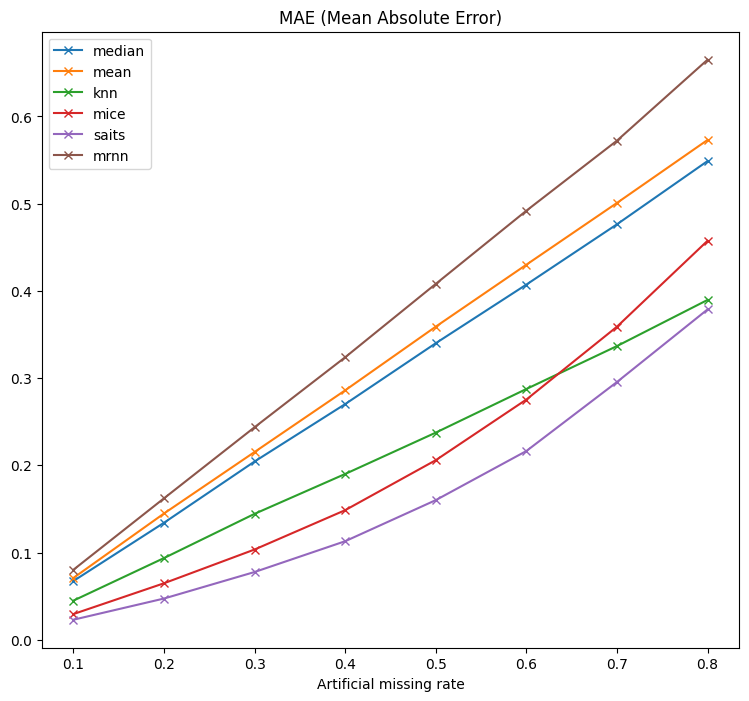

In [53]:
# MAE
df_mae = pd.read_excel('data/MAE_IF_Taiwan2015_0.1_0.82024-05-22 12:07:10.192587.xlsx')
# methods = ['mean', 'median', 'saits', 'brits', 'mrnn', 'transformer']
df_mae.plot(title='MAE (Mean Absolute Error)',x='Artificial missing rate', y=methods, kind="line", figsize=(9, 8), marker='x')



<Axes: title={'center': 'MSE (Mean Squared Error)'}, xlabel='Artificial missing rate'>

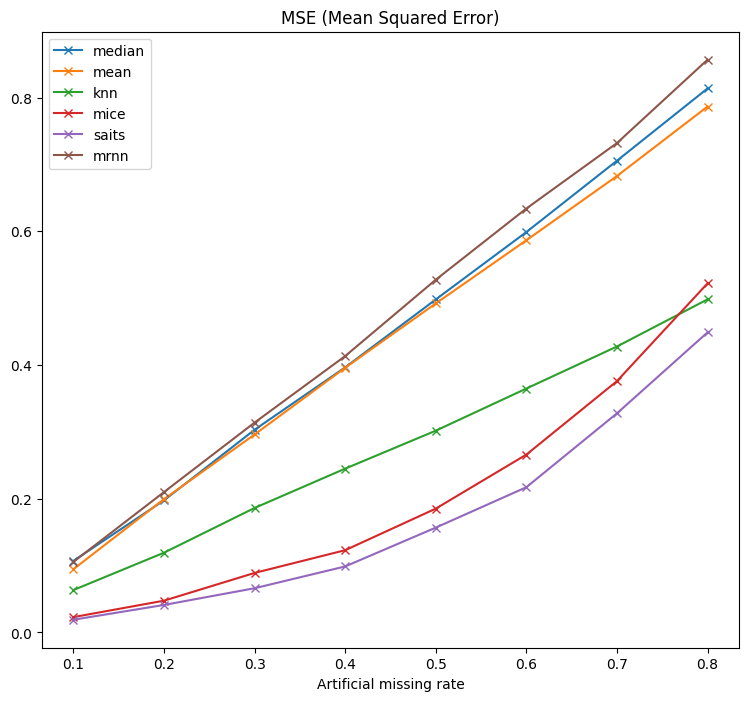

In [55]:
# MSE
df_mse = pd.read_excel('data/MSE_IF_Taiwan2015_0.1_0.82024-05-22 12:07:10.256996.xlsx')
# methods = ['mean', 'median', 'saits', 'brits', 'mrnn', 'transformer']
df_mse.plot(title='MSE (Mean Squared Error)', x='Artificial missing rate', y=methods, kind="line", figsize=(9, 8), marker='x')



<Axes: title={'center': 'RMSE (Root Mean Squared Error)'}, xlabel='Artificial missing rate'>

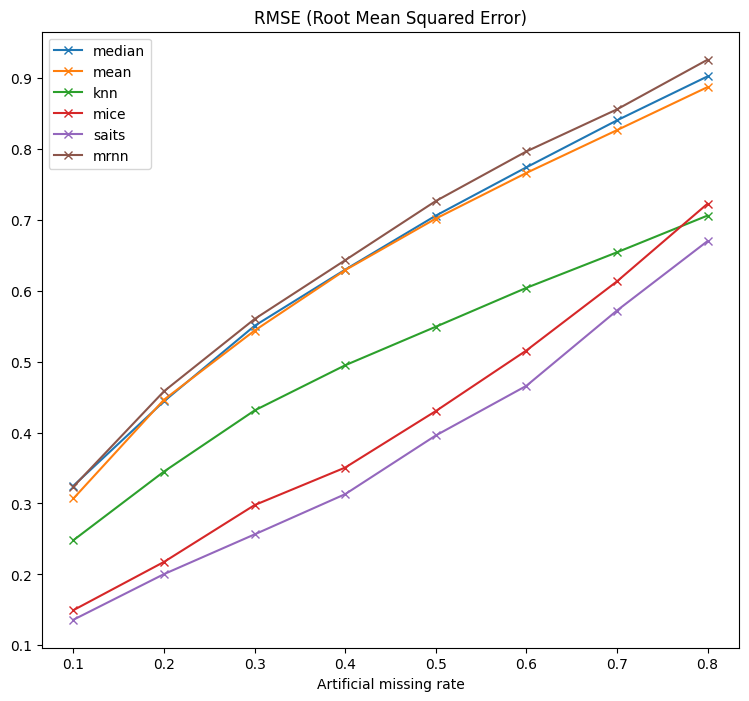

In [56]:
# RMSE
df_rmse = pd.read_excel('data/RMSE_IF_Taiwan2015_0.1_0.82024-05-22 12:07:10.284103.xlsx')
# methods = ['mean', 'median', 'saits', 'brits', 'mrnn', 'transformer']
df_rmse.plot(title='RMSE (Root Mean Squared Error)', x='Artificial missing rate', y=methods, kind="line", figsize=(9, 8), marker='x')



<Axes: title={'center': 'Running time'}, xlabel='Artificial missing rate'>

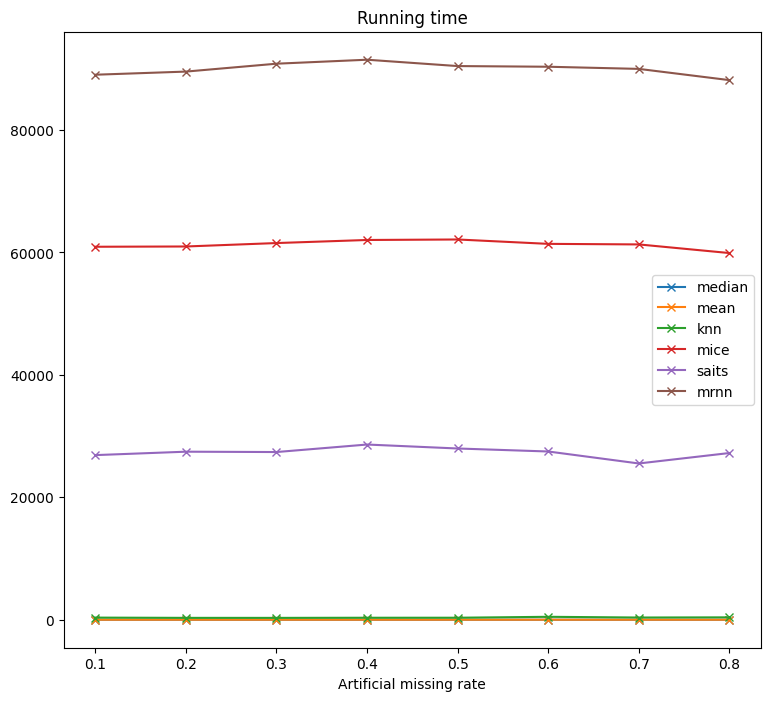

In [57]:
# Running_time
df_running_time = pd.read_excel('data/RunningTime_IF_Taiwan2015_0.1_0.82024-05-22 12:07:10.313163.xlsx')
# methods = ['mean', 'median', 'saits', 'brits', 'mrnn', 'transformer']
df_running_time.plot(title='Running time', x='Artificial missing rate', y=methods, kind="line", figsize=(9, 8), marker='x')


